# Data Processing

In the first stage of this challenge, we imported the slice which were stored in .IMA files and grouped them into arrays for the individual doses. This was needed to compare the lower doses to the Full dose and to determine the hyperparameter for the model creation stage. In this first stage, the doses folders were interated through to find the .IMA files and store it in a data structure.

In [4]:
import glob
import matplotlib.pyplot as plt
from pydicom import dcmread
from PIL import Image
import re
from skimage.restoration import denoise_wavelet
from skimage import img_as_float
from skimage.restoration import denoise_tv_chambolle
from matplotlib import pyplot as plt
from skimage import io
from skimage.metrics import peak_signal_noise_ratio
from pydicom.dataset import FileDataset, FileMetaDataset
from sklearn.metrics import mean_squared_error
from skimage.metrics import structural_similarity
import datetime
import os
import tempfile
import pydicom
from pydicom.dataset import FileDataset, FileMetaDataset
from pydicom.uid import UID
import nibabel as nib
import numpy as np
import scipy.ndimage as ndi
from scipy import stats



files = glob.glob("/Users/randyllpandohie/Downloads/Siemens Vision Quadra/Subject_136-141/*/1-2 dose/*.IMA")
print(len(files))

dose12 = glob.glob("/Users/randyllpandohie/Downloads/Siemens Vision Quadra/Subject_136-141/*/1-2 dose/*.IMA")
dose14 = glob.glob("/Users/randyllpandohie/Downloads/Siemens Vision Quadra/Subject_136-141/*/1-4 dose/*.IMA")
dose110 = glob.glob("/Users/randyllpandohie/Downloads/Siemens Vision Quadra/Subject_136-141/*/1-10 dose/*.IMA")
dose120 = glob.glob("/Users/randyllpandohie/Downloads/Siemens Vision Quadra/Subject_136-141/*/1-20 dose/*.IMA")
dose150 = glob.glob("/Users/randyllpandohie/Downloads/Siemens Vision Quadra/Subject_136-141/*/1-50 dose/*.IMA")
dose1100 = glob.glob("/Users/randyllpandohie/Downloads/Siemens Vision Quadra/Subject_136-141/*/1-100 dose/*.IMA")

ref_files = glob.glob("/Users/randyllpandohie/Downloads/Siemens Vision Quadra/Subject_136-141/*/Full_dose/*.IMA")
print(len(ref_files))

3864
3864


In [5]:
#noisy_img = img_as_float(io.imread(dose110[6]))
#ref_img = img_as_float(io.imread(ref_files[6]))

X_data_dose12,X_data_dose14,X_data_dose110,X_data_dose120,X_data_dose150,X_data_dose1100,ref_fulldose = [],[],[],[],[],[],[]

#loop through and convert the files into an array
for counter in range(len(files)):
   # print(counter)
    X_data_dose12.append(img_as_float(io.imread(dose12[counter])))
    X_data_dose14.append(img_as_float(io.imread(dose14[counter])))
    X_data_dose110.append(img_as_float(io.imread(dose110[counter])))
    X_data_dose120.append(img_as_float(io.imread(dose120[counter])))
    X_data_dose150.append(img_as_float(io.imread(dose150[counter])))
    X_data_dose1100.append(img_as_float(io.imread(dose1100[counter])))
    ref_fulldose.append(img_as_float(io.imread(ref_files[counter])))

print('X_data shape:', np.array(X_data_dose12).shape)

X_data shape: (3864, 440, 440)


# Training and hyperparameter

In this stage we start with the training data to obtain for each type of dose the best parameters based on PNR, MSE and we varied the weight parameter between 0-1 to find the optimal value. Values of weight over 1 didn't have good results.

In [30]:
def wavelet_tv_smooth(X_data,Y_data,w):
    wavelet_smoothed = denoise_wavelet(X_data, multichannel=False,
                           method='BayesShrink', mode='soft',
                           rescale_sigma=True,wavelet='db2')
    denoise_TV = denoise_tv_chambolle(wavelet_smoothed, weight=w, multichannel=False)
    TV_cleaned_psnr = peak_signal_noise_ratio(X_data, Y_data, data_range=1.0)
    mse_tv = mean_squared_error(X_data, Y_data)
    (score, diff) = structural_similarity(X_data, Y_data, full=True)
    return [mse_tv,TV_cleaned_psnr,denoise_TV,score,diff]

#mse_value,psnr_value,denoised_img = wavelet_tv_smooth(X_data_dose12[0],ref_fulldose[0])
mse_value,psnr_value,denoised_img,ssims,ssimdif = [],[],[],[],[]
code_return=[]

def calculate_statistics(file_set,w):
    for counter in range(len(file_set)):
       # mse_value,psnr_value,denoised_img = wavelet_tv_smooth(X_data_dose12[counter],ref_fulldose[counter])
        m,p,d,s,di = wavelet_tv_smooth(file_set[counter],ref_fulldose[counter],w)
        mse_value.append(m)
        psnr_value.append(p)
        denoised_img.append(d)
        ssims.append(s)
        ssimdif.append(di)
    return mse_value,psnr_value,denoised_img,ssims,ssimdif
#print(np.array(code_return).shape)

mse_value,psnr_value,denoised_img,ssims,ssimdif = calculate_statistics(X_data_dose150,0.7)
print(np.mean(mse_value))
print(np.mean(psnr_value))
print(np.mean(ssims))
#plt.imshow(denoised_img[200])
#print(np.mean(mse_value))



/var/folders/y2/pfrk_qsd50bcvhnzr1hxz26c0000gn/T/ipykernel_56722/2438278199.py:2: FutureWarning: `multichannel` is a deprecated argument name for `denoise_wavelet`. It will be removed in version 1.0. Please use `channel_axis` instead.
  wavelet_smoothed = denoise_wavelet(X_data, multichannel=False,
/var/folders/y2/pfrk_qsd50bcvhnzr1hxz26c0000gn/T/ipykernel_56722/2438278199.py:5: FutureWarning: `multichannel` is a deprecated argument name for `denoise_tv_chambolle`. It will be removed in version 1.0. Please use `channel_axis` instead.
  denoise_TV = denoise_tv_chambolle(wavelet_smoothed, weight=w, multichannel=False)
/var/folders/y2/pfrk_qsd50bcvhnzr1hxz26c0000gn/T/ipykernel_56722/2438278199.py:2: FutureWarning: `multichannel` is a deprecated argument name for `denoise_wavelet`. It will be removed in version 1.0. Please use `channel_axis` instead.
  wavelet_smoothed = denoise_wavelet(X_data, multichannel=False,
/var/folders/y2/pfrk_qsd50bcvhnzr1hxz26c0000gn/T/ipykernel_56722/2438278199.

/var/folders/y2/pfrk_qsd50bcvhnzr1hxz26c0000gn/T/ipykernel_56722/2438278199.py:2: FutureWarning: `multichannel` is a deprecated argument name for `denoise_wavelet`. It will be removed in version 1.0. Please use `channel_axis` instead.
  wavelet_smoothed = denoise_wavelet(X_data, multichannel=False,
/var/folders/y2/pfrk_qsd50bcvhnzr1hxz26c0000gn/T/ipykernel_56722/2438278199.py:5: FutureWarning: `multichannel` is a deprecated argument name for `denoise_tv_chambolle`. It will be removed in version 1.0. Please use `channel_axis` instead.
  denoise_TV = denoise_tv_chambolle(wavelet_smoothed, weight=w, multichannel=False)
/var/folders/y2/pfrk_qsd50bcvhnzr1hxz26c0000gn/T/ipykernel_56722/2438278199.py:2: FutureWarning: `multichannel` is a deprecated argument name for `denoise_wavelet`. It will be removed in version 1.0. Please use `channel_axis` instead.
  wavelet_smoothed = denoise_wavelet(X_data, multichannel=False,
/var/folders/y2/pfrk_qsd50bcvhnzr1hxz26c0000gn/T/ipykernel_56722/2438278199.

/var/folders/y2/pfrk_qsd50bcvhnzr1hxz26c0000gn/T/ipykernel_56722/2438278199.py:2: FutureWarning: `multichannel` is a deprecated argument name for `denoise_wavelet`. It will be removed in version 1.0. Please use `channel_axis` instead.
  wavelet_smoothed = denoise_wavelet(X_data, multichannel=False,
/var/folders/y2/pfrk_qsd50bcvhnzr1hxz26c0000gn/T/ipykernel_56722/2438278199.py:5: FutureWarning: `multichannel` is a deprecated argument name for `denoise_tv_chambolle`. It will be removed in version 1.0. Please use `channel_axis` instead.
  denoise_TV = denoise_tv_chambolle(wavelet_smoothed, weight=w, multichannel=False)
/var/folders/y2/pfrk_qsd50bcvhnzr1hxz26c0000gn/T/ipykernel_56722/2438278199.py:2: FutureWarning: `multichannel` is a deprecated argument name for `denoise_wavelet`. It will be removed in version 1.0. Please use `channel_axis` instead.
  wavelet_smoothed = denoise_wavelet(X_data, multichannel=False,
/var/folders/y2/pfrk_qsd50bcvhnzr1hxz26c0000gn/T/ipykernel_56722/2438278199.

/var/folders/y2/pfrk_qsd50bcvhnzr1hxz26c0000gn/T/ipykernel_56722/2438278199.py:2: FutureWarning: `multichannel` is a deprecated argument name for `denoise_wavelet`. It will be removed in version 1.0. Please use `channel_axis` instead.
  wavelet_smoothed = denoise_wavelet(X_data, multichannel=False,
/var/folders/y2/pfrk_qsd50bcvhnzr1hxz26c0000gn/T/ipykernel_56722/2438278199.py:5: FutureWarning: `multichannel` is a deprecated argument name for `denoise_tv_chambolle`. It will be removed in version 1.0. Please use `channel_axis` instead.
  denoise_TV = denoise_tv_chambolle(wavelet_smoothed, weight=w, multichannel=False)
/var/folders/y2/pfrk_qsd50bcvhnzr1hxz26c0000gn/T/ipykernel_56722/2438278199.py:2: FutureWarning: `multichannel` is a deprecated argument name for `denoise_wavelet`. It will be removed in version 1.0. Please use `channel_axis` instead.
  wavelet_smoothed = denoise_wavelet(X_data, multichannel=False,
/var/folders/y2/pfrk_qsd50bcvhnzr1hxz26c0000gn/T/ipykernel_56722/2438278199.

/var/folders/y2/pfrk_qsd50bcvhnzr1hxz26c0000gn/T/ipykernel_56722/2438278199.py:5: FutureWarning: `multichannel` is a deprecated argument name for `denoise_tv_chambolle`. It will be removed in version 1.0. Please use `channel_axis` instead.
  denoise_TV = denoise_tv_chambolle(wavelet_smoothed, weight=w, multichannel=False)
/var/folders/y2/pfrk_qsd50bcvhnzr1hxz26c0000gn/T/ipykernel_56722/2438278199.py:2: FutureWarning: `multichannel` is a deprecated argument name for `denoise_wavelet`. It will be removed in version 1.0. Please use `channel_axis` instead.
  wavelet_smoothed = denoise_wavelet(X_data, multichannel=False,
/var/folders/y2/pfrk_qsd50bcvhnzr1hxz26c0000gn/T/ipykernel_56722/2438278199.py:5: FutureWarning: `multichannel` is a deprecated argument name for `denoise_tv_chambolle`. It will be removed in version 1.0. Please use `channel_axis` instead.
  denoise_TV = denoise_tv_chambolle(wavelet_smoothed, weight=w, multichannel=False)
/var/folders/y2/pfrk_qsd50bcvhnzr1hxz26c0000gn/T/ipy

/var/folders/y2/pfrk_qsd50bcvhnzr1hxz26c0000gn/T/ipykernel_56722/2438278199.py:2: FutureWarning: `multichannel` is a deprecated argument name for `denoise_wavelet`. It will be removed in version 1.0. Please use `channel_axis` instead.
  wavelet_smoothed = denoise_wavelet(X_data, multichannel=False,
/var/folders/y2/pfrk_qsd50bcvhnzr1hxz26c0000gn/T/ipykernel_56722/2438278199.py:5: FutureWarning: `multichannel` is a deprecated argument name for `denoise_tv_chambolle`. It will be removed in version 1.0. Please use `channel_axis` instead.
  denoise_TV = denoise_tv_chambolle(wavelet_smoothed, weight=w, multichannel=False)
/var/folders/y2/pfrk_qsd50bcvhnzr1hxz26c0000gn/T/ipykernel_56722/2438278199.py:2: FutureWarning: `multichannel` is a deprecated argument name for `denoise_wavelet`. It will be removed in version 1.0. Please use `channel_axis` instead.
  wavelet_smoothed = denoise_wavelet(X_data, multichannel=False,
/var/folders/y2/pfrk_qsd50bcvhnzr1hxz26c0000gn/T/ipykernel_56722/2438278199.

/var/folders/y2/pfrk_qsd50bcvhnzr1hxz26c0000gn/T/ipykernel_56722/2438278199.py:2: FutureWarning: `multichannel` is a deprecated argument name for `denoise_wavelet`. It will be removed in version 1.0. Please use `channel_axis` instead.
  wavelet_smoothed = denoise_wavelet(X_data, multichannel=False,
/var/folders/y2/pfrk_qsd50bcvhnzr1hxz26c0000gn/T/ipykernel_56722/2438278199.py:5: FutureWarning: `multichannel` is a deprecated argument name for `denoise_tv_chambolle`. It will be removed in version 1.0. Please use `channel_axis` instead.
  denoise_TV = denoise_tv_chambolle(wavelet_smoothed, weight=w, multichannel=False)
/var/folders/y2/pfrk_qsd50bcvhnzr1hxz26c0000gn/T/ipykernel_56722/2438278199.py:2: FutureWarning: `multichannel` is a deprecated argument name for `denoise_wavelet`. It will be removed in version 1.0. Please use `channel_axis` instead.
  wavelet_smoothed = denoise_wavelet(X_data, multichannel=False,
/var/folders/y2/pfrk_qsd50bcvhnzr1hxz26c0000gn/T/ipykernel_56722/2438278199.

/var/folders/y2/pfrk_qsd50bcvhnzr1hxz26c0000gn/T/ipykernel_56722/2438278199.py:2: FutureWarning: `multichannel` is a deprecated argument name for `denoise_wavelet`. It will be removed in version 1.0. Please use `channel_axis` instead.
  wavelet_smoothed = denoise_wavelet(X_data, multichannel=False,
/var/folders/y2/pfrk_qsd50bcvhnzr1hxz26c0000gn/T/ipykernel_56722/2438278199.py:5: FutureWarning: `multichannel` is a deprecated argument name for `denoise_tv_chambolle`. It will be removed in version 1.0. Please use `channel_axis` instead.
  denoise_TV = denoise_tv_chambolle(wavelet_smoothed, weight=w, multichannel=False)
/var/folders/y2/pfrk_qsd50bcvhnzr1hxz26c0000gn/T/ipykernel_56722/2438278199.py:2: FutureWarning: `multichannel` is a deprecated argument name for `denoise_wavelet`. It will be removed in version 1.0. Please use `channel_axis` instead.
  wavelet_smoothed = denoise_wavelet(X_data, multichannel=False,
/var/folders/y2/pfrk_qsd50bcvhnzr1hxz26c0000gn/T/ipykernel_56722/2438278199.

/var/folders/y2/pfrk_qsd50bcvhnzr1hxz26c0000gn/T/ipykernel_56722/2438278199.py:2: FutureWarning: `multichannel` is a deprecated argument name for `denoise_wavelet`. It will be removed in version 1.0. Please use `channel_axis` instead.
  wavelet_smoothed = denoise_wavelet(X_data, multichannel=False,
/var/folders/y2/pfrk_qsd50bcvhnzr1hxz26c0000gn/T/ipykernel_56722/2438278199.py:5: FutureWarning: `multichannel` is a deprecated argument name for `denoise_tv_chambolle`. It will be removed in version 1.0. Please use `channel_axis` instead.
  denoise_TV = denoise_tv_chambolle(wavelet_smoothed, weight=w, multichannel=False)
/var/folders/y2/pfrk_qsd50bcvhnzr1hxz26c0000gn/T/ipykernel_56722/2438278199.py:2: FutureWarning: `multichannel` is a deprecated argument name for `denoise_wavelet`. It will be removed in version 1.0. Please use `channel_axis` instead.
  wavelet_smoothed = denoise_wavelet(X_data, multichannel=False,
/var/folders/y2/pfrk_qsd50bcvhnzr1hxz26c0000gn/T/ipykernel_56722/2438278199.

/var/folders/y2/pfrk_qsd50bcvhnzr1hxz26c0000gn/T/ipykernel_56722/2438278199.py:2: FutureWarning: `multichannel` is a deprecated argument name for `denoise_wavelet`. It will be removed in version 1.0. Please use `channel_axis` instead.
  wavelet_smoothed = denoise_wavelet(X_data, multichannel=False,
/var/folders/y2/pfrk_qsd50bcvhnzr1hxz26c0000gn/T/ipykernel_56722/2438278199.py:5: FutureWarning: `multichannel` is a deprecated argument name for `denoise_tv_chambolle`. It will be removed in version 1.0. Please use `channel_axis` instead.
  denoise_TV = denoise_tv_chambolle(wavelet_smoothed, weight=w, multichannel=False)
/var/folders/y2/pfrk_qsd50bcvhnzr1hxz26c0000gn/T/ipykernel_56722/2438278199.py:2: FutureWarning: `multichannel` is a deprecated argument name for `denoise_wavelet`. It will be removed in version 1.0. Please use `channel_axis` instead.
  wavelet_smoothed = denoise_wavelet(X_data, multichannel=False,
/var/folders/y2/pfrk_qsd50bcvhnzr1hxz26c0000gn/T/ipykernel_56722/2438278199.

/var/folders/y2/pfrk_qsd50bcvhnzr1hxz26c0000gn/T/ipykernel_56722/2438278199.py:2: FutureWarning: `multichannel` is a deprecated argument name for `denoise_wavelet`. It will be removed in version 1.0. Please use `channel_axis` instead.
  wavelet_smoothed = denoise_wavelet(X_data, multichannel=False,
/var/folders/y2/pfrk_qsd50bcvhnzr1hxz26c0000gn/T/ipykernel_56722/2438278199.py:5: FutureWarning: `multichannel` is a deprecated argument name for `denoise_tv_chambolle`. It will be removed in version 1.0. Please use `channel_axis` instead.
  denoise_TV = denoise_tv_chambolle(wavelet_smoothed, weight=w, multichannel=False)
/var/folders/y2/pfrk_qsd50bcvhnzr1hxz26c0000gn/T/ipykernel_56722/2438278199.py:2: FutureWarning: `multichannel` is a deprecated argument name for `denoise_wavelet`. It will be removed in version 1.0. Please use `channel_axis` instead.
  wavelet_smoothed = denoise_wavelet(X_data, multichannel=False,
/var/folders/y2/pfrk_qsd50bcvhnzr1hxz26c0000gn/T/ipykernel_56722/2438278199.

/var/folders/y2/pfrk_qsd50bcvhnzr1hxz26c0000gn/T/ipykernel_56722/2438278199.py:5: FutureWarning: `multichannel` is a deprecated argument name for `denoise_tv_chambolle`. It will be removed in version 1.0. Please use `channel_axis` instead.
  denoise_TV = denoise_tv_chambolle(wavelet_smoothed, weight=w, multichannel=False)
/var/folders/y2/pfrk_qsd50bcvhnzr1hxz26c0000gn/T/ipykernel_56722/2438278199.py:2: FutureWarning: `multichannel` is a deprecated argument name for `denoise_wavelet`. It will be removed in version 1.0. Please use `channel_axis` instead.
  wavelet_smoothed = denoise_wavelet(X_data, multichannel=False,
/var/folders/y2/pfrk_qsd50bcvhnzr1hxz26c0000gn/T/ipykernel_56722/2438278199.py:5: FutureWarning: `multichannel` is a deprecated argument name for `denoise_tv_chambolle`. It will be removed in version 1.0. Please use `channel_axis` instead.
  denoise_TV = denoise_tv_chambolle(wavelet_smoothed, weight=w, multichannel=False)
/var/folders/y2/pfrk_qsd50bcvhnzr1hxz26c0000gn/T/ipy

/var/folders/y2/pfrk_qsd50bcvhnzr1hxz26c0000gn/T/ipykernel_56722/2438278199.py:2: FutureWarning: `multichannel` is a deprecated argument name for `denoise_wavelet`. It will be removed in version 1.0. Please use `channel_axis` instead.
  wavelet_smoothed = denoise_wavelet(X_data, multichannel=False,
/var/folders/y2/pfrk_qsd50bcvhnzr1hxz26c0000gn/T/ipykernel_56722/2438278199.py:5: FutureWarning: `multichannel` is a deprecated argument name for `denoise_tv_chambolle`. It will be removed in version 1.0. Please use `channel_axis` instead.
  denoise_TV = denoise_tv_chambolle(wavelet_smoothed, weight=w, multichannel=False)
/var/folders/y2/pfrk_qsd50bcvhnzr1hxz26c0000gn/T/ipykernel_56722/2438278199.py:2: FutureWarning: `multichannel` is a deprecated argument name for `denoise_wavelet`. It will be removed in version 1.0. Please use `channel_axis` instead.
  wavelet_smoothed = denoise_wavelet(X_data, multichannel=False,
/var/folders/y2/pfrk_qsd50bcvhnzr1hxz26c0000gn/T/ipykernel_56722/2438278199.

/var/folders/y2/pfrk_qsd50bcvhnzr1hxz26c0000gn/T/ipykernel_56722/2438278199.py:2: FutureWarning: `multichannel` is a deprecated argument name for `denoise_wavelet`. It will be removed in version 1.0. Please use `channel_axis` instead.
  wavelet_smoothed = denoise_wavelet(X_data, multichannel=False,
/var/folders/y2/pfrk_qsd50bcvhnzr1hxz26c0000gn/T/ipykernel_56722/2438278199.py:5: FutureWarning: `multichannel` is a deprecated argument name for `denoise_tv_chambolle`. It will be removed in version 1.0. Please use `channel_axis` instead.
  denoise_TV = denoise_tv_chambolle(wavelet_smoothed, weight=w, multichannel=False)
/var/folders/y2/pfrk_qsd50bcvhnzr1hxz26c0000gn/T/ipykernel_56722/2438278199.py:2: FutureWarning: `multichannel` is a deprecated argument name for `denoise_wavelet`. It will be removed in version 1.0. Please use `channel_axis` instead.
  wavelet_smoothed = denoise_wavelet(X_data, multichannel=False,
/var/folders/y2/pfrk_qsd50bcvhnzr1hxz26c0000gn/T/ipykernel_56722/2438278199.

/var/folders/y2/pfrk_qsd50bcvhnzr1hxz26c0000gn/T/ipykernel_56722/2438278199.py:5: FutureWarning: `multichannel` is a deprecated argument name for `denoise_tv_chambolle`. It will be removed in version 1.0. Please use `channel_axis` instead.
  denoise_TV = denoise_tv_chambolle(wavelet_smoothed, weight=w, multichannel=False)
/var/folders/y2/pfrk_qsd50bcvhnzr1hxz26c0000gn/T/ipykernel_56722/2438278199.py:2: FutureWarning: `multichannel` is a deprecated argument name for `denoise_wavelet`. It will be removed in version 1.0. Please use `channel_axis` instead.
  wavelet_smoothed = denoise_wavelet(X_data, multichannel=False,
/var/folders/y2/pfrk_qsd50bcvhnzr1hxz26c0000gn/T/ipykernel_56722/2438278199.py:5: FutureWarning: `multichannel` is a deprecated argument name for `denoise_tv_chambolle`. It will be removed in version 1.0. Please use `channel_axis` instead.
  denoise_TV = denoise_tv_chambolle(wavelet_smoothed, weight=w, multichannel=False)
/var/folders/y2/pfrk_qsd50bcvhnzr1hxz26c0000gn/T/ipy

/var/folders/y2/pfrk_qsd50bcvhnzr1hxz26c0000gn/T/ipykernel_56722/2438278199.py:2: FutureWarning: `multichannel` is a deprecated argument name for `denoise_wavelet`. It will be removed in version 1.0. Please use `channel_axis` instead.
  wavelet_smoothed = denoise_wavelet(X_data, multichannel=False,
/var/folders/y2/pfrk_qsd50bcvhnzr1hxz26c0000gn/T/ipykernel_56722/2438278199.py:5: FutureWarning: `multichannel` is a deprecated argument name for `denoise_tv_chambolle`. It will be removed in version 1.0. Please use `channel_axis` instead.
  denoise_TV = denoise_tv_chambolle(wavelet_smoothed, weight=w, multichannel=False)
/var/folders/y2/pfrk_qsd50bcvhnzr1hxz26c0000gn/T/ipykernel_56722/2438278199.py:2: FutureWarning: `multichannel` is a deprecated argument name for `denoise_wavelet`. It will be removed in version 1.0. Please use `channel_axis` instead.
  wavelet_smoothed = denoise_wavelet(X_data, multichannel=False,
/var/folders/y2/pfrk_qsd50bcvhnzr1hxz26c0000gn/T/ipykernel_56722/2438278199.

/var/folders/y2/pfrk_qsd50bcvhnzr1hxz26c0000gn/T/ipykernel_56722/2438278199.py:5: FutureWarning: `multichannel` is a deprecated argument name for `denoise_tv_chambolle`. It will be removed in version 1.0. Please use `channel_axis` instead.
  denoise_TV = denoise_tv_chambolle(wavelet_smoothed, weight=w, multichannel=False)
/var/folders/y2/pfrk_qsd50bcvhnzr1hxz26c0000gn/T/ipykernel_56722/2438278199.py:2: FutureWarning: `multichannel` is a deprecated argument name for `denoise_wavelet`. It will be removed in version 1.0. Please use `channel_axis` instead.
  wavelet_smoothed = denoise_wavelet(X_data, multichannel=False,
/var/folders/y2/pfrk_qsd50bcvhnzr1hxz26c0000gn/T/ipykernel_56722/2438278199.py:5: FutureWarning: `multichannel` is a deprecated argument name for `denoise_tv_chambolle`. It will be removed in version 1.0. Please use `channel_axis` instead.
  denoise_TV = denoise_tv_chambolle(wavelet_smoothed, weight=w, multichannel=False)
/var/folders/y2/pfrk_qsd50bcvhnzr1hxz26c0000gn/T/ipy

/var/folders/y2/pfrk_qsd50bcvhnzr1hxz26c0000gn/T/ipykernel_56722/2438278199.py:2: FutureWarning: `multichannel` is a deprecated argument name for `denoise_wavelet`. It will be removed in version 1.0. Please use `channel_axis` instead.
  wavelet_smoothed = denoise_wavelet(X_data, multichannel=False,
/var/folders/y2/pfrk_qsd50bcvhnzr1hxz26c0000gn/T/ipykernel_56722/2438278199.py:5: FutureWarning: `multichannel` is a deprecated argument name for `denoise_tv_chambolle`. It will be removed in version 1.0. Please use `channel_axis` instead.
  denoise_TV = denoise_tv_chambolle(wavelet_smoothed, weight=w, multichannel=False)
/var/folders/y2/pfrk_qsd50bcvhnzr1hxz26c0000gn/T/ipykernel_56722/2438278199.py:2: FutureWarning: `multichannel` is a deprecated argument name for `denoise_wavelet`. It will be removed in version 1.0. Please use `channel_axis` instead.
  wavelet_smoothed = denoise_wavelet(X_data, multichannel=False,
/var/folders/y2/pfrk_qsd50bcvhnzr1hxz26c0000gn/T/ipykernel_56722/2438278199.

/var/folders/y2/pfrk_qsd50bcvhnzr1hxz26c0000gn/T/ipykernel_56722/2438278199.py:5: FutureWarning: `multichannel` is a deprecated argument name for `denoise_tv_chambolle`. It will be removed in version 1.0. Please use `channel_axis` instead.
  denoise_TV = denoise_tv_chambolle(wavelet_smoothed, weight=w, multichannel=False)
/var/folders/y2/pfrk_qsd50bcvhnzr1hxz26c0000gn/T/ipykernel_56722/2438278199.py:2: FutureWarning: `multichannel` is a deprecated argument name for `denoise_wavelet`. It will be removed in version 1.0. Please use `channel_axis` instead.
  wavelet_smoothed = denoise_wavelet(X_data, multichannel=False,
/var/folders/y2/pfrk_qsd50bcvhnzr1hxz26c0000gn/T/ipykernel_56722/2438278199.py:5: FutureWarning: `multichannel` is a deprecated argument name for `denoise_tv_chambolle`. It will be removed in version 1.0. Please use `channel_axis` instead.
  denoise_TV = denoise_tv_chambolle(wavelet_smoothed, weight=w, multichannel=False)
/var/folders/y2/pfrk_qsd50bcvhnzr1hxz26c0000gn/T/ipy

/var/folders/y2/pfrk_qsd50bcvhnzr1hxz26c0000gn/T/ipykernel_56722/2438278199.py:2: FutureWarning: `multichannel` is a deprecated argument name for `denoise_wavelet`. It will be removed in version 1.0. Please use `channel_axis` instead.
  wavelet_smoothed = denoise_wavelet(X_data, multichannel=False,
/var/folders/y2/pfrk_qsd50bcvhnzr1hxz26c0000gn/T/ipykernel_56722/2438278199.py:5: FutureWarning: `multichannel` is a deprecated argument name for `denoise_tv_chambolle`. It will be removed in version 1.0. Please use `channel_axis` instead.
  denoise_TV = denoise_tv_chambolle(wavelet_smoothed, weight=w, multichannel=False)
/var/folders/y2/pfrk_qsd50bcvhnzr1hxz26c0000gn/T/ipykernel_56722/2438278199.py:2: FutureWarning: `multichannel` is a deprecated argument name for `denoise_wavelet`. It will be removed in version 1.0. Please use `channel_axis` instead.
  wavelet_smoothed = denoise_wavelet(X_data, multichannel=False,
/var/folders/y2/pfrk_qsd50bcvhnzr1hxz26c0000gn/T/ipykernel_56722/2438278199.

/var/folders/y2/pfrk_qsd50bcvhnzr1hxz26c0000gn/T/ipykernel_56722/2438278199.py:2: FutureWarning: `multichannel` is a deprecated argument name for `denoise_wavelet`. It will be removed in version 1.0. Please use `channel_axis` instead.
  wavelet_smoothed = denoise_wavelet(X_data, multichannel=False,
/var/folders/y2/pfrk_qsd50bcvhnzr1hxz26c0000gn/T/ipykernel_56722/2438278199.py:5: FutureWarning: `multichannel` is a deprecated argument name for `denoise_tv_chambolle`. It will be removed in version 1.0. Please use `channel_axis` instead.
  denoise_TV = denoise_tv_chambolle(wavelet_smoothed, weight=w, multichannel=False)
/var/folders/y2/pfrk_qsd50bcvhnzr1hxz26c0000gn/T/ipykernel_56722/2438278199.py:2: FutureWarning: `multichannel` is a deprecated argument name for `denoise_wavelet`. It will be removed in version 1.0. Please use `channel_axis` instead.
  wavelet_smoothed = denoise_wavelet(X_data, multichannel=False,
/var/folders/y2/pfrk_qsd50bcvhnzr1hxz26c0000gn/T/ipykernel_56722/2438278199.

/var/folders/y2/pfrk_qsd50bcvhnzr1hxz26c0000gn/T/ipykernel_56722/2438278199.py:2: FutureWarning: `multichannel` is a deprecated argument name for `denoise_wavelet`. It will be removed in version 1.0. Please use `channel_axis` instead.
  wavelet_smoothed = denoise_wavelet(X_data, multichannel=False,
/var/folders/y2/pfrk_qsd50bcvhnzr1hxz26c0000gn/T/ipykernel_56722/2438278199.py:5: FutureWarning: `multichannel` is a deprecated argument name for `denoise_tv_chambolle`. It will be removed in version 1.0. Please use `channel_axis` instead.
  denoise_TV = denoise_tv_chambolle(wavelet_smoothed, weight=w, multichannel=False)
/var/folders/y2/pfrk_qsd50bcvhnzr1hxz26c0000gn/T/ipykernel_56722/2438278199.py:2: FutureWarning: `multichannel` is a deprecated argument name for `denoise_wavelet`. It will be removed in version 1.0. Please use `channel_axis` instead.
  wavelet_smoothed = denoise_wavelet(X_data, multichannel=False,
/var/folders/y2/pfrk_qsd50bcvhnzr1hxz26c0000gn/T/ipykernel_56722/2438278199.

/var/folders/y2/pfrk_qsd50bcvhnzr1hxz26c0000gn/T/ipykernel_56722/2438278199.py:2: FutureWarning: `multichannel` is a deprecated argument name for `denoise_wavelet`. It will be removed in version 1.0. Please use `channel_axis` instead.
  wavelet_smoothed = denoise_wavelet(X_data, multichannel=False,
/var/folders/y2/pfrk_qsd50bcvhnzr1hxz26c0000gn/T/ipykernel_56722/2438278199.py:5: FutureWarning: `multichannel` is a deprecated argument name for `denoise_tv_chambolle`. It will be removed in version 1.0. Please use `channel_axis` instead.
  denoise_TV = denoise_tv_chambolle(wavelet_smoothed, weight=w, multichannel=False)
/var/folders/y2/pfrk_qsd50bcvhnzr1hxz26c0000gn/T/ipykernel_56722/2438278199.py:2: FutureWarning: `multichannel` is a deprecated argument name for `denoise_wavelet`. It will be removed in version 1.0. Please use `channel_axis` instead.
  wavelet_smoothed = denoise_wavelet(X_data, multichannel=False,
/var/folders/y2/pfrk_qsd50bcvhnzr1hxz26c0000gn/T/ipykernel_56722/2438278199.

/var/folders/y2/pfrk_qsd50bcvhnzr1hxz26c0000gn/T/ipykernel_56722/2438278199.py:5: FutureWarning: `multichannel` is a deprecated argument name for `denoise_tv_chambolle`. It will be removed in version 1.0. Please use `channel_axis` instead.
  denoise_TV = denoise_tv_chambolle(wavelet_smoothed, weight=w, multichannel=False)
/var/folders/y2/pfrk_qsd50bcvhnzr1hxz26c0000gn/T/ipykernel_56722/2438278199.py:2: FutureWarning: `multichannel` is a deprecated argument name for `denoise_wavelet`. It will be removed in version 1.0. Please use `channel_axis` instead.
  wavelet_smoothed = denoise_wavelet(X_data, multichannel=False,
/var/folders/y2/pfrk_qsd50bcvhnzr1hxz26c0000gn/T/ipykernel_56722/2438278199.py:5: FutureWarning: `multichannel` is a deprecated argument name for `denoise_tv_chambolle`. It will be removed in version 1.0. Please use `channel_axis` instead.
  denoise_TV = denoise_tv_chambolle(wavelet_smoothed, weight=w, multichannel=False)
/var/folders/y2/pfrk_qsd50bcvhnzr1hxz26c0000gn/T/ipy

/var/folders/y2/pfrk_qsd50bcvhnzr1hxz26c0000gn/T/ipykernel_56722/2438278199.py:2: FutureWarning: `multichannel` is a deprecated argument name for `denoise_wavelet`. It will be removed in version 1.0. Please use `channel_axis` instead.
  wavelet_smoothed = denoise_wavelet(X_data, multichannel=False,
/var/folders/y2/pfrk_qsd50bcvhnzr1hxz26c0000gn/T/ipykernel_56722/2438278199.py:5: FutureWarning: `multichannel` is a deprecated argument name for `denoise_tv_chambolle`. It will be removed in version 1.0. Please use `channel_axis` instead.
  denoise_TV = denoise_tv_chambolle(wavelet_smoothed, weight=w, multichannel=False)
/var/folders/y2/pfrk_qsd50bcvhnzr1hxz26c0000gn/T/ipykernel_56722/2438278199.py:2: FutureWarning: `multichannel` is a deprecated argument name for `denoise_wavelet`. It will be removed in version 1.0. Please use `channel_axis` instead.
  wavelet_smoothed = denoise_wavelet(X_data, multichannel=False,
/var/folders/y2/pfrk_qsd50bcvhnzr1hxz26c0000gn/T/ipykernel_56722/2438278199.

/var/folders/y2/pfrk_qsd50bcvhnzr1hxz26c0000gn/T/ipykernel_56722/2438278199.py:2: FutureWarning: `multichannel` is a deprecated argument name for `denoise_wavelet`. It will be removed in version 1.0. Please use `channel_axis` instead.
  wavelet_smoothed = denoise_wavelet(X_data, multichannel=False,
/var/folders/y2/pfrk_qsd50bcvhnzr1hxz26c0000gn/T/ipykernel_56722/2438278199.py:5: FutureWarning: `multichannel` is a deprecated argument name for `denoise_tv_chambolle`. It will be removed in version 1.0. Please use `channel_axis` instead.
  denoise_TV = denoise_tv_chambolle(wavelet_smoothed, weight=w, multichannel=False)
/var/folders/y2/pfrk_qsd50bcvhnzr1hxz26c0000gn/T/ipykernel_56722/2438278199.py:2: FutureWarning: `multichannel` is a deprecated argument name for `denoise_wavelet`. It will be removed in version 1.0. Please use `channel_axis` instead.
  wavelet_smoothed = denoise_wavelet(X_data, multichannel=False,
/var/folders/y2/pfrk_qsd50bcvhnzr1hxz26c0000gn/T/ipykernel_56722/2438278199.

/var/folders/y2/pfrk_qsd50bcvhnzr1hxz26c0000gn/T/ipykernel_56722/2438278199.py:2: FutureWarning: `multichannel` is a deprecated argument name for `denoise_wavelet`. It will be removed in version 1.0. Please use `channel_axis` instead.
  wavelet_smoothed = denoise_wavelet(X_data, multichannel=False,
/var/folders/y2/pfrk_qsd50bcvhnzr1hxz26c0000gn/T/ipykernel_56722/2438278199.py:5: FutureWarning: `multichannel` is a deprecated argument name for `denoise_tv_chambolle`. It will be removed in version 1.0. Please use `channel_axis` instead.
  denoise_TV = denoise_tv_chambolle(wavelet_smoothed, weight=w, multichannel=False)
/var/folders/y2/pfrk_qsd50bcvhnzr1hxz26c0000gn/T/ipykernel_56722/2438278199.py:2: FutureWarning: `multichannel` is a deprecated argument name for `denoise_wavelet`. It will be removed in version 1.0. Please use `channel_axis` instead.
  wavelet_smoothed = denoise_wavelet(X_data, multichannel=False,
/var/folders/y2/pfrk_qsd50bcvhnzr1hxz26c0000gn/T/ipykernel_56722/2438278199.

/var/folders/y2/pfrk_qsd50bcvhnzr1hxz26c0000gn/T/ipykernel_56722/2438278199.py:2: FutureWarning: `multichannel` is a deprecated argument name for `denoise_wavelet`. It will be removed in version 1.0. Please use `channel_axis` instead.
  wavelet_smoothed = denoise_wavelet(X_data, multichannel=False,
/var/folders/y2/pfrk_qsd50bcvhnzr1hxz26c0000gn/T/ipykernel_56722/2438278199.py:5: FutureWarning: `multichannel` is a deprecated argument name for `denoise_tv_chambolle`. It will be removed in version 1.0. Please use `channel_axis` instead.
  denoise_TV = denoise_tv_chambolle(wavelet_smoothed, weight=w, multichannel=False)
/var/folders/y2/pfrk_qsd50bcvhnzr1hxz26c0000gn/T/ipykernel_56722/2438278199.py:2: FutureWarning: `multichannel` is a deprecated argument name for `denoise_wavelet`. It will be removed in version 1.0. Please use `channel_axis` instead.
  wavelet_smoothed = denoise_wavelet(X_data, multichannel=False,
/var/folders/y2/pfrk_qsd50bcvhnzr1hxz26c0000gn/T/ipykernel_56722/2438278199.

/var/folders/y2/pfrk_qsd50bcvhnzr1hxz26c0000gn/T/ipykernel_56722/2438278199.py:5: FutureWarning: `multichannel` is a deprecated argument name for `denoise_tv_chambolle`. It will be removed in version 1.0. Please use `channel_axis` instead.
  denoise_TV = denoise_tv_chambolle(wavelet_smoothed, weight=w, multichannel=False)
/var/folders/y2/pfrk_qsd50bcvhnzr1hxz26c0000gn/T/ipykernel_56722/2438278199.py:2: FutureWarning: `multichannel` is a deprecated argument name for `denoise_wavelet`. It will be removed in version 1.0. Please use `channel_axis` instead.
  wavelet_smoothed = denoise_wavelet(X_data, multichannel=False,
/var/folders/y2/pfrk_qsd50bcvhnzr1hxz26c0000gn/T/ipykernel_56722/2438278199.py:5: FutureWarning: `multichannel` is a deprecated argument name for `denoise_tv_chambolle`. It will be removed in version 1.0. Please use `channel_axis` instead.
  denoise_TV = denoise_tv_chambolle(wavelet_smoothed, weight=w, multichannel=False)
/var/folders/y2/pfrk_qsd50bcvhnzr1hxz26c0000gn/T/ipy

/var/folders/y2/pfrk_qsd50bcvhnzr1hxz26c0000gn/T/ipykernel_56722/2438278199.py:5: FutureWarning: `multichannel` is a deprecated argument name for `denoise_tv_chambolle`. It will be removed in version 1.0. Please use `channel_axis` instead.
  denoise_TV = denoise_tv_chambolle(wavelet_smoothed, weight=w, multichannel=False)
/var/folders/y2/pfrk_qsd50bcvhnzr1hxz26c0000gn/T/ipykernel_56722/2438278199.py:2: FutureWarning: `multichannel` is a deprecated argument name for `denoise_wavelet`. It will be removed in version 1.0. Please use `channel_axis` instead.
  wavelet_smoothed = denoise_wavelet(X_data, multichannel=False,
/var/folders/y2/pfrk_qsd50bcvhnzr1hxz26c0000gn/T/ipykernel_56722/2438278199.py:5: FutureWarning: `multichannel` is a deprecated argument name for `denoise_tv_chambolle`. It will be removed in version 1.0. Please use `channel_axis` instead.
  denoise_TV = denoise_tv_chambolle(wavelet_smoothed, weight=w, multichannel=False)
/var/folders/y2/pfrk_qsd50bcvhnzr1hxz26c0000gn/T/ipy

/var/folders/y2/pfrk_qsd50bcvhnzr1hxz26c0000gn/T/ipykernel_56722/2438278199.py:2: FutureWarning: `multichannel` is a deprecated argument name for `denoise_wavelet`. It will be removed in version 1.0. Please use `channel_axis` instead.
  wavelet_smoothed = denoise_wavelet(X_data, multichannel=False,
/var/folders/y2/pfrk_qsd50bcvhnzr1hxz26c0000gn/T/ipykernel_56722/2438278199.py:5: FutureWarning: `multichannel` is a deprecated argument name for `denoise_tv_chambolle`. It will be removed in version 1.0. Please use `channel_axis` instead.
  denoise_TV = denoise_tv_chambolle(wavelet_smoothed, weight=w, multichannel=False)
/var/folders/y2/pfrk_qsd50bcvhnzr1hxz26c0000gn/T/ipykernel_56722/2438278199.py:2: FutureWarning: `multichannel` is a deprecated argument name for `denoise_wavelet`. It will be removed in version 1.0. Please use `channel_axis` instead.
  wavelet_smoothed = denoise_wavelet(X_data, multichannel=False,
/var/folders/y2/pfrk_qsd50bcvhnzr1hxz26c0000gn/T/ipykernel_56722/2438278199.

/var/folders/y2/pfrk_qsd50bcvhnzr1hxz26c0000gn/T/ipykernel_56722/2438278199.py:2: FutureWarning: `multichannel` is a deprecated argument name for `denoise_wavelet`. It will be removed in version 1.0. Please use `channel_axis` instead.
  wavelet_smoothed = denoise_wavelet(X_data, multichannel=False,
/var/folders/y2/pfrk_qsd50bcvhnzr1hxz26c0000gn/T/ipykernel_56722/2438278199.py:5: FutureWarning: `multichannel` is a deprecated argument name for `denoise_tv_chambolle`. It will be removed in version 1.0. Please use `channel_axis` instead.
  denoise_TV = denoise_tv_chambolle(wavelet_smoothed, weight=w, multichannel=False)
/var/folders/y2/pfrk_qsd50bcvhnzr1hxz26c0000gn/T/ipykernel_56722/2438278199.py:2: FutureWarning: `multichannel` is a deprecated argument name for `denoise_wavelet`. It will be removed in version 1.0. Please use `channel_axis` instead.
  wavelet_smoothed = denoise_wavelet(X_data, multichannel=False,
/var/folders/y2/pfrk_qsd50bcvhnzr1hxz26c0000gn/T/ipykernel_56722/2438278199.

/var/folders/y2/pfrk_qsd50bcvhnzr1hxz26c0000gn/T/ipykernel_56722/2438278199.py:2: FutureWarning: `multichannel` is a deprecated argument name for `denoise_wavelet`. It will be removed in version 1.0. Please use `channel_axis` instead.
  wavelet_smoothed = denoise_wavelet(X_data, multichannel=False,
/var/folders/y2/pfrk_qsd50bcvhnzr1hxz26c0000gn/T/ipykernel_56722/2438278199.py:5: FutureWarning: `multichannel` is a deprecated argument name for `denoise_tv_chambolle`. It will be removed in version 1.0. Please use `channel_axis` instead.
  denoise_TV = denoise_tv_chambolle(wavelet_smoothed, weight=w, multichannel=False)
/var/folders/y2/pfrk_qsd50bcvhnzr1hxz26c0000gn/T/ipykernel_56722/2438278199.py:2: FutureWarning: `multichannel` is a deprecated argument name for `denoise_wavelet`. It will be removed in version 1.0. Please use `channel_axis` instead.
  wavelet_smoothed = denoise_wavelet(X_data, multichannel=False,
/var/folders/y2/pfrk_qsd50bcvhnzr1hxz26c0000gn/T/ipykernel_56722/2438278199.

/var/folders/y2/pfrk_qsd50bcvhnzr1hxz26c0000gn/T/ipykernel_56722/2438278199.py:5: FutureWarning: `multichannel` is a deprecated argument name for `denoise_tv_chambolle`. It will be removed in version 1.0. Please use `channel_axis` instead.
  denoise_TV = denoise_tv_chambolle(wavelet_smoothed, weight=w, multichannel=False)
/var/folders/y2/pfrk_qsd50bcvhnzr1hxz26c0000gn/T/ipykernel_56722/2438278199.py:2: FutureWarning: `multichannel` is a deprecated argument name for `denoise_wavelet`. It will be removed in version 1.0. Please use `channel_axis` instead.
  wavelet_smoothed = denoise_wavelet(X_data, multichannel=False,
/var/folders/y2/pfrk_qsd50bcvhnzr1hxz26c0000gn/T/ipykernel_56722/2438278199.py:5: FutureWarning: `multichannel` is a deprecated argument name for `denoise_tv_chambolle`. It will be removed in version 1.0. Please use `channel_axis` instead.
  denoise_TV = denoise_tv_chambolle(wavelet_smoothed, weight=w, multichannel=False)
/var/folders/y2/pfrk_qsd50bcvhnzr1hxz26c0000gn/T/ipy

/var/folders/y2/pfrk_qsd50bcvhnzr1hxz26c0000gn/T/ipykernel_56722/2438278199.py:2: FutureWarning: `multichannel` is a deprecated argument name for `denoise_wavelet`. It will be removed in version 1.0. Please use `channel_axis` instead.
  wavelet_smoothed = denoise_wavelet(X_data, multichannel=False,
/var/folders/y2/pfrk_qsd50bcvhnzr1hxz26c0000gn/T/ipykernel_56722/2438278199.py:5: FutureWarning: `multichannel` is a deprecated argument name for `denoise_tv_chambolle`. It will be removed in version 1.0. Please use `channel_axis` instead.
  denoise_TV = denoise_tv_chambolle(wavelet_smoothed, weight=w, multichannel=False)
/var/folders/y2/pfrk_qsd50bcvhnzr1hxz26c0000gn/T/ipykernel_56722/2438278199.py:2: FutureWarning: `multichannel` is a deprecated argument name for `denoise_wavelet`. It will be removed in version 1.0. Please use `channel_axis` instead.
  wavelet_smoothed = denoise_wavelet(X_data, multichannel=False,
/var/folders/y2/pfrk_qsd50bcvhnzr1hxz26c0000gn/T/ipykernel_56722/2438278199.

/var/folders/y2/pfrk_qsd50bcvhnzr1hxz26c0000gn/T/ipykernel_56722/2438278199.py:5: FutureWarning: `multichannel` is a deprecated argument name for `denoise_tv_chambolle`. It will be removed in version 1.0. Please use `channel_axis` instead.
  denoise_TV = denoise_tv_chambolle(wavelet_smoothed, weight=w, multichannel=False)
/var/folders/y2/pfrk_qsd50bcvhnzr1hxz26c0000gn/T/ipykernel_56722/2438278199.py:2: FutureWarning: `multichannel` is a deprecated argument name for `denoise_wavelet`. It will be removed in version 1.0. Please use `channel_axis` instead.
  wavelet_smoothed = denoise_wavelet(X_data, multichannel=False,
/var/folders/y2/pfrk_qsd50bcvhnzr1hxz26c0000gn/T/ipykernel_56722/2438278199.py:5: FutureWarning: `multichannel` is a deprecated argument name for `denoise_tv_chambolle`. It will be removed in version 1.0. Please use `channel_axis` instead.
  denoise_TV = denoise_tv_chambolle(wavelet_smoothed, weight=w, multichannel=False)
/var/folders/y2/pfrk_qsd50bcvhnzr1hxz26c0000gn/T/ipy

/var/folders/y2/pfrk_qsd50bcvhnzr1hxz26c0000gn/T/ipykernel_56722/2438278199.py:2: FutureWarning: `multichannel` is a deprecated argument name for `denoise_wavelet`. It will be removed in version 1.0. Please use `channel_axis` instead.
  wavelet_smoothed = denoise_wavelet(X_data, multichannel=False,
/var/folders/y2/pfrk_qsd50bcvhnzr1hxz26c0000gn/T/ipykernel_56722/2438278199.py:5: FutureWarning: `multichannel` is a deprecated argument name for `denoise_tv_chambolle`. It will be removed in version 1.0. Please use `channel_axis` instead.
  denoise_TV = denoise_tv_chambolle(wavelet_smoothed, weight=w, multichannel=False)
/var/folders/y2/pfrk_qsd50bcvhnzr1hxz26c0000gn/T/ipykernel_56722/2438278199.py:2: FutureWarning: `multichannel` is a deprecated argument name for `denoise_wavelet`. It will be removed in version 1.0. Please use `channel_axis` instead.
  wavelet_smoothed = denoise_wavelet(X_data, multichannel=False,
/var/folders/y2/pfrk_qsd50bcvhnzr1hxz26c0000gn/T/ipykernel_56722/2438278199.

/var/folders/y2/pfrk_qsd50bcvhnzr1hxz26c0000gn/T/ipykernel_56722/2438278199.py:2: FutureWarning: `multichannel` is a deprecated argument name for `denoise_wavelet`. It will be removed in version 1.0. Please use `channel_axis` instead.
  wavelet_smoothed = denoise_wavelet(X_data, multichannel=False,
/var/folders/y2/pfrk_qsd50bcvhnzr1hxz26c0000gn/T/ipykernel_56722/2438278199.py:5: FutureWarning: `multichannel` is a deprecated argument name for `denoise_tv_chambolle`. It will be removed in version 1.0. Please use `channel_axis` instead.
  denoise_TV = denoise_tv_chambolle(wavelet_smoothed, weight=w, multichannel=False)
/var/folders/y2/pfrk_qsd50bcvhnzr1hxz26c0000gn/T/ipykernel_56722/2438278199.py:2: FutureWarning: `multichannel` is a deprecated argument name for `denoise_wavelet`. It will be removed in version 1.0. Please use `channel_axis` instead.
  wavelet_smoothed = denoise_wavelet(X_data, multichannel=False,
/var/folders/y2/pfrk_qsd50bcvhnzr1hxz26c0000gn/T/ipykernel_56722/2438278199.

/var/folders/y2/pfrk_qsd50bcvhnzr1hxz26c0000gn/T/ipykernel_56722/2438278199.py:5: FutureWarning: `multichannel` is a deprecated argument name for `denoise_tv_chambolle`. It will be removed in version 1.0. Please use `channel_axis` instead.
  denoise_TV = denoise_tv_chambolle(wavelet_smoothed, weight=w, multichannel=False)
/var/folders/y2/pfrk_qsd50bcvhnzr1hxz26c0000gn/T/ipykernel_56722/2438278199.py:2: FutureWarning: `multichannel` is a deprecated argument name for `denoise_wavelet`. It will be removed in version 1.0. Please use `channel_axis` instead.
  wavelet_smoothed = denoise_wavelet(X_data, multichannel=False,
/var/folders/y2/pfrk_qsd50bcvhnzr1hxz26c0000gn/T/ipykernel_56722/2438278199.py:5: FutureWarning: `multichannel` is a deprecated argument name for `denoise_tv_chambolle`. It will be removed in version 1.0. Please use `channel_axis` instead.
  denoise_TV = denoise_tv_chambolle(wavelet_smoothed, weight=w, multichannel=False)
/var/folders/y2/pfrk_qsd50bcvhnzr1hxz26c0000gn/T/ipy

/var/folders/y2/pfrk_qsd50bcvhnzr1hxz26c0000gn/T/ipykernel_56722/2438278199.py:2: FutureWarning: `multichannel` is a deprecated argument name for `denoise_wavelet`. It will be removed in version 1.0. Please use `channel_axis` instead.
  wavelet_smoothed = denoise_wavelet(X_data, multichannel=False,
/var/folders/y2/pfrk_qsd50bcvhnzr1hxz26c0000gn/T/ipykernel_56722/2438278199.py:5: FutureWarning: `multichannel` is a deprecated argument name for `denoise_tv_chambolle`. It will be removed in version 1.0. Please use `channel_axis` instead.
  denoise_TV = denoise_tv_chambolle(wavelet_smoothed, weight=w, multichannel=False)
/var/folders/y2/pfrk_qsd50bcvhnzr1hxz26c0000gn/T/ipykernel_56722/2438278199.py:2: FutureWarning: `multichannel` is a deprecated argument name for `denoise_wavelet`. It will be removed in version 1.0. Please use `channel_axis` instead.
  wavelet_smoothed = denoise_wavelet(X_data, multichannel=False,
/var/folders/y2/pfrk_qsd50bcvhnzr1hxz26c0000gn/T/ipykernel_56722/2438278199.

/var/folders/y2/pfrk_qsd50bcvhnzr1hxz26c0000gn/T/ipykernel_56722/2438278199.py:2: FutureWarning: `multichannel` is a deprecated argument name for `denoise_wavelet`. It will be removed in version 1.0. Please use `channel_axis` instead.
  wavelet_smoothed = denoise_wavelet(X_data, multichannel=False,
/var/folders/y2/pfrk_qsd50bcvhnzr1hxz26c0000gn/T/ipykernel_56722/2438278199.py:5: FutureWarning: `multichannel` is a deprecated argument name for `denoise_tv_chambolle`. It will be removed in version 1.0. Please use `channel_axis` instead.
  denoise_TV = denoise_tv_chambolle(wavelet_smoothed, weight=w, multichannel=False)
/var/folders/y2/pfrk_qsd50bcvhnzr1hxz26c0000gn/T/ipykernel_56722/2438278199.py:2: FutureWarning: `multichannel` is a deprecated argument name for `denoise_wavelet`. It will be removed in version 1.0. Please use `channel_axis` instead.
  wavelet_smoothed = denoise_wavelet(X_data, multichannel=False,
/var/folders/y2/pfrk_qsd50bcvhnzr1hxz26c0000gn/T/ipykernel_56722/2438278199.

/var/folders/y2/pfrk_qsd50bcvhnzr1hxz26c0000gn/T/ipykernel_56722/2438278199.py:2: FutureWarning: `multichannel` is a deprecated argument name for `denoise_wavelet`. It will be removed in version 1.0. Please use `channel_axis` instead.
  wavelet_smoothed = denoise_wavelet(X_data, multichannel=False,
/var/folders/y2/pfrk_qsd50bcvhnzr1hxz26c0000gn/T/ipykernel_56722/2438278199.py:5: FutureWarning: `multichannel` is a deprecated argument name for `denoise_tv_chambolle`. It will be removed in version 1.0. Please use `channel_axis` instead.
  denoise_TV = denoise_tv_chambolle(wavelet_smoothed, weight=w, multichannel=False)
/var/folders/y2/pfrk_qsd50bcvhnzr1hxz26c0000gn/T/ipykernel_56722/2438278199.py:2: FutureWarning: `multichannel` is a deprecated argument name for `denoise_wavelet`. It will be removed in version 1.0. Please use `channel_axis` instead.
  wavelet_smoothed = denoise_wavelet(X_data, multichannel=False,
/var/folders/y2/pfrk_qsd50bcvhnzr1hxz26c0000gn/T/ipykernel_56722/2438278199.

/var/folders/y2/pfrk_qsd50bcvhnzr1hxz26c0000gn/T/ipykernel_56722/2438278199.py:5: FutureWarning: `multichannel` is a deprecated argument name for `denoise_tv_chambolle`. It will be removed in version 1.0. Please use `channel_axis` instead.
  denoise_TV = denoise_tv_chambolle(wavelet_smoothed, weight=w, multichannel=False)
/var/folders/y2/pfrk_qsd50bcvhnzr1hxz26c0000gn/T/ipykernel_56722/2438278199.py:2: FutureWarning: `multichannel` is a deprecated argument name for `denoise_wavelet`. It will be removed in version 1.0. Please use `channel_axis` instead.
  wavelet_smoothed = denoise_wavelet(X_data, multichannel=False,
/var/folders/y2/pfrk_qsd50bcvhnzr1hxz26c0000gn/T/ipykernel_56722/2438278199.py:5: FutureWarning: `multichannel` is a deprecated argument name for `denoise_tv_chambolle`. It will be removed in version 1.0. Please use `channel_axis` instead.
  denoise_TV = denoise_tv_chambolle(wavelet_smoothed, weight=w, multichannel=False)
/var/folders/y2/pfrk_qsd50bcvhnzr1hxz26c0000gn/T/ipy

/var/folders/y2/pfrk_qsd50bcvhnzr1hxz26c0000gn/T/ipykernel_56722/2438278199.py:5: FutureWarning: `multichannel` is a deprecated argument name for `denoise_tv_chambolle`. It will be removed in version 1.0. Please use `channel_axis` instead.
  denoise_TV = denoise_tv_chambolle(wavelet_smoothed, weight=w, multichannel=False)
/var/folders/y2/pfrk_qsd50bcvhnzr1hxz26c0000gn/T/ipykernel_56722/2438278199.py:2: FutureWarning: `multichannel` is a deprecated argument name for `denoise_wavelet`. It will be removed in version 1.0. Please use `channel_axis` instead.
  wavelet_smoothed = denoise_wavelet(X_data, multichannel=False,
/var/folders/y2/pfrk_qsd50bcvhnzr1hxz26c0000gn/T/ipykernel_56722/2438278199.py:5: FutureWarning: `multichannel` is a deprecated argument name for `denoise_tv_chambolle`. It will be removed in version 1.0. Please use `channel_axis` instead.
  denoise_TV = denoise_tv_chambolle(wavelet_smoothed, weight=w, multichannel=False)
/var/folders/y2/pfrk_qsd50bcvhnzr1hxz26c0000gn/T/ipy

/var/folders/y2/pfrk_qsd50bcvhnzr1hxz26c0000gn/T/ipykernel_56722/2438278199.py:2: FutureWarning: `multichannel` is a deprecated argument name for `denoise_wavelet`. It will be removed in version 1.0. Please use `channel_axis` instead.
  wavelet_smoothed = denoise_wavelet(X_data, multichannel=False,
/var/folders/y2/pfrk_qsd50bcvhnzr1hxz26c0000gn/T/ipykernel_56722/2438278199.py:5: FutureWarning: `multichannel` is a deprecated argument name for `denoise_tv_chambolle`. It will be removed in version 1.0. Please use `channel_axis` instead.
  denoise_TV = denoise_tv_chambolle(wavelet_smoothed, weight=w, multichannel=False)
/var/folders/y2/pfrk_qsd50bcvhnzr1hxz26c0000gn/T/ipykernel_56722/2438278199.py:2: FutureWarning: `multichannel` is a deprecated argument name for `denoise_wavelet`. It will be removed in version 1.0. Please use `channel_axis` instead.
  wavelet_smoothed = denoise_wavelet(X_data, multichannel=False,
/var/folders/y2/pfrk_qsd50bcvhnzr1hxz26c0000gn/T/ipykernel_56722/2438278199.

/var/folders/y2/pfrk_qsd50bcvhnzr1hxz26c0000gn/T/ipykernel_56722/2438278199.py:5: FutureWarning: `multichannel` is a deprecated argument name for `denoise_tv_chambolle`. It will be removed in version 1.0. Please use `channel_axis` instead.
  denoise_TV = denoise_tv_chambolle(wavelet_smoothed, weight=w, multichannel=False)
/var/folders/y2/pfrk_qsd50bcvhnzr1hxz26c0000gn/T/ipykernel_56722/2438278199.py:2: FutureWarning: `multichannel` is a deprecated argument name for `denoise_wavelet`. It will be removed in version 1.0. Please use `channel_axis` instead.
  wavelet_smoothed = denoise_wavelet(X_data, multichannel=False,
/var/folders/y2/pfrk_qsd50bcvhnzr1hxz26c0000gn/T/ipykernel_56722/2438278199.py:5: FutureWarning: `multichannel` is a deprecated argument name for `denoise_tv_chambolle`. It will be removed in version 1.0. Please use `channel_axis` instead.
  denoise_TV = denoise_tv_chambolle(wavelet_smoothed, weight=w, multichannel=False)
/var/folders/y2/pfrk_qsd50bcvhnzr1hxz26c0000gn/T/ipy

/var/folders/y2/pfrk_qsd50bcvhnzr1hxz26c0000gn/T/ipykernel_56722/2438278199.py:5: FutureWarning: `multichannel` is a deprecated argument name for `denoise_tv_chambolle`. It will be removed in version 1.0. Please use `channel_axis` instead.
  denoise_TV = denoise_tv_chambolle(wavelet_smoothed, weight=w, multichannel=False)
/var/folders/y2/pfrk_qsd50bcvhnzr1hxz26c0000gn/T/ipykernel_56722/2438278199.py:2: FutureWarning: `multichannel` is a deprecated argument name for `denoise_wavelet`. It will be removed in version 1.0. Please use `channel_axis` instead.
  wavelet_smoothed = denoise_wavelet(X_data, multichannel=False,
/var/folders/y2/pfrk_qsd50bcvhnzr1hxz26c0000gn/T/ipykernel_56722/2438278199.py:5: FutureWarning: `multichannel` is a deprecated argument name for `denoise_tv_chambolle`. It will be removed in version 1.0. Please use `channel_axis` instead.
  denoise_TV = denoise_tv_chambolle(wavelet_smoothed, weight=w, multichannel=False)
/var/folders/y2/pfrk_qsd50bcvhnzr1hxz26c0000gn/T/ipy

/var/folders/y2/pfrk_qsd50bcvhnzr1hxz26c0000gn/T/ipykernel_56722/2438278199.py:2: FutureWarning: `multichannel` is a deprecated argument name for `denoise_wavelet`. It will be removed in version 1.0. Please use `channel_axis` instead.
  wavelet_smoothed = denoise_wavelet(X_data, multichannel=False,
/var/folders/y2/pfrk_qsd50bcvhnzr1hxz26c0000gn/T/ipykernel_56722/2438278199.py:5: FutureWarning: `multichannel` is a deprecated argument name for `denoise_tv_chambolle`. It will be removed in version 1.0. Please use `channel_axis` instead.
  denoise_TV = denoise_tv_chambolle(wavelet_smoothed, weight=w, multichannel=False)
/var/folders/y2/pfrk_qsd50bcvhnzr1hxz26c0000gn/T/ipykernel_56722/2438278199.py:2: FutureWarning: `multichannel` is a deprecated argument name for `denoise_wavelet`. It will be removed in version 1.0. Please use `channel_axis` instead.
  wavelet_smoothed = denoise_wavelet(X_data, multichannel=False,
/var/folders/y2/pfrk_qsd50bcvhnzr1hxz26c0000gn/T/ipykernel_56722/2438278199.

/var/folders/y2/pfrk_qsd50bcvhnzr1hxz26c0000gn/T/ipykernel_56722/2438278199.py:2: FutureWarning: `multichannel` is a deprecated argument name for `denoise_wavelet`. It will be removed in version 1.0. Please use `channel_axis` instead.
  wavelet_smoothed = denoise_wavelet(X_data, multichannel=False,
/var/folders/y2/pfrk_qsd50bcvhnzr1hxz26c0000gn/T/ipykernel_56722/2438278199.py:5: FutureWarning: `multichannel` is a deprecated argument name for `denoise_tv_chambolle`. It will be removed in version 1.0. Please use `channel_axis` instead.
  denoise_TV = denoise_tv_chambolle(wavelet_smoothed, weight=w, multichannel=False)
/var/folders/y2/pfrk_qsd50bcvhnzr1hxz26c0000gn/T/ipykernel_56722/2438278199.py:2: FutureWarning: `multichannel` is a deprecated argument name for `denoise_wavelet`. It will be removed in version 1.0. Please use `channel_axis` instead.
  wavelet_smoothed = denoise_wavelet(X_data, multichannel=False,
/var/folders/y2/pfrk_qsd50bcvhnzr1hxz26c0000gn/T/ipykernel_56722/2438278199.

/var/folders/y2/pfrk_qsd50bcvhnzr1hxz26c0000gn/T/ipykernel_56722/2438278199.py:2: FutureWarning: `multichannel` is a deprecated argument name for `denoise_wavelet`. It will be removed in version 1.0. Please use `channel_axis` instead.
  wavelet_smoothed = denoise_wavelet(X_data, multichannel=False,
/var/folders/y2/pfrk_qsd50bcvhnzr1hxz26c0000gn/T/ipykernel_56722/2438278199.py:5: FutureWarning: `multichannel` is a deprecated argument name for `denoise_tv_chambolle`. It will be removed in version 1.0. Please use `channel_axis` instead.
  denoise_TV = denoise_tv_chambolle(wavelet_smoothed, weight=w, multichannel=False)
/var/folders/y2/pfrk_qsd50bcvhnzr1hxz26c0000gn/T/ipykernel_56722/2438278199.py:2: FutureWarning: `multichannel` is a deprecated argument name for `denoise_wavelet`. It will be removed in version 1.0. Please use `channel_axis` instead.
  wavelet_smoothed = denoise_wavelet(X_data, multichannel=False,
/var/folders/y2/pfrk_qsd50bcvhnzr1hxz26c0000gn/T/ipykernel_56722/2438278199.

/var/folders/y2/pfrk_qsd50bcvhnzr1hxz26c0000gn/T/ipykernel_56722/2438278199.py:2: FutureWarning: `multichannel` is a deprecated argument name for `denoise_wavelet`. It will be removed in version 1.0. Please use `channel_axis` instead.
  wavelet_smoothed = denoise_wavelet(X_data, multichannel=False,
/var/folders/y2/pfrk_qsd50bcvhnzr1hxz26c0000gn/T/ipykernel_56722/2438278199.py:5: FutureWarning: `multichannel` is a deprecated argument name for `denoise_tv_chambolle`. It will be removed in version 1.0. Please use `channel_axis` instead.
  denoise_TV = denoise_tv_chambolle(wavelet_smoothed, weight=w, multichannel=False)
/var/folders/y2/pfrk_qsd50bcvhnzr1hxz26c0000gn/T/ipykernel_56722/2438278199.py:2: FutureWarning: `multichannel` is a deprecated argument name for `denoise_wavelet`. It will be removed in version 1.0. Please use `channel_axis` instead.
  wavelet_smoothed = denoise_wavelet(X_data, multichannel=False,
/var/folders/y2/pfrk_qsd50bcvhnzr1hxz26c0000gn/T/ipykernel_56722/2438278199.

/var/folders/y2/pfrk_qsd50bcvhnzr1hxz26c0000gn/T/ipykernel_56722/2438278199.py:2: FutureWarning: `multichannel` is a deprecated argument name for `denoise_wavelet`. It will be removed in version 1.0. Please use `channel_axis` instead.
  wavelet_smoothed = denoise_wavelet(X_data, multichannel=False,
/var/folders/y2/pfrk_qsd50bcvhnzr1hxz26c0000gn/T/ipykernel_56722/2438278199.py:5: FutureWarning: `multichannel` is a deprecated argument name for `denoise_tv_chambolle`. It will be removed in version 1.0. Please use `channel_axis` instead.
  denoise_TV = denoise_tv_chambolle(wavelet_smoothed, weight=w, multichannel=False)
/var/folders/y2/pfrk_qsd50bcvhnzr1hxz26c0000gn/T/ipykernel_56722/2438278199.py:2: FutureWarning: `multichannel` is a deprecated argument name for `denoise_wavelet`. It will be removed in version 1.0. Please use `channel_axis` instead.
  wavelet_smoothed = denoise_wavelet(X_data, multichannel=False,
/var/folders/y2/pfrk_qsd50bcvhnzr1hxz26c0000gn/T/ipykernel_56722/2438278199.

/var/folders/y2/pfrk_qsd50bcvhnzr1hxz26c0000gn/T/ipykernel_56722/2438278199.py:5: FutureWarning: `multichannel` is a deprecated argument name for `denoise_tv_chambolle`. It will be removed in version 1.0. Please use `channel_axis` instead.
  denoise_TV = denoise_tv_chambolle(wavelet_smoothed, weight=w, multichannel=False)
/var/folders/y2/pfrk_qsd50bcvhnzr1hxz26c0000gn/T/ipykernel_56722/2438278199.py:2: FutureWarning: `multichannel` is a deprecated argument name for `denoise_wavelet`. It will be removed in version 1.0. Please use `channel_axis` instead.
  wavelet_smoothed = denoise_wavelet(X_data, multichannel=False,
/var/folders/y2/pfrk_qsd50bcvhnzr1hxz26c0000gn/T/ipykernel_56722/2438278199.py:5: FutureWarning: `multichannel` is a deprecated argument name for `denoise_tv_chambolle`. It will be removed in version 1.0. Please use `channel_axis` instead.
  denoise_TV = denoise_tv_chambolle(wavelet_smoothed, weight=w, multichannel=False)
/var/folders/y2/pfrk_qsd50bcvhnzr1hxz26c0000gn/T/ipy

/var/folders/y2/pfrk_qsd50bcvhnzr1hxz26c0000gn/T/ipykernel_56722/2438278199.py:2: FutureWarning: `multichannel` is a deprecated argument name for `denoise_wavelet`. It will be removed in version 1.0. Please use `channel_axis` instead.
  wavelet_smoothed = denoise_wavelet(X_data, multichannel=False,
/var/folders/y2/pfrk_qsd50bcvhnzr1hxz26c0000gn/T/ipykernel_56722/2438278199.py:5: FutureWarning: `multichannel` is a deprecated argument name for `denoise_tv_chambolle`. It will be removed in version 1.0. Please use `channel_axis` instead.
  denoise_TV = denoise_tv_chambolle(wavelet_smoothed, weight=w, multichannel=False)
/var/folders/y2/pfrk_qsd50bcvhnzr1hxz26c0000gn/T/ipykernel_56722/2438278199.py:2: FutureWarning: `multichannel` is a deprecated argument name for `denoise_wavelet`. It will be removed in version 1.0. Please use `channel_axis` instead.
  wavelet_smoothed = denoise_wavelet(X_data, multichannel=False,
/var/folders/y2/pfrk_qsd50bcvhnzr1hxz26c0000gn/T/ipykernel_56722/2438278199.

/var/folders/y2/pfrk_qsd50bcvhnzr1hxz26c0000gn/T/ipykernel_56722/2438278199.py:5: FutureWarning: `multichannel` is a deprecated argument name for `denoise_tv_chambolle`. It will be removed in version 1.0. Please use `channel_axis` instead.
  denoise_TV = denoise_tv_chambolle(wavelet_smoothed, weight=w, multichannel=False)
/var/folders/y2/pfrk_qsd50bcvhnzr1hxz26c0000gn/T/ipykernel_56722/2438278199.py:2: FutureWarning: `multichannel` is a deprecated argument name for `denoise_wavelet`. It will be removed in version 1.0. Please use `channel_axis` instead.
  wavelet_smoothed = denoise_wavelet(X_data, multichannel=False,
/var/folders/y2/pfrk_qsd50bcvhnzr1hxz26c0000gn/T/ipykernel_56722/2438278199.py:5: FutureWarning: `multichannel` is a deprecated argument name for `denoise_tv_chambolle`. It will be removed in version 1.0. Please use `channel_axis` instead.
  denoise_TV = denoise_tv_chambolle(wavelet_smoothed, weight=w, multichannel=False)
/var/folders/y2/pfrk_qsd50bcvhnzr1hxz26c0000gn/T/ipy

/var/folders/y2/pfrk_qsd50bcvhnzr1hxz26c0000gn/T/ipykernel_56722/2438278199.py:2: FutureWarning: `multichannel` is a deprecated argument name for `denoise_wavelet`. It will be removed in version 1.0. Please use `channel_axis` instead.
  wavelet_smoothed = denoise_wavelet(X_data, multichannel=False,
/var/folders/y2/pfrk_qsd50bcvhnzr1hxz26c0000gn/T/ipykernel_56722/2438278199.py:5: FutureWarning: `multichannel` is a deprecated argument name for `denoise_tv_chambolle`. It will be removed in version 1.0. Please use `channel_axis` instead.
  denoise_TV = denoise_tv_chambolle(wavelet_smoothed, weight=w, multichannel=False)
/var/folders/y2/pfrk_qsd50bcvhnzr1hxz26c0000gn/T/ipykernel_56722/2438278199.py:2: FutureWarning: `multichannel` is a deprecated argument name for `denoise_wavelet`. It will be removed in version 1.0. Please use `channel_axis` instead.
  wavelet_smoothed = denoise_wavelet(X_data, multichannel=False,
/var/folders/y2/pfrk_qsd50bcvhnzr1hxz26c0000gn/T/ipykernel_56722/2438278199.

/var/folders/y2/pfrk_qsd50bcvhnzr1hxz26c0000gn/T/ipykernel_56722/2438278199.py:2: FutureWarning: `multichannel` is a deprecated argument name for `denoise_wavelet`. It will be removed in version 1.0. Please use `channel_axis` instead.
  wavelet_smoothed = denoise_wavelet(X_data, multichannel=False,
/var/folders/y2/pfrk_qsd50bcvhnzr1hxz26c0000gn/T/ipykernel_56722/2438278199.py:5: FutureWarning: `multichannel` is a deprecated argument name for `denoise_tv_chambolle`. It will be removed in version 1.0. Please use `channel_axis` instead.
  denoise_TV = denoise_tv_chambolle(wavelet_smoothed, weight=w, multichannel=False)
/var/folders/y2/pfrk_qsd50bcvhnzr1hxz26c0000gn/T/ipykernel_56722/2438278199.py:2: FutureWarning: `multichannel` is a deprecated argument name for `denoise_wavelet`. It will be removed in version 1.0. Please use `channel_axis` instead.
  wavelet_smoothed = denoise_wavelet(X_data, multichannel=False,
/var/folders/y2/pfrk_qsd50bcvhnzr1hxz26c0000gn/T/ipykernel_56722/2438278199.

/var/folders/y2/pfrk_qsd50bcvhnzr1hxz26c0000gn/T/ipykernel_56722/2438278199.py:2: FutureWarning: `multichannel` is a deprecated argument name for `denoise_wavelet`. It will be removed in version 1.0. Please use `channel_axis` instead.
  wavelet_smoothed = denoise_wavelet(X_data, multichannel=False,
/var/folders/y2/pfrk_qsd50bcvhnzr1hxz26c0000gn/T/ipykernel_56722/2438278199.py:5: FutureWarning: `multichannel` is a deprecated argument name for `denoise_tv_chambolle`. It will be removed in version 1.0. Please use `channel_axis` instead.
  denoise_TV = denoise_tv_chambolle(wavelet_smoothed, weight=w, multichannel=False)
/var/folders/y2/pfrk_qsd50bcvhnzr1hxz26c0000gn/T/ipykernel_56722/2438278199.py:2: FutureWarning: `multichannel` is a deprecated argument name for `denoise_wavelet`. It will be removed in version 1.0. Please use `channel_axis` instead.
  wavelet_smoothed = denoise_wavelet(X_data, multichannel=False,
/var/folders/y2/pfrk_qsd50bcvhnzr1hxz26c0000gn/T/ipykernel_56722/2438278199.

/var/folders/y2/pfrk_qsd50bcvhnzr1hxz26c0000gn/T/ipykernel_56722/2438278199.py:5: FutureWarning: `multichannel` is a deprecated argument name for `denoise_tv_chambolle`. It will be removed in version 1.0. Please use `channel_axis` instead.
  denoise_TV = denoise_tv_chambolle(wavelet_smoothed, weight=w, multichannel=False)
/var/folders/y2/pfrk_qsd50bcvhnzr1hxz26c0000gn/T/ipykernel_56722/2438278199.py:2: FutureWarning: `multichannel` is a deprecated argument name for `denoise_wavelet`. It will be removed in version 1.0. Please use `channel_axis` instead.
  wavelet_smoothed = denoise_wavelet(X_data, multichannel=False,
/var/folders/y2/pfrk_qsd50bcvhnzr1hxz26c0000gn/T/ipykernel_56722/2438278199.py:5: FutureWarning: `multichannel` is a deprecated argument name for `denoise_tv_chambolle`. It will be removed in version 1.0. Please use `channel_axis` instead.
  denoise_TV = denoise_tv_chambolle(wavelet_smoothed, weight=w, multichannel=False)
/var/folders/y2/pfrk_qsd50bcvhnzr1hxz26c0000gn/T/ipy

/var/folders/y2/pfrk_qsd50bcvhnzr1hxz26c0000gn/T/ipykernel_56722/2438278199.py:2: FutureWarning: `multichannel` is a deprecated argument name for `denoise_wavelet`. It will be removed in version 1.0. Please use `channel_axis` instead.
  wavelet_smoothed = denoise_wavelet(X_data, multichannel=False,
/var/folders/y2/pfrk_qsd50bcvhnzr1hxz26c0000gn/T/ipykernel_56722/2438278199.py:5: FutureWarning: `multichannel` is a deprecated argument name for `denoise_tv_chambolle`. It will be removed in version 1.0. Please use `channel_axis` instead.
  denoise_TV = denoise_tv_chambolle(wavelet_smoothed, weight=w, multichannel=False)
/var/folders/y2/pfrk_qsd50bcvhnzr1hxz26c0000gn/T/ipykernel_56722/2438278199.py:2: FutureWarning: `multichannel` is a deprecated argument name for `denoise_wavelet`. It will be removed in version 1.0. Please use `channel_axis` instead.
  wavelet_smoothed = denoise_wavelet(X_data, multichannel=False,
/var/folders/y2/pfrk_qsd50bcvhnzr1hxz26c0000gn/T/ipykernel_56722/2438278199.

/var/folders/y2/pfrk_qsd50bcvhnzr1hxz26c0000gn/T/ipykernel_56722/2438278199.py:2: FutureWarning: `multichannel` is a deprecated argument name for `denoise_wavelet`. It will be removed in version 1.0. Please use `channel_axis` instead.
  wavelet_smoothed = denoise_wavelet(X_data, multichannel=False,
/var/folders/y2/pfrk_qsd50bcvhnzr1hxz26c0000gn/T/ipykernel_56722/2438278199.py:5: FutureWarning: `multichannel` is a deprecated argument name for `denoise_tv_chambolle`. It will be removed in version 1.0. Please use `channel_axis` instead.
  denoise_TV = denoise_tv_chambolle(wavelet_smoothed, weight=w, multichannel=False)
/var/folders/y2/pfrk_qsd50bcvhnzr1hxz26c0000gn/T/ipykernel_56722/2438278199.py:2: FutureWarning: `multichannel` is a deprecated argument name for `denoise_wavelet`. It will be removed in version 1.0. Please use `channel_axis` instead.
  wavelet_smoothed = denoise_wavelet(X_data, multichannel=False,
/var/folders/y2/pfrk_qsd50bcvhnzr1hxz26c0000gn/T/ipykernel_56722/2438278199.

/var/folders/y2/pfrk_qsd50bcvhnzr1hxz26c0000gn/T/ipykernel_56722/2438278199.py:2: FutureWarning: `multichannel` is a deprecated argument name for `denoise_wavelet`. It will be removed in version 1.0. Please use `channel_axis` instead.
  wavelet_smoothed = denoise_wavelet(X_data, multichannel=False,
/var/folders/y2/pfrk_qsd50bcvhnzr1hxz26c0000gn/T/ipykernel_56722/2438278199.py:5: FutureWarning: `multichannel` is a deprecated argument name for `denoise_tv_chambolle`. It will be removed in version 1.0. Please use `channel_axis` instead.
  denoise_TV = denoise_tv_chambolle(wavelet_smoothed, weight=w, multichannel=False)
/var/folders/y2/pfrk_qsd50bcvhnzr1hxz26c0000gn/T/ipykernel_56722/2438278199.py:2: FutureWarning: `multichannel` is a deprecated argument name for `denoise_wavelet`. It will be removed in version 1.0. Please use `channel_axis` instead.
  wavelet_smoothed = denoise_wavelet(X_data, multichannel=False,
/var/folders/y2/pfrk_qsd50bcvhnzr1hxz26c0000gn/T/ipykernel_56722/2438278199.

/var/folders/y2/pfrk_qsd50bcvhnzr1hxz26c0000gn/T/ipykernel_56722/2438278199.py:2: FutureWarning: `multichannel` is a deprecated argument name for `denoise_wavelet`. It will be removed in version 1.0. Please use `channel_axis` instead.
  wavelet_smoothed = denoise_wavelet(X_data, multichannel=False,
/var/folders/y2/pfrk_qsd50bcvhnzr1hxz26c0000gn/T/ipykernel_56722/2438278199.py:5: FutureWarning: `multichannel` is a deprecated argument name for `denoise_tv_chambolle`. It will be removed in version 1.0. Please use `channel_axis` instead.
  denoise_TV = denoise_tv_chambolle(wavelet_smoothed, weight=w, multichannel=False)
/var/folders/y2/pfrk_qsd50bcvhnzr1hxz26c0000gn/T/ipykernel_56722/2438278199.py:2: FutureWarning: `multichannel` is a deprecated argument name for `denoise_wavelet`. It will be removed in version 1.0. Please use `channel_axis` instead.
  wavelet_smoothed = denoise_wavelet(X_data, multichannel=False,
/var/folders/y2/pfrk_qsd50bcvhnzr1hxz26c0000gn/T/ipykernel_56722/2438278199.

/var/folders/y2/pfrk_qsd50bcvhnzr1hxz26c0000gn/T/ipykernel_56722/2438278199.py:5: FutureWarning: `multichannel` is a deprecated argument name for `denoise_tv_chambolle`. It will be removed in version 1.0. Please use `channel_axis` instead.
  denoise_TV = denoise_tv_chambolle(wavelet_smoothed, weight=w, multichannel=False)
/var/folders/y2/pfrk_qsd50bcvhnzr1hxz26c0000gn/T/ipykernel_56722/2438278199.py:2: FutureWarning: `multichannel` is a deprecated argument name for `denoise_wavelet`. It will be removed in version 1.0. Please use `channel_axis` instead.
  wavelet_smoothed = denoise_wavelet(X_data, multichannel=False,
/var/folders/y2/pfrk_qsd50bcvhnzr1hxz26c0000gn/T/ipykernel_56722/2438278199.py:5: FutureWarning: `multichannel` is a deprecated argument name for `denoise_tv_chambolle`. It will be removed in version 1.0. Please use `channel_axis` instead.
  denoise_TV = denoise_tv_chambolle(wavelet_smoothed, weight=w, multichannel=False)
/var/folders/y2/pfrk_qsd50bcvhnzr1hxz26c0000gn/T/ipy

/var/folders/y2/pfrk_qsd50bcvhnzr1hxz26c0000gn/T/ipykernel_56722/2438278199.py:2: FutureWarning: `multichannel` is a deprecated argument name for `denoise_wavelet`. It will be removed in version 1.0. Please use `channel_axis` instead.
  wavelet_smoothed = denoise_wavelet(X_data, multichannel=False,
/var/folders/y2/pfrk_qsd50bcvhnzr1hxz26c0000gn/T/ipykernel_56722/2438278199.py:5: FutureWarning: `multichannel` is a deprecated argument name for `denoise_tv_chambolle`. It will be removed in version 1.0. Please use `channel_axis` instead.
  denoise_TV = denoise_tv_chambolle(wavelet_smoothed, weight=w, multichannel=False)
/var/folders/y2/pfrk_qsd50bcvhnzr1hxz26c0000gn/T/ipykernel_56722/2438278199.py:2: FutureWarning: `multichannel` is a deprecated argument name for `denoise_wavelet`. It will be removed in version 1.0. Please use `channel_axis` instead.
  wavelet_smoothed = denoise_wavelet(X_data, multichannel=False,
/var/folders/y2/pfrk_qsd50bcvhnzr1hxz26c0000gn/T/ipykernel_56722/2438278199.

/var/folders/y2/pfrk_qsd50bcvhnzr1hxz26c0000gn/T/ipykernel_56722/2438278199.py:5: FutureWarning: `multichannel` is a deprecated argument name for `denoise_tv_chambolle`. It will be removed in version 1.0. Please use `channel_axis` instead.
  denoise_TV = denoise_tv_chambolle(wavelet_smoothed, weight=w, multichannel=False)
/var/folders/y2/pfrk_qsd50bcvhnzr1hxz26c0000gn/T/ipykernel_56722/2438278199.py:2: FutureWarning: `multichannel` is a deprecated argument name for `denoise_wavelet`. It will be removed in version 1.0. Please use `channel_axis` instead.
  wavelet_smoothed = denoise_wavelet(X_data, multichannel=False,
/var/folders/y2/pfrk_qsd50bcvhnzr1hxz26c0000gn/T/ipykernel_56722/2438278199.py:5: FutureWarning: `multichannel` is a deprecated argument name for `denoise_tv_chambolle`. It will be removed in version 1.0. Please use `channel_axis` instead.
  denoise_TV = denoise_tv_chambolle(wavelet_smoothed, weight=w, multichannel=False)
/var/folders/y2/pfrk_qsd50bcvhnzr1hxz26c0000gn/T/ipy

/var/folders/y2/pfrk_qsd50bcvhnzr1hxz26c0000gn/T/ipykernel_56722/2438278199.py:2: FutureWarning: `multichannel` is a deprecated argument name for `denoise_wavelet`. It will be removed in version 1.0. Please use `channel_axis` instead.
  wavelet_smoothed = denoise_wavelet(X_data, multichannel=False,
/var/folders/y2/pfrk_qsd50bcvhnzr1hxz26c0000gn/T/ipykernel_56722/2438278199.py:5: FutureWarning: `multichannel` is a deprecated argument name for `denoise_tv_chambolle`. It will be removed in version 1.0. Please use `channel_axis` instead.
  denoise_TV = denoise_tv_chambolle(wavelet_smoothed, weight=w, multichannel=False)
/var/folders/y2/pfrk_qsd50bcvhnzr1hxz26c0000gn/T/ipykernel_56722/2438278199.py:2: FutureWarning: `multichannel` is a deprecated argument name for `denoise_wavelet`. It will be removed in version 1.0. Please use `channel_axis` instead.
  wavelet_smoothed = denoise_wavelet(X_data, multichannel=False,
/var/folders/y2/pfrk_qsd50bcvhnzr1hxz26c0000gn/T/ipykernel_56722/2438278199.

/var/folders/y2/pfrk_qsd50bcvhnzr1hxz26c0000gn/T/ipykernel_56722/2438278199.py:2: FutureWarning: `multichannel` is a deprecated argument name for `denoise_wavelet`. It will be removed in version 1.0. Please use `channel_axis` instead.
  wavelet_smoothed = denoise_wavelet(X_data, multichannel=False,
/var/folders/y2/pfrk_qsd50bcvhnzr1hxz26c0000gn/T/ipykernel_56722/2438278199.py:5: FutureWarning: `multichannel` is a deprecated argument name for `denoise_tv_chambolle`. It will be removed in version 1.0. Please use `channel_axis` instead.
  denoise_TV = denoise_tv_chambolle(wavelet_smoothed, weight=w, multichannel=False)
/var/folders/y2/pfrk_qsd50bcvhnzr1hxz26c0000gn/T/ipykernel_56722/2438278199.py:2: FutureWarning: `multichannel` is a deprecated argument name for `denoise_wavelet`. It will be removed in version 1.0. Please use `channel_axis` instead.
  wavelet_smoothed = denoise_wavelet(X_data, multichannel=False,
/var/folders/y2/pfrk_qsd50bcvhnzr1hxz26c0000gn/T/ipykernel_56722/2438278199.

/var/folders/y2/pfrk_qsd50bcvhnzr1hxz26c0000gn/T/ipykernel_56722/2438278199.py:5: FutureWarning: `multichannel` is a deprecated argument name for `denoise_tv_chambolle`. It will be removed in version 1.0. Please use `channel_axis` instead.
  denoise_TV = denoise_tv_chambolle(wavelet_smoothed, weight=w, multichannel=False)
/var/folders/y2/pfrk_qsd50bcvhnzr1hxz26c0000gn/T/ipykernel_56722/2438278199.py:2: FutureWarning: `multichannel` is a deprecated argument name for `denoise_wavelet`. It will be removed in version 1.0. Please use `channel_axis` instead.
  wavelet_smoothed = denoise_wavelet(X_data, multichannel=False,
/var/folders/y2/pfrk_qsd50bcvhnzr1hxz26c0000gn/T/ipykernel_56722/2438278199.py:5: FutureWarning: `multichannel` is a deprecated argument name for `denoise_tv_chambolle`. It will be removed in version 1.0. Please use `channel_axis` instead.
  denoise_TV = denoise_tv_chambolle(wavelet_smoothed, weight=w, multichannel=False)
/var/folders/y2/pfrk_qsd50bcvhnzr1hxz26c0000gn/T/ipy

/var/folders/y2/pfrk_qsd50bcvhnzr1hxz26c0000gn/T/ipykernel_56722/2438278199.py:2: FutureWarning: `multichannel` is a deprecated argument name for `denoise_wavelet`. It will be removed in version 1.0. Please use `channel_axis` instead.
  wavelet_smoothed = denoise_wavelet(X_data, multichannel=False,
/var/folders/y2/pfrk_qsd50bcvhnzr1hxz26c0000gn/T/ipykernel_56722/2438278199.py:5: FutureWarning: `multichannel` is a deprecated argument name for `denoise_tv_chambolle`. It will be removed in version 1.0. Please use `channel_axis` instead.
  denoise_TV = denoise_tv_chambolle(wavelet_smoothed, weight=w, multichannel=False)
/var/folders/y2/pfrk_qsd50bcvhnzr1hxz26c0000gn/T/ipykernel_56722/2438278199.py:2: FutureWarning: `multichannel` is a deprecated argument name for `denoise_wavelet`. It will be removed in version 1.0. Please use `channel_axis` instead.
  wavelet_smoothed = denoise_wavelet(X_data, multichannel=False,
/var/folders/y2/pfrk_qsd50bcvhnzr1hxz26c0000gn/T/ipykernel_56722/2438278199.

/var/folders/y2/pfrk_qsd50bcvhnzr1hxz26c0000gn/T/ipykernel_56722/2438278199.py:5: FutureWarning: `multichannel` is a deprecated argument name for `denoise_tv_chambolle`. It will be removed in version 1.0. Please use `channel_axis` instead.
  denoise_TV = denoise_tv_chambolle(wavelet_smoothed, weight=w, multichannel=False)
/var/folders/y2/pfrk_qsd50bcvhnzr1hxz26c0000gn/T/ipykernel_56722/2438278199.py:2: FutureWarning: `multichannel` is a deprecated argument name for `denoise_wavelet`. It will be removed in version 1.0. Please use `channel_axis` instead.
  wavelet_smoothed = denoise_wavelet(X_data, multichannel=False,
/var/folders/y2/pfrk_qsd50bcvhnzr1hxz26c0000gn/T/ipykernel_56722/2438278199.py:5: FutureWarning: `multichannel` is a deprecated argument name for `denoise_tv_chambolle`. It will be removed in version 1.0. Please use `channel_axis` instead.
  denoise_TV = denoise_tv_chambolle(wavelet_smoothed, weight=w, multichannel=False)
/var/folders/y2/pfrk_qsd50bcvhnzr1hxz26c0000gn/T/ipy

/var/folders/y2/pfrk_qsd50bcvhnzr1hxz26c0000gn/T/ipykernel_56722/2438278199.py:2: FutureWarning: `multichannel` is a deprecated argument name for `denoise_wavelet`. It will be removed in version 1.0. Please use `channel_axis` instead.
  wavelet_smoothed = denoise_wavelet(X_data, multichannel=False,
/var/folders/y2/pfrk_qsd50bcvhnzr1hxz26c0000gn/T/ipykernel_56722/2438278199.py:5: FutureWarning: `multichannel` is a deprecated argument name for `denoise_tv_chambolle`. It will be removed in version 1.0. Please use `channel_axis` instead.
  denoise_TV = denoise_tv_chambolle(wavelet_smoothed, weight=w, multichannel=False)
/var/folders/y2/pfrk_qsd50bcvhnzr1hxz26c0000gn/T/ipykernel_56722/2438278199.py:2: FutureWarning: `multichannel` is a deprecated argument name for `denoise_wavelet`. It will be removed in version 1.0. Please use `channel_axis` instead.
  wavelet_smoothed = denoise_wavelet(X_data, multichannel=False,
/var/folders/y2/pfrk_qsd50bcvhnzr1hxz26c0000gn/T/ipykernel_56722/2438278199.

/var/folders/y2/pfrk_qsd50bcvhnzr1hxz26c0000gn/T/ipykernel_56722/2438278199.py:2: FutureWarning: `multichannel` is a deprecated argument name for `denoise_wavelet`. It will be removed in version 1.0. Please use `channel_axis` instead.
  wavelet_smoothed = denoise_wavelet(X_data, multichannel=False,
/var/folders/y2/pfrk_qsd50bcvhnzr1hxz26c0000gn/T/ipykernel_56722/2438278199.py:5: FutureWarning: `multichannel` is a deprecated argument name for `denoise_tv_chambolle`. It will be removed in version 1.0. Please use `channel_axis` instead.
  denoise_TV = denoise_tv_chambolle(wavelet_smoothed, weight=w, multichannel=False)
/var/folders/y2/pfrk_qsd50bcvhnzr1hxz26c0000gn/T/ipykernel_56722/2438278199.py:2: FutureWarning: `multichannel` is a deprecated argument name for `denoise_wavelet`. It will be removed in version 1.0. Please use `channel_axis` instead.
  wavelet_smoothed = denoise_wavelet(X_data, multichannel=False,
/var/folders/y2/pfrk_qsd50bcvhnzr1hxz26c0000gn/T/ipykernel_56722/2438278199.

/var/folders/y2/pfrk_qsd50bcvhnzr1hxz26c0000gn/T/ipykernel_56722/2438278199.py:2: FutureWarning: `multichannel` is a deprecated argument name for `denoise_wavelet`. It will be removed in version 1.0. Please use `channel_axis` instead.
  wavelet_smoothed = denoise_wavelet(X_data, multichannel=False,
/var/folders/y2/pfrk_qsd50bcvhnzr1hxz26c0000gn/T/ipykernel_56722/2438278199.py:5: FutureWarning: `multichannel` is a deprecated argument name for `denoise_tv_chambolle`. It will be removed in version 1.0. Please use `channel_axis` instead.
  denoise_TV = denoise_tv_chambolle(wavelet_smoothed, weight=w, multichannel=False)
/var/folders/y2/pfrk_qsd50bcvhnzr1hxz26c0000gn/T/ipykernel_56722/2438278199.py:2: FutureWarning: `multichannel` is a deprecated argument name for `denoise_wavelet`. It will be removed in version 1.0. Please use `channel_axis` instead.
  wavelet_smoothed = denoise_wavelet(X_data, multichannel=False,
/var/folders/y2/pfrk_qsd50bcvhnzr1hxz26c0000gn/T/ipykernel_56722/2438278199.

/var/folders/y2/pfrk_qsd50bcvhnzr1hxz26c0000gn/T/ipykernel_56722/2438278199.py:2: FutureWarning: `multichannel` is a deprecated argument name for `denoise_wavelet`. It will be removed in version 1.0. Please use `channel_axis` instead.
  wavelet_smoothed = denoise_wavelet(X_data, multichannel=False,
/var/folders/y2/pfrk_qsd50bcvhnzr1hxz26c0000gn/T/ipykernel_56722/2438278199.py:5: FutureWarning: `multichannel` is a deprecated argument name for `denoise_tv_chambolle`. It will be removed in version 1.0. Please use `channel_axis` instead.
  denoise_TV = denoise_tv_chambolle(wavelet_smoothed, weight=w, multichannel=False)
/var/folders/y2/pfrk_qsd50bcvhnzr1hxz26c0000gn/T/ipykernel_56722/2438278199.py:2: FutureWarning: `multichannel` is a deprecated argument name for `denoise_wavelet`. It will be removed in version 1.0. Please use `channel_axis` instead.
  wavelet_smoothed = denoise_wavelet(X_data, multichannel=False,
/var/folders/y2/pfrk_qsd50bcvhnzr1hxz26c0000gn/T/ipykernel_56722/2438278199.

/var/folders/y2/pfrk_qsd50bcvhnzr1hxz26c0000gn/T/ipykernel_56722/2438278199.py:5: FutureWarning: `multichannel` is a deprecated argument name for `denoise_tv_chambolle`. It will be removed in version 1.0. Please use `channel_axis` instead.
  denoise_TV = denoise_tv_chambolle(wavelet_smoothed, weight=w, multichannel=False)
/var/folders/y2/pfrk_qsd50bcvhnzr1hxz26c0000gn/T/ipykernel_56722/2438278199.py:2: FutureWarning: `multichannel` is a deprecated argument name for `denoise_wavelet`. It will be removed in version 1.0. Please use `channel_axis` instead.
  wavelet_smoothed = denoise_wavelet(X_data, multichannel=False,
/var/folders/y2/pfrk_qsd50bcvhnzr1hxz26c0000gn/T/ipykernel_56722/2438278199.py:5: FutureWarning: `multichannel` is a deprecated argument name for `denoise_tv_chambolle`. It will be removed in version 1.0. Please use `channel_axis` instead.
  denoise_TV = denoise_tv_chambolle(wavelet_smoothed, weight=w, multichannel=False)
/var/folders/y2/pfrk_qsd50bcvhnzr1hxz26c0000gn/T/ipy

/var/folders/y2/pfrk_qsd50bcvhnzr1hxz26c0000gn/T/ipykernel_56722/2438278199.py:2: FutureWarning: `multichannel` is a deprecated argument name for `denoise_wavelet`. It will be removed in version 1.0. Please use `channel_axis` instead.
  wavelet_smoothed = denoise_wavelet(X_data, multichannel=False,
/var/folders/y2/pfrk_qsd50bcvhnzr1hxz26c0000gn/T/ipykernel_56722/2438278199.py:5: FutureWarning: `multichannel` is a deprecated argument name for `denoise_tv_chambolle`. It will be removed in version 1.0. Please use `channel_axis` instead.
  denoise_TV = denoise_tv_chambolle(wavelet_smoothed, weight=w, multichannel=False)
/var/folders/y2/pfrk_qsd50bcvhnzr1hxz26c0000gn/T/ipykernel_56722/2438278199.py:2: FutureWarning: `multichannel` is a deprecated argument name for `denoise_wavelet`. It will be removed in version 1.0. Please use `channel_axis` instead.
  wavelet_smoothed = denoise_wavelet(X_data, multichannel=False,
/var/folders/y2/pfrk_qsd50bcvhnzr1hxz26c0000gn/T/ipykernel_56722/2438278199.

/var/folders/y2/pfrk_qsd50bcvhnzr1hxz26c0000gn/T/ipykernel_56722/2438278199.py:5: FutureWarning: `multichannel` is a deprecated argument name for `denoise_tv_chambolle`. It will be removed in version 1.0. Please use `channel_axis` instead.
  denoise_TV = denoise_tv_chambolle(wavelet_smoothed, weight=w, multichannel=False)
/var/folders/y2/pfrk_qsd50bcvhnzr1hxz26c0000gn/T/ipykernel_56722/2438278199.py:2: FutureWarning: `multichannel` is a deprecated argument name for `denoise_wavelet`. It will be removed in version 1.0. Please use `channel_axis` instead.
  wavelet_smoothed = denoise_wavelet(X_data, multichannel=False,
/var/folders/y2/pfrk_qsd50bcvhnzr1hxz26c0000gn/T/ipykernel_56722/2438278199.py:5: FutureWarning: `multichannel` is a deprecated argument name for `denoise_tv_chambolle`. It will be removed in version 1.0. Please use `channel_axis` instead.
  denoise_TV = denoise_tv_chambolle(wavelet_smoothed, weight=w, multichannel=False)
/var/folders/y2/pfrk_qsd50bcvhnzr1hxz26c0000gn/T/ipy

/var/folders/y2/pfrk_qsd50bcvhnzr1hxz26c0000gn/T/ipykernel_56722/2438278199.py:2: FutureWarning: `multichannel` is a deprecated argument name for `denoise_wavelet`. It will be removed in version 1.0. Please use `channel_axis` instead.
  wavelet_smoothed = denoise_wavelet(X_data, multichannel=False,
/var/folders/y2/pfrk_qsd50bcvhnzr1hxz26c0000gn/T/ipykernel_56722/2438278199.py:5: FutureWarning: `multichannel` is a deprecated argument name for `denoise_tv_chambolle`. It will be removed in version 1.0. Please use `channel_axis` instead.
  denoise_TV = denoise_tv_chambolle(wavelet_smoothed, weight=w, multichannel=False)
/var/folders/y2/pfrk_qsd50bcvhnzr1hxz26c0000gn/T/ipykernel_56722/2438278199.py:2: FutureWarning: `multichannel` is a deprecated argument name for `denoise_wavelet`. It will be removed in version 1.0. Please use `channel_axis` instead.
  wavelet_smoothed = denoise_wavelet(X_data, multichannel=False,
/var/folders/y2/pfrk_qsd50bcvhnzr1hxz26c0000gn/T/ipykernel_56722/2438278199.

/var/folders/y2/pfrk_qsd50bcvhnzr1hxz26c0000gn/T/ipykernel_56722/2438278199.py:5: FutureWarning: `multichannel` is a deprecated argument name for `denoise_tv_chambolle`. It will be removed in version 1.0. Please use `channel_axis` instead.
  denoise_TV = denoise_tv_chambolle(wavelet_smoothed, weight=w, multichannel=False)
/var/folders/y2/pfrk_qsd50bcvhnzr1hxz26c0000gn/T/ipykernel_56722/2438278199.py:2: FutureWarning: `multichannel` is a deprecated argument name for `denoise_wavelet`. It will be removed in version 1.0. Please use `channel_axis` instead.
  wavelet_smoothed = denoise_wavelet(X_data, multichannel=False,
/var/folders/y2/pfrk_qsd50bcvhnzr1hxz26c0000gn/T/ipykernel_56722/2438278199.py:5: FutureWarning: `multichannel` is a deprecated argument name for `denoise_tv_chambolle`. It will be removed in version 1.0. Please use `channel_axis` instead.
  denoise_TV = denoise_tv_chambolle(wavelet_smoothed, weight=w, multichannel=False)
/var/folders/y2/pfrk_qsd50bcvhnzr1hxz26c0000gn/T/ipy

/var/folders/y2/pfrk_qsd50bcvhnzr1hxz26c0000gn/T/ipykernel_56722/2438278199.py:5: FutureWarning: `multichannel` is a deprecated argument name for `denoise_tv_chambolle`. It will be removed in version 1.0. Please use `channel_axis` instead.
  denoise_TV = denoise_tv_chambolle(wavelet_smoothed, weight=w, multichannel=False)
/var/folders/y2/pfrk_qsd50bcvhnzr1hxz26c0000gn/T/ipykernel_56722/2438278199.py:2: FutureWarning: `multichannel` is a deprecated argument name for `denoise_wavelet`. It will be removed in version 1.0. Please use `channel_axis` instead.
  wavelet_smoothed = denoise_wavelet(X_data, multichannel=False,
/var/folders/y2/pfrk_qsd50bcvhnzr1hxz26c0000gn/T/ipykernel_56722/2438278199.py:5: FutureWarning: `multichannel` is a deprecated argument name for `denoise_tv_chambolle`. It will be removed in version 1.0. Please use `channel_axis` instead.
  denoise_TV = denoise_tv_chambolle(wavelet_smoothed, weight=w, multichannel=False)
/var/folders/y2/pfrk_qsd50bcvhnzr1hxz26c0000gn/T/ipy

/var/folders/y2/pfrk_qsd50bcvhnzr1hxz26c0000gn/T/ipykernel_56722/2438278199.py:5: FutureWarning: `multichannel` is a deprecated argument name for `denoise_tv_chambolle`. It will be removed in version 1.0. Please use `channel_axis` instead.
  denoise_TV = denoise_tv_chambolle(wavelet_smoothed, weight=w, multichannel=False)
/var/folders/y2/pfrk_qsd50bcvhnzr1hxz26c0000gn/T/ipykernel_56722/2438278199.py:2: FutureWarning: `multichannel` is a deprecated argument name for `denoise_wavelet`. It will be removed in version 1.0. Please use `channel_axis` instead.
  wavelet_smoothed = denoise_wavelet(X_data, multichannel=False,
/var/folders/y2/pfrk_qsd50bcvhnzr1hxz26c0000gn/T/ipykernel_56722/2438278199.py:5: FutureWarning: `multichannel` is a deprecated argument name for `denoise_tv_chambolle`. It will be removed in version 1.0. Please use `channel_axis` instead.
  denoise_TV = denoise_tv_chambolle(wavelet_smoothed, weight=w, multichannel=False)
/var/folders/y2/pfrk_qsd50bcvhnzr1hxz26c0000gn/T/ipy

/var/folders/y2/pfrk_qsd50bcvhnzr1hxz26c0000gn/T/ipykernel_56722/2438278199.py:5: FutureWarning: `multichannel` is a deprecated argument name for `denoise_tv_chambolle`. It will be removed in version 1.0. Please use `channel_axis` instead.
  denoise_TV = denoise_tv_chambolle(wavelet_smoothed, weight=w, multichannel=False)
/var/folders/y2/pfrk_qsd50bcvhnzr1hxz26c0000gn/T/ipykernel_56722/2438278199.py:2: FutureWarning: `multichannel` is a deprecated argument name for `denoise_wavelet`. It will be removed in version 1.0. Please use `channel_axis` instead.
  wavelet_smoothed = denoise_wavelet(X_data, multichannel=False,
/var/folders/y2/pfrk_qsd50bcvhnzr1hxz26c0000gn/T/ipykernel_56722/2438278199.py:5: FutureWarning: `multichannel` is a deprecated argument name for `denoise_tv_chambolle`. It will be removed in version 1.0. Please use `channel_axis` instead.
  denoise_TV = denoise_tv_chambolle(wavelet_smoothed, weight=w, multichannel=False)
/var/folders/y2/pfrk_qsd50bcvhnzr1hxz26c0000gn/T/ipy

/var/folders/y2/pfrk_qsd50bcvhnzr1hxz26c0000gn/T/ipykernel_56722/2438278199.py:5: FutureWarning: `multichannel` is a deprecated argument name for `denoise_tv_chambolle`. It will be removed in version 1.0. Please use `channel_axis` instead.
  denoise_TV = denoise_tv_chambolle(wavelet_smoothed, weight=w, multichannel=False)
/var/folders/y2/pfrk_qsd50bcvhnzr1hxz26c0000gn/T/ipykernel_56722/2438278199.py:2: FutureWarning: `multichannel` is a deprecated argument name for `denoise_wavelet`. It will be removed in version 1.0. Please use `channel_axis` instead.
  wavelet_smoothed = denoise_wavelet(X_data, multichannel=False,
/var/folders/y2/pfrk_qsd50bcvhnzr1hxz26c0000gn/T/ipykernel_56722/2438278199.py:5: FutureWarning: `multichannel` is a deprecated argument name for `denoise_tv_chambolle`. It will be removed in version 1.0. Please use `channel_axis` instead.
  denoise_TV = denoise_tv_chambolle(wavelet_smoothed, weight=w, multichannel=False)
/var/folders/y2/pfrk_qsd50bcvhnzr1hxz26c0000gn/T/ipy

/var/folders/y2/pfrk_qsd50bcvhnzr1hxz26c0000gn/T/ipykernel_56722/2438278199.py:2: FutureWarning: `multichannel` is a deprecated argument name for `denoise_wavelet`. It will be removed in version 1.0. Please use `channel_axis` instead.
  wavelet_smoothed = denoise_wavelet(X_data, multichannel=False,
/var/folders/y2/pfrk_qsd50bcvhnzr1hxz26c0000gn/T/ipykernel_56722/2438278199.py:5: FutureWarning: `multichannel` is a deprecated argument name for `denoise_tv_chambolle`. It will be removed in version 1.0. Please use `channel_axis` instead.
  denoise_TV = denoise_tv_chambolle(wavelet_smoothed, weight=w, multichannel=False)
/var/folders/y2/pfrk_qsd50bcvhnzr1hxz26c0000gn/T/ipykernel_56722/2438278199.py:2: FutureWarning: `multichannel` is a deprecated argument name for `denoise_wavelet`. It will be removed in version 1.0. Please use `channel_axis` instead.
  wavelet_smoothed = denoise_wavelet(X_data, multichannel=False,
/var/folders/y2/pfrk_qsd50bcvhnzr1hxz26c0000gn/T/ipykernel_56722/2438278199.

/var/folders/y2/pfrk_qsd50bcvhnzr1hxz26c0000gn/T/ipykernel_56722/2438278199.py:2: FutureWarning: `multichannel` is a deprecated argument name for `denoise_wavelet`. It will be removed in version 1.0. Please use `channel_axis` instead.
  wavelet_smoothed = denoise_wavelet(X_data, multichannel=False,
/var/folders/y2/pfrk_qsd50bcvhnzr1hxz26c0000gn/T/ipykernel_56722/2438278199.py:5: FutureWarning: `multichannel` is a deprecated argument name for `denoise_tv_chambolle`. It will be removed in version 1.0. Please use `channel_axis` instead.
  denoise_TV = denoise_tv_chambolle(wavelet_smoothed, weight=w, multichannel=False)
/var/folders/y2/pfrk_qsd50bcvhnzr1hxz26c0000gn/T/ipykernel_56722/2438278199.py:2: FutureWarning: `multichannel` is a deprecated argument name for `denoise_wavelet`. It will be removed in version 1.0. Please use `channel_axis` instead.
  wavelet_smoothed = denoise_wavelet(X_data, multichannel=False,
/var/folders/y2/pfrk_qsd50bcvhnzr1hxz26c0000gn/T/ipykernel_56722/2438278199.

/var/folders/y2/pfrk_qsd50bcvhnzr1hxz26c0000gn/T/ipykernel_56722/2438278199.py:2: FutureWarning: `multichannel` is a deprecated argument name for `denoise_wavelet`. It will be removed in version 1.0. Please use `channel_axis` instead.
  wavelet_smoothed = denoise_wavelet(X_data, multichannel=False,
/var/folders/y2/pfrk_qsd50bcvhnzr1hxz26c0000gn/T/ipykernel_56722/2438278199.py:5: FutureWarning: `multichannel` is a deprecated argument name for `denoise_tv_chambolle`. It will be removed in version 1.0. Please use `channel_axis` instead.
  denoise_TV = denoise_tv_chambolle(wavelet_smoothed, weight=w, multichannel=False)
/var/folders/y2/pfrk_qsd50bcvhnzr1hxz26c0000gn/T/ipykernel_56722/2438278199.py:2: FutureWarning: `multichannel` is a deprecated argument name for `denoise_wavelet`. It will be removed in version 1.0. Please use `channel_axis` instead.
  wavelet_smoothed = denoise_wavelet(X_data, multichannel=False,
/var/folders/y2/pfrk_qsd50bcvhnzr1hxz26c0000gn/T/ipykernel_56722/2438278199.

/var/folders/y2/pfrk_qsd50bcvhnzr1hxz26c0000gn/T/ipykernel_56722/2438278199.py:5: FutureWarning: `multichannel` is a deprecated argument name for `denoise_tv_chambolle`. It will be removed in version 1.0. Please use `channel_axis` instead.
  denoise_TV = denoise_tv_chambolle(wavelet_smoothed, weight=w, multichannel=False)
/var/folders/y2/pfrk_qsd50bcvhnzr1hxz26c0000gn/T/ipykernel_56722/2438278199.py:2: FutureWarning: `multichannel` is a deprecated argument name for `denoise_wavelet`. It will be removed in version 1.0. Please use `channel_axis` instead.
  wavelet_smoothed = denoise_wavelet(X_data, multichannel=False,
/var/folders/y2/pfrk_qsd50bcvhnzr1hxz26c0000gn/T/ipykernel_56722/2438278199.py:5: FutureWarning: `multichannel` is a deprecated argument name for `denoise_tv_chambolle`. It will be removed in version 1.0. Please use `channel_axis` instead.
  denoise_TV = denoise_tv_chambolle(wavelet_smoothed, weight=w, multichannel=False)
/var/folders/y2/pfrk_qsd50bcvhnzr1hxz26c0000gn/T/ipy

/var/folders/y2/pfrk_qsd50bcvhnzr1hxz26c0000gn/T/ipykernel_56722/2438278199.py:5: FutureWarning: `multichannel` is a deprecated argument name for `denoise_tv_chambolle`. It will be removed in version 1.0. Please use `channel_axis` instead.
  denoise_TV = denoise_tv_chambolle(wavelet_smoothed, weight=w, multichannel=False)
/var/folders/y2/pfrk_qsd50bcvhnzr1hxz26c0000gn/T/ipykernel_56722/2438278199.py:2: FutureWarning: `multichannel` is a deprecated argument name for `denoise_wavelet`. It will be removed in version 1.0. Please use `channel_axis` instead.
  wavelet_smoothed = denoise_wavelet(X_data, multichannel=False,
/var/folders/y2/pfrk_qsd50bcvhnzr1hxz26c0000gn/T/ipykernel_56722/2438278199.py:5: FutureWarning: `multichannel` is a deprecated argument name for `denoise_tv_chambolle`. It will be removed in version 1.0. Please use `channel_axis` instead.
  denoise_TV = denoise_tv_chambolle(wavelet_smoothed, weight=w, multichannel=False)
/var/folders/y2/pfrk_qsd50bcvhnzr1hxz26c0000gn/T/ipy

/var/folders/y2/pfrk_qsd50bcvhnzr1hxz26c0000gn/T/ipykernel_56722/2438278199.py:5: FutureWarning: `multichannel` is a deprecated argument name for `denoise_tv_chambolle`. It will be removed in version 1.0. Please use `channel_axis` instead.
  denoise_TV = denoise_tv_chambolle(wavelet_smoothed, weight=w, multichannel=False)
/var/folders/y2/pfrk_qsd50bcvhnzr1hxz26c0000gn/T/ipykernel_56722/2438278199.py:2: FutureWarning: `multichannel` is a deprecated argument name for `denoise_wavelet`. It will be removed in version 1.0. Please use `channel_axis` instead.
  wavelet_smoothed = denoise_wavelet(X_data, multichannel=False,
/var/folders/y2/pfrk_qsd50bcvhnzr1hxz26c0000gn/T/ipykernel_56722/2438278199.py:5: FutureWarning: `multichannel` is a deprecated argument name for `denoise_tv_chambolle`. It will be removed in version 1.0. Please use `channel_axis` instead.
  denoise_TV = denoise_tv_chambolle(wavelet_smoothed, weight=w, multichannel=False)
/var/folders/y2/pfrk_qsd50bcvhnzr1hxz26c0000gn/T/ipy

/var/folders/y2/pfrk_qsd50bcvhnzr1hxz26c0000gn/T/ipykernel_56722/2438278199.py:2: FutureWarning: `multichannel` is a deprecated argument name for `denoise_wavelet`. It will be removed in version 1.0. Please use `channel_axis` instead.
  wavelet_smoothed = denoise_wavelet(X_data, multichannel=False,
/var/folders/y2/pfrk_qsd50bcvhnzr1hxz26c0000gn/T/ipykernel_56722/2438278199.py:5: FutureWarning: `multichannel` is a deprecated argument name for `denoise_tv_chambolle`. It will be removed in version 1.0. Please use `channel_axis` instead.
  denoise_TV = denoise_tv_chambolle(wavelet_smoothed, weight=w, multichannel=False)
/var/folders/y2/pfrk_qsd50bcvhnzr1hxz26c0000gn/T/ipykernel_56722/2438278199.py:2: FutureWarning: `multichannel` is a deprecated argument name for `denoise_wavelet`. It will be removed in version 1.0. Please use `channel_axis` instead.
  wavelet_smoothed = denoise_wavelet(X_data, multichannel=False,
/var/folders/y2/pfrk_qsd50bcvhnzr1hxz26c0000gn/T/ipykernel_56722/2438278199.

/var/folders/y2/pfrk_qsd50bcvhnzr1hxz26c0000gn/T/ipykernel_56722/2438278199.py:2: FutureWarning: `multichannel` is a deprecated argument name for `denoise_wavelet`. It will be removed in version 1.0. Please use `channel_axis` instead.
  wavelet_smoothed = denoise_wavelet(X_data, multichannel=False,
/var/folders/y2/pfrk_qsd50bcvhnzr1hxz26c0000gn/T/ipykernel_56722/2438278199.py:5: FutureWarning: `multichannel` is a deprecated argument name for `denoise_tv_chambolle`. It will be removed in version 1.0. Please use `channel_axis` instead.
  denoise_TV = denoise_tv_chambolle(wavelet_smoothed, weight=w, multichannel=False)
/var/folders/y2/pfrk_qsd50bcvhnzr1hxz26c0000gn/T/ipykernel_56722/2438278199.py:2: FutureWarning: `multichannel` is a deprecated argument name for `denoise_wavelet`. It will be removed in version 1.0. Please use `channel_axis` instead.
  wavelet_smoothed = denoise_wavelet(X_data, multichannel=False,
/var/folders/y2/pfrk_qsd50bcvhnzr1hxz26c0000gn/T/ipykernel_56722/2438278199.

/var/folders/y2/pfrk_qsd50bcvhnzr1hxz26c0000gn/T/ipykernel_56722/2438278199.py:2: FutureWarning: `multichannel` is a deprecated argument name for `denoise_wavelet`. It will be removed in version 1.0. Please use `channel_axis` instead.
  wavelet_smoothed = denoise_wavelet(X_data, multichannel=False,
/var/folders/y2/pfrk_qsd50bcvhnzr1hxz26c0000gn/T/ipykernel_56722/2438278199.py:5: FutureWarning: `multichannel` is a deprecated argument name for `denoise_tv_chambolle`. It will be removed in version 1.0. Please use `channel_axis` instead.
  denoise_TV = denoise_tv_chambolle(wavelet_smoothed, weight=w, multichannel=False)
/var/folders/y2/pfrk_qsd50bcvhnzr1hxz26c0000gn/T/ipykernel_56722/2438278199.py:2: FutureWarning: `multichannel` is a deprecated argument name for `denoise_wavelet`. It will be removed in version 1.0. Please use `channel_axis` instead.
  wavelet_smoothed = denoise_wavelet(X_data, multichannel=False,
/var/folders/y2/pfrk_qsd50bcvhnzr1hxz26c0000gn/T/ipykernel_56722/2438278199.

/var/folders/y2/pfrk_qsd50bcvhnzr1hxz26c0000gn/T/ipykernel_56722/2438278199.py:5: FutureWarning: `multichannel` is a deprecated argument name for `denoise_tv_chambolle`. It will be removed in version 1.0. Please use `channel_axis` instead.
  denoise_TV = denoise_tv_chambolle(wavelet_smoothed, weight=w, multichannel=False)
/var/folders/y2/pfrk_qsd50bcvhnzr1hxz26c0000gn/T/ipykernel_56722/2438278199.py:2: FutureWarning: `multichannel` is a deprecated argument name for `denoise_wavelet`. It will be removed in version 1.0. Please use `channel_axis` instead.
  wavelet_smoothed = denoise_wavelet(X_data, multichannel=False,
/var/folders/y2/pfrk_qsd50bcvhnzr1hxz26c0000gn/T/ipykernel_56722/2438278199.py:5: FutureWarning: `multichannel` is a deprecated argument name for `denoise_tv_chambolle`. It will be removed in version 1.0. Please use `channel_axis` instead.
  denoise_TV = denoise_tv_chambolle(wavelet_smoothed, weight=w, multichannel=False)
/var/folders/y2/pfrk_qsd50bcvhnzr1hxz26c0000gn/T/ipy

/var/folders/y2/pfrk_qsd50bcvhnzr1hxz26c0000gn/T/ipykernel_56722/2438278199.py:5: FutureWarning: `multichannel` is a deprecated argument name for `denoise_tv_chambolle`. It will be removed in version 1.0. Please use `channel_axis` instead.
  denoise_TV = denoise_tv_chambolle(wavelet_smoothed, weight=w, multichannel=False)
/var/folders/y2/pfrk_qsd50bcvhnzr1hxz26c0000gn/T/ipykernel_56722/2438278199.py:2: FutureWarning: `multichannel` is a deprecated argument name for `denoise_wavelet`. It will be removed in version 1.0. Please use `channel_axis` instead.
  wavelet_smoothed = denoise_wavelet(X_data, multichannel=False,
/var/folders/y2/pfrk_qsd50bcvhnzr1hxz26c0000gn/T/ipykernel_56722/2438278199.py:5: FutureWarning: `multichannel` is a deprecated argument name for `denoise_tv_chambolle`. It will be removed in version 1.0. Please use `channel_axis` instead.
  denoise_TV = denoise_tv_chambolle(wavelet_smoothed, weight=w, multichannel=False)
/var/folders/y2/pfrk_qsd50bcvhnzr1hxz26c0000gn/T/ipy

/var/folders/y2/pfrk_qsd50bcvhnzr1hxz26c0000gn/T/ipykernel_56722/2438278199.py:5: FutureWarning: `multichannel` is a deprecated argument name for `denoise_tv_chambolle`. It will be removed in version 1.0. Please use `channel_axis` instead.
  denoise_TV = denoise_tv_chambolle(wavelet_smoothed, weight=w, multichannel=False)
/var/folders/y2/pfrk_qsd50bcvhnzr1hxz26c0000gn/T/ipykernel_56722/2438278199.py:2: FutureWarning: `multichannel` is a deprecated argument name for `denoise_wavelet`. It will be removed in version 1.0. Please use `channel_axis` instead.
  wavelet_smoothed = denoise_wavelet(X_data, multichannel=False,
/var/folders/y2/pfrk_qsd50bcvhnzr1hxz26c0000gn/T/ipykernel_56722/2438278199.py:5: FutureWarning: `multichannel` is a deprecated argument name for `denoise_tv_chambolle`. It will be removed in version 1.0. Please use `channel_axis` instead.
  denoise_TV = denoise_tv_chambolle(wavelet_smoothed, weight=w, multichannel=False)
/var/folders/y2/pfrk_qsd50bcvhnzr1hxz26c0000gn/T/ipy

/var/folders/y2/pfrk_qsd50bcvhnzr1hxz26c0000gn/T/ipykernel_56722/2438278199.py:2: FutureWarning: `multichannel` is a deprecated argument name for `denoise_wavelet`. It will be removed in version 1.0. Please use `channel_axis` instead.
  wavelet_smoothed = denoise_wavelet(X_data, multichannel=False,
/var/folders/y2/pfrk_qsd50bcvhnzr1hxz26c0000gn/T/ipykernel_56722/2438278199.py:5: FutureWarning: `multichannel` is a deprecated argument name for `denoise_tv_chambolle`. It will be removed in version 1.0. Please use `channel_axis` instead.
  denoise_TV = denoise_tv_chambolle(wavelet_smoothed, weight=w, multichannel=False)
/var/folders/y2/pfrk_qsd50bcvhnzr1hxz26c0000gn/T/ipykernel_56722/2438278199.py:2: FutureWarning: `multichannel` is a deprecated argument name for `denoise_wavelet`. It will be removed in version 1.0. Please use `channel_axis` instead.
  wavelet_smoothed = denoise_wavelet(X_data, multichannel=False,
/var/folders/y2/pfrk_qsd50bcvhnzr1hxz26c0000gn/T/ipykernel_56722/2438278199.

/var/folders/y2/pfrk_qsd50bcvhnzr1hxz26c0000gn/T/ipykernel_56722/2438278199.py:5: FutureWarning: `multichannel` is a deprecated argument name for `denoise_tv_chambolle`. It will be removed in version 1.0. Please use `channel_axis` instead.
  denoise_TV = denoise_tv_chambolle(wavelet_smoothed, weight=w, multichannel=False)
/var/folders/y2/pfrk_qsd50bcvhnzr1hxz26c0000gn/T/ipykernel_56722/2438278199.py:2: FutureWarning: `multichannel` is a deprecated argument name for `denoise_wavelet`. It will be removed in version 1.0. Please use `channel_axis` instead.
  wavelet_smoothed = denoise_wavelet(X_data, multichannel=False,
/var/folders/y2/pfrk_qsd50bcvhnzr1hxz26c0000gn/T/ipykernel_56722/2438278199.py:5: FutureWarning: `multichannel` is a deprecated argument name for `denoise_tv_chambolle`. It will be removed in version 1.0. Please use `channel_axis` instead.
  denoise_TV = denoise_tv_chambolle(wavelet_smoothed, weight=w, multichannel=False)
/var/folders/y2/pfrk_qsd50bcvhnzr1hxz26c0000gn/T/ipy

/var/folders/y2/pfrk_qsd50bcvhnzr1hxz26c0000gn/T/ipykernel_56722/2438278199.py:2: FutureWarning: `multichannel` is a deprecated argument name for `denoise_wavelet`. It will be removed in version 1.0. Please use `channel_axis` instead.
  wavelet_smoothed = denoise_wavelet(X_data, multichannel=False,
/var/folders/y2/pfrk_qsd50bcvhnzr1hxz26c0000gn/T/ipykernel_56722/2438278199.py:5: FutureWarning: `multichannel` is a deprecated argument name for `denoise_tv_chambolle`. It will be removed in version 1.0. Please use `channel_axis` instead.
  denoise_TV = denoise_tv_chambolle(wavelet_smoothed, weight=w, multichannel=False)
/var/folders/y2/pfrk_qsd50bcvhnzr1hxz26c0000gn/T/ipykernel_56722/2438278199.py:2: FutureWarning: `multichannel` is a deprecated argument name for `denoise_wavelet`. It will be removed in version 1.0. Please use `channel_axis` instead.
  wavelet_smoothed = denoise_wavelet(X_data, multichannel=False,
/var/folders/y2/pfrk_qsd50bcvhnzr1hxz26c0000gn/T/ipykernel_56722/2438278199.

/var/folders/y2/pfrk_qsd50bcvhnzr1hxz26c0000gn/T/ipykernel_56722/2438278199.py:2: FutureWarning: `multichannel` is a deprecated argument name for `denoise_wavelet`. It will be removed in version 1.0. Please use `channel_axis` instead.
  wavelet_smoothed = denoise_wavelet(X_data, multichannel=False,
/var/folders/y2/pfrk_qsd50bcvhnzr1hxz26c0000gn/T/ipykernel_56722/2438278199.py:5: FutureWarning: `multichannel` is a deprecated argument name for `denoise_tv_chambolle`. It will be removed in version 1.0. Please use `channel_axis` instead.
  denoise_TV = denoise_tv_chambolle(wavelet_smoothed, weight=w, multichannel=False)
/var/folders/y2/pfrk_qsd50bcvhnzr1hxz26c0000gn/T/ipykernel_56722/2438278199.py:2: FutureWarning: `multichannel` is a deprecated argument name for `denoise_wavelet`. It will be removed in version 1.0. Please use `channel_axis` instead.
  wavelet_smoothed = denoise_wavelet(X_data, multichannel=False,
/var/folders/y2/pfrk_qsd50bcvhnzr1hxz26c0000gn/T/ipykernel_56722/2438278199.

/var/folders/y2/pfrk_qsd50bcvhnzr1hxz26c0000gn/T/ipykernel_56722/2438278199.py:2: FutureWarning: `multichannel` is a deprecated argument name for `denoise_wavelet`. It will be removed in version 1.0. Please use `channel_axis` instead.
  wavelet_smoothed = denoise_wavelet(X_data, multichannel=False,
/var/folders/y2/pfrk_qsd50bcvhnzr1hxz26c0000gn/T/ipykernel_56722/2438278199.py:5: FutureWarning: `multichannel` is a deprecated argument name for `denoise_tv_chambolle`. It will be removed in version 1.0. Please use `channel_axis` instead.
  denoise_TV = denoise_tv_chambolle(wavelet_smoothed, weight=w, multichannel=False)
/var/folders/y2/pfrk_qsd50bcvhnzr1hxz26c0000gn/T/ipykernel_56722/2438278199.py:2: FutureWarning: `multichannel` is a deprecated argument name for `denoise_wavelet`. It will be removed in version 1.0. Please use `channel_axis` instead.
  wavelet_smoothed = denoise_wavelet(X_data, multichannel=False,
/var/folders/y2/pfrk_qsd50bcvhnzr1hxz26c0000gn/T/ipykernel_56722/2438278199.

/var/folders/y2/pfrk_qsd50bcvhnzr1hxz26c0000gn/T/ipykernel_56722/2438278199.py:2: FutureWarning: `multichannel` is a deprecated argument name for `denoise_wavelet`. It will be removed in version 1.0. Please use `channel_axis` instead.
  wavelet_smoothed = denoise_wavelet(X_data, multichannel=False,
/var/folders/y2/pfrk_qsd50bcvhnzr1hxz26c0000gn/T/ipykernel_56722/2438278199.py:5: FutureWarning: `multichannel` is a deprecated argument name for `denoise_tv_chambolle`. It will be removed in version 1.0. Please use `channel_axis` instead.
  denoise_TV = denoise_tv_chambolle(wavelet_smoothed, weight=w, multichannel=False)
/var/folders/y2/pfrk_qsd50bcvhnzr1hxz26c0000gn/T/ipykernel_56722/2438278199.py:2: FutureWarning: `multichannel` is a deprecated argument name for `denoise_wavelet`. It will be removed in version 1.0. Please use `channel_axis` instead.
  wavelet_smoothed = denoise_wavelet(X_data, multichannel=False,
/var/folders/y2/pfrk_qsd50bcvhnzr1hxz26c0000gn/T/ipykernel_56722/2438278199.

/var/folders/y2/pfrk_qsd50bcvhnzr1hxz26c0000gn/T/ipykernel_56722/2438278199.py:2: FutureWarning: `multichannel` is a deprecated argument name for `denoise_wavelet`. It will be removed in version 1.0. Please use `channel_axis` instead.
  wavelet_smoothed = denoise_wavelet(X_data, multichannel=False,
/var/folders/y2/pfrk_qsd50bcvhnzr1hxz26c0000gn/T/ipykernel_56722/2438278199.py:5: FutureWarning: `multichannel` is a deprecated argument name for `denoise_tv_chambolle`. It will be removed in version 1.0. Please use `channel_axis` instead.
  denoise_TV = denoise_tv_chambolle(wavelet_smoothed, weight=w, multichannel=False)
/var/folders/y2/pfrk_qsd50bcvhnzr1hxz26c0000gn/T/ipykernel_56722/2438278199.py:2: FutureWarning: `multichannel` is a deprecated argument name for `denoise_wavelet`. It will be removed in version 1.0. Please use `channel_axis` instead.
  wavelet_smoothed = denoise_wavelet(X_data, multichannel=False,
/var/folders/y2/pfrk_qsd50bcvhnzr1hxz26c0000gn/T/ipykernel_56722/2438278199.

/var/folders/y2/pfrk_qsd50bcvhnzr1hxz26c0000gn/T/ipykernel_56722/2438278199.py:5: FutureWarning: `multichannel` is a deprecated argument name for `denoise_tv_chambolle`. It will be removed in version 1.0. Please use `channel_axis` instead.
  denoise_TV = denoise_tv_chambolle(wavelet_smoothed, weight=w, multichannel=False)
/var/folders/y2/pfrk_qsd50bcvhnzr1hxz26c0000gn/T/ipykernel_56722/2438278199.py:2: FutureWarning: `multichannel` is a deprecated argument name for `denoise_wavelet`. It will be removed in version 1.0. Please use `channel_axis` instead.
  wavelet_smoothed = denoise_wavelet(X_data, multichannel=False,
/var/folders/y2/pfrk_qsd50bcvhnzr1hxz26c0000gn/T/ipykernel_56722/2438278199.py:5: FutureWarning: `multichannel` is a deprecated argument name for `denoise_tv_chambolle`. It will be removed in version 1.0. Please use `channel_axis` instead.
  denoise_TV = denoise_tv_chambolle(wavelet_smoothed, weight=w, multichannel=False)
/var/folders/y2/pfrk_qsd50bcvhnzr1hxz26c0000gn/T/ipy

/var/folders/y2/pfrk_qsd50bcvhnzr1hxz26c0000gn/T/ipykernel_56722/2438278199.py:5: FutureWarning: `multichannel` is a deprecated argument name for `denoise_tv_chambolle`. It will be removed in version 1.0. Please use `channel_axis` instead.
  denoise_TV = denoise_tv_chambolle(wavelet_smoothed, weight=w, multichannel=False)
/var/folders/y2/pfrk_qsd50bcvhnzr1hxz26c0000gn/T/ipykernel_56722/2438278199.py:2: FutureWarning: `multichannel` is a deprecated argument name for `denoise_wavelet`. It will be removed in version 1.0. Please use `channel_axis` instead.
  wavelet_smoothed = denoise_wavelet(X_data, multichannel=False,
/var/folders/y2/pfrk_qsd50bcvhnzr1hxz26c0000gn/T/ipykernel_56722/2438278199.py:5: FutureWarning: `multichannel` is a deprecated argument name for `denoise_tv_chambolle`. It will be removed in version 1.0. Please use `channel_axis` instead.
  denoise_TV = denoise_tv_chambolle(wavelet_smoothed, weight=w, multichannel=False)
/var/folders/y2/pfrk_qsd50bcvhnzr1hxz26c0000gn/T/ipy

/var/folders/y2/pfrk_qsd50bcvhnzr1hxz26c0000gn/T/ipykernel_56722/2438278199.py:2: FutureWarning: `multichannel` is a deprecated argument name for `denoise_wavelet`. It will be removed in version 1.0. Please use `channel_axis` instead.
  wavelet_smoothed = denoise_wavelet(X_data, multichannel=False,
/var/folders/y2/pfrk_qsd50bcvhnzr1hxz26c0000gn/T/ipykernel_56722/2438278199.py:5: FutureWarning: `multichannel` is a deprecated argument name for `denoise_tv_chambolle`. It will be removed in version 1.0. Please use `channel_axis` instead.
  denoise_TV = denoise_tv_chambolle(wavelet_smoothed, weight=w, multichannel=False)
/var/folders/y2/pfrk_qsd50bcvhnzr1hxz26c0000gn/T/ipykernel_56722/2438278199.py:2: FutureWarning: `multichannel` is a deprecated argument name for `denoise_wavelet`. It will be removed in version 1.0. Please use `channel_axis` instead.
  wavelet_smoothed = denoise_wavelet(X_data, multichannel=False,
/var/folders/y2/pfrk_qsd50bcvhnzr1hxz26c0000gn/T/ipykernel_56722/2438278199.

/var/folders/y2/pfrk_qsd50bcvhnzr1hxz26c0000gn/T/ipykernel_56722/2438278199.py:2: FutureWarning: `multichannel` is a deprecated argument name for `denoise_wavelet`. It will be removed in version 1.0. Please use `channel_axis` instead.
  wavelet_smoothed = denoise_wavelet(X_data, multichannel=False,
/var/folders/y2/pfrk_qsd50bcvhnzr1hxz26c0000gn/T/ipykernel_56722/2438278199.py:5: FutureWarning: `multichannel` is a deprecated argument name for `denoise_tv_chambolle`. It will be removed in version 1.0. Please use `channel_axis` instead.
  denoise_TV = denoise_tv_chambolle(wavelet_smoothed, weight=w, multichannel=False)
/var/folders/y2/pfrk_qsd50bcvhnzr1hxz26c0000gn/T/ipykernel_56722/2438278199.py:2: FutureWarning: `multichannel` is a deprecated argument name for `denoise_wavelet`. It will be removed in version 1.0. Please use `channel_axis` instead.
  wavelet_smoothed = denoise_wavelet(X_data, multichannel=False,
/var/folders/y2/pfrk_qsd50bcvhnzr1hxz26c0000gn/T/ipykernel_56722/2438278199.

/var/folders/y2/pfrk_qsd50bcvhnzr1hxz26c0000gn/T/ipykernel_56722/2438278199.py:2: FutureWarning: `multichannel` is a deprecated argument name for `denoise_wavelet`. It will be removed in version 1.0. Please use `channel_axis` instead.
  wavelet_smoothed = denoise_wavelet(X_data, multichannel=False,
/var/folders/y2/pfrk_qsd50bcvhnzr1hxz26c0000gn/T/ipykernel_56722/2438278199.py:5: FutureWarning: `multichannel` is a deprecated argument name for `denoise_tv_chambolle`. It will be removed in version 1.0. Please use `channel_axis` instead.
  denoise_TV = denoise_tv_chambolle(wavelet_smoothed, weight=w, multichannel=False)
/var/folders/y2/pfrk_qsd50bcvhnzr1hxz26c0000gn/T/ipykernel_56722/2438278199.py:2: FutureWarning: `multichannel` is a deprecated argument name for `denoise_wavelet`. It will be removed in version 1.0. Please use `channel_axis` instead.
  wavelet_smoothed = denoise_wavelet(X_data, multichannel=False,
/var/folders/y2/pfrk_qsd50bcvhnzr1hxz26c0000gn/T/ipykernel_56722/2438278199.

/var/folders/y2/pfrk_qsd50bcvhnzr1hxz26c0000gn/T/ipykernel_56722/2438278199.py:2: FutureWarning: `multichannel` is a deprecated argument name for `denoise_wavelet`. It will be removed in version 1.0. Please use `channel_axis` instead.
  wavelet_smoothed = denoise_wavelet(X_data, multichannel=False,
/var/folders/y2/pfrk_qsd50bcvhnzr1hxz26c0000gn/T/ipykernel_56722/2438278199.py:5: FutureWarning: `multichannel` is a deprecated argument name for `denoise_tv_chambolle`. It will be removed in version 1.0. Please use `channel_axis` instead.
  denoise_TV = denoise_tv_chambolle(wavelet_smoothed, weight=w, multichannel=False)
/var/folders/y2/pfrk_qsd50bcvhnzr1hxz26c0000gn/T/ipykernel_56722/2438278199.py:2: FutureWarning: `multichannel` is a deprecated argument name for `denoise_wavelet`. It will be removed in version 1.0. Please use `channel_axis` instead.
  wavelet_smoothed = denoise_wavelet(X_data, multichannel=False,
/var/folders/y2/pfrk_qsd50bcvhnzr1hxz26c0000gn/T/ipykernel_56722/2438278199.

/var/folders/y2/pfrk_qsd50bcvhnzr1hxz26c0000gn/T/ipykernel_56722/2438278199.py:5: FutureWarning: `multichannel` is a deprecated argument name for `denoise_tv_chambolle`. It will be removed in version 1.0. Please use `channel_axis` instead.
  denoise_TV = denoise_tv_chambolle(wavelet_smoothed, weight=w, multichannel=False)
/var/folders/y2/pfrk_qsd50bcvhnzr1hxz26c0000gn/T/ipykernel_56722/2438278199.py:2: FutureWarning: `multichannel` is a deprecated argument name for `denoise_wavelet`. It will be removed in version 1.0. Please use `channel_axis` instead.
  wavelet_smoothed = denoise_wavelet(X_data, multichannel=False,
/var/folders/y2/pfrk_qsd50bcvhnzr1hxz26c0000gn/T/ipykernel_56722/2438278199.py:5: FutureWarning: `multichannel` is a deprecated argument name for `denoise_tv_chambolle`. It will be removed in version 1.0. Please use `channel_axis` instead.
  denoise_TV = denoise_tv_chambolle(wavelet_smoothed, weight=w, multichannel=False)
/var/folders/y2/pfrk_qsd50bcvhnzr1hxz26c0000gn/T/ipy

/var/folders/y2/pfrk_qsd50bcvhnzr1hxz26c0000gn/T/ipykernel_56722/2438278199.py:2: FutureWarning: `multichannel` is a deprecated argument name for `denoise_wavelet`. It will be removed in version 1.0. Please use `channel_axis` instead.
  wavelet_smoothed = denoise_wavelet(X_data, multichannel=False,
/var/folders/y2/pfrk_qsd50bcvhnzr1hxz26c0000gn/T/ipykernel_56722/2438278199.py:5: FutureWarning: `multichannel` is a deprecated argument name for `denoise_tv_chambolle`. It will be removed in version 1.0. Please use `channel_axis` instead.
  denoise_TV = denoise_tv_chambolle(wavelet_smoothed, weight=w, multichannel=False)
/var/folders/y2/pfrk_qsd50bcvhnzr1hxz26c0000gn/T/ipykernel_56722/2438278199.py:2: FutureWarning: `multichannel` is a deprecated argument name for `denoise_wavelet`. It will be removed in version 1.0. Please use `channel_axis` instead.
  wavelet_smoothed = denoise_wavelet(X_data, multichannel=False,
/var/folders/y2/pfrk_qsd50bcvhnzr1hxz26c0000gn/T/ipykernel_56722/2438278199.

/var/folders/y2/pfrk_qsd50bcvhnzr1hxz26c0000gn/T/ipykernel_56722/2438278199.py:2: FutureWarning: `multichannel` is a deprecated argument name for `denoise_wavelet`. It will be removed in version 1.0. Please use `channel_axis` instead.
  wavelet_smoothed = denoise_wavelet(X_data, multichannel=False,
/var/folders/y2/pfrk_qsd50bcvhnzr1hxz26c0000gn/T/ipykernel_56722/2438278199.py:5: FutureWarning: `multichannel` is a deprecated argument name for `denoise_tv_chambolle`. It will be removed in version 1.0. Please use `channel_axis` instead.
  denoise_TV = denoise_tv_chambolle(wavelet_smoothed, weight=w, multichannel=False)
/var/folders/y2/pfrk_qsd50bcvhnzr1hxz26c0000gn/T/ipykernel_56722/2438278199.py:2: FutureWarning: `multichannel` is a deprecated argument name for `denoise_wavelet`. It will be removed in version 1.0. Please use `channel_axis` instead.
  wavelet_smoothed = denoise_wavelet(X_data, multichannel=False,
/var/folders/y2/pfrk_qsd50bcvhnzr1hxz26c0000gn/T/ipykernel_56722/2438278199.

/var/folders/y2/pfrk_qsd50bcvhnzr1hxz26c0000gn/T/ipykernel_56722/2438278199.py:5: FutureWarning: `multichannel` is a deprecated argument name for `denoise_tv_chambolle`. It will be removed in version 1.0. Please use `channel_axis` instead.
  denoise_TV = denoise_tv_chambolle(wavelet_smoothed, weight=w, multichannel=False)
/var/folders/y2/pfrk_qsd50bcvhnzr1hxz26c0000gn/T/ipykernel_56722/2438278199.py:2: FutureWarning: `multichannel` is a deprecated argument name for `denoise_wavelet`. It will be removed in version 1.0. Please use `channel_axis` instead.
  wavelet_smoothed = denoise_wavelet(X_data, multichannel=False,
/var/folders/y2/pfrk_qsd50bcvhnzr1hxz26c0000gn/T/ipykernel_56722/2438278199.py:5: FutureWarning: `multichannel` is a deprecated argument name for `denoise_tv_chambolle`. It will be removed in version 1.0. Please use `channel_axis` instead.
  denoise_TV = denoise_tv_chambolle(wavelet_smoothed, weight=w, multichannel=False)
/var/folders/y2/pfrk_qsd50bcvhnzr1hxz26c0000gn/T/ipy

/var/folders/y2/pfrk_qsd50bcvhnzr1hxz26c0000gn/T/ipykernel_56722/2438278199.py:5: FutureWarning: `multichannel` is a deprecated argument name for `denoise_tv_chambolle`. It will be removed in version 1.0. Please use `channel_axis` instead.
  denoise_TV = denoise_tv_chambolle(wavelet_smoothed, weight=w, multichannel=False)
/var/folders/y2/pfrk_qsd50bcvhnzr1hxz26c0000gn/T/ipykernel_56722/2438278199.py:2: FutureWarning: `multichannel` is a deprecated argument name for `denoise_wavelet`. It will be removed in version 1.0. Please use `channel_axis` instead.
  wavelet_smoothed = denoise_wavelet(X_data, multichannel=False,
/var/folders/y2/pfrk_qsd50bcvhnzr1hxz26c0000gn/T/ipykernel_56722/2438278199.py:5: FutureWarning: `multichannel` is a deprecated argument name for `denoise_tv_chambolle`. It will be removed in version 1.0. Please use `channel_axis` instead.
  denoise_TV = denoise_tv_chambolle(wavelet_smoothed, weight=w, multichannel=False)
/var/folders/y2/pfrk_qsd50bcvhnzr1hxz26c0000gn/T/ipy

/var/folders/y2/pfrk_qsd50bcvhnzr1hxz26c0000gn/T/ipykernel_56722/2438278199.py:5: FutureWarning: `multichannel` is a deprecated argument name for `denoise_tv_chambolle`. It will be removed in version 1.0. Please use `channel_axis` instead.
  denoise_TV = denoise_tv_chambolle(wavelet_smoothed, weight=w, multichannel=False)
/var/folders/y2/pfrk_qsd50bcvhnzr1hxz26c0000gn/T/ipykernel_56722/2438278199.py:2: FutureWarning: `multichannel` is a deprecated argument name for `denoise_wavelet`. It will be removed in version 1.0. Please use `channel_axis` instead.
  wavelet_smoothed = denoise_wavelet(X_data, multichannel=False,
/var/folders/y2/pfrk_qsd50bcvhnzr1hxz26c0000gn/T/ipykernel_56722/2438278199.py:5: FutureWarning: `multichannel` is a deprecated argument name for `denoise_tv_chambolle`. It will be removed in version 1.0. Please use `channel_axis` instead.
  denoise_TV = denoise_tv_chambolle(wavelet_smoothed, weight=w, multichannel=False)
/var/folders/y2/pfrk_qsd50bcvhnzr1hxz26c0000gn/T/ipy

/var/folders/y2/pfrk_qsd50bcvhnzr1hxz26c0000gn/T/ipykernel_56722/2438278199.py:5: FutureWarning: `multichannel` is a deprecated argument name for `denoise_tv_chambolle`. It will be removed in version 1.0. Please use `channel_axis` instead.
  denoise_TV = denoise_tv_chambolle(wavelet_smoothed, weight=w, multichannel=False)
/var/folders/y2/pfrk_qsd50bcvhnzr1hxz26c0000gn/T/ipykernel_56722/2438278199.py:2: FutureWarning: `multichannel` is a deprecated argument name for `denoise_wavelet`. It will be removed in version 1.0. Please use `channel_axis` instead.
  wavelet_smoothed = denoise_wavelet(X_data, multichannel=False,
/var/folders/y2/pfrk_qsd50bcvhnzr1hxz26c0000gn/T/ipykernel_56722/2438278199.py:5: FutureWarning: `multichannel` is a deprecated argument name for `denoise_tv_chambolle`. It will be removed in version 1.0. Please use `channel_axis` instead.
  denoise_TV = denoise_tv_chambolle(wavelet_smoothed, weight=w, multichannel=False)
/var/folders/y2/pfrk_qsd50bcvhnzr1hxz26c0000gn/T/ipy

/var/folders/y2/pfrk_qsd50bcvhnzr1hxz26c0000gn/T/ipykernel_56722/2438278199.py:2: FutureWarning: `multichannel` is a deprecated argument name for `denoise_wavelet`. It will be removed in version 1.0. Please use `channel_axis` instead.
  wavelet_smoothed = denoise_wavelet(X_data, multichannel=False,
/var/folders/y2/pfrk_qsd50bcvhnzr1hxz26c0000gn/T/ipykernel_56722/2438278199.py:5: FutureWarning: `multichannel` is a deprecated argument name for `denoise_tv_chambolle`. It will be removed in version 1.0. Please use `channel_axis` instead.
  denoise_TV = denoise_tv_chambolle(wavelet_smoothed, weight=w, multichannel=False)
/var/folders/y2/pfrk_qsd50bcvhnzr1hxz26c0000gn/T/ipykernel_56722/2438278199.py:2: FutureWarning: `multichannel` is a deprecated argument name for `denoise_wavelet`. It will be removed in version 1.0. Please use `channel_axis` instead.
  wavelet_smoothed = denoise_wavelet(X_data, multichannel=False,
/var/folders/y2/pfrk_qsd50bcvhnzr1hxz26c0000gn/T/ipykernel_56722/2438278199.

/var/folders/y2/pfrk_qsd50bcvhnzr1hxz26c0000gn/T/ipykernel_56722/2438278199.py:2: FutureWarning: `multichannel` is a deprecated argument name for `denoise_wavelet`. It will be removed in version 1.0. Please use `channel_axis` instead.
  wavelet_smoothed = denoise_wavelet(X_data, multichannel=False,
/var/folders/y2/pfrk_qsd50bcvhnzr1hxz26c0000gn/T/ipykernel_56722/2438278199.py:5: FutureWarning: `multichannel` is a deprecated argument name for `denoise_tv_chambolle`. It will be removed in version 1.0. Please use `channel_axis` instead.
  denoise_TV = denoise_tv_chambolle(wavelet_smoothed, weight=w, multichannel=False)
/var/folders/y2/pfrk_qsd50bcvhnzr1hxz26c0000gn/T/ipykernel_56722/2438278199.py:2: FutureWarning: `multichannel` is a deprecated argument name for `denoise_wavelet`. It will be removed in version 1.0. Please use `channel_axis` instead.
  wavelet_smoothed = denoise_wavelet(X_data, multichannel=False,
/var/folders/y2/pfrk_qsd50bcvhnzr1hxz26c0000gn/T/ipykernel_56722/2438278199.

/var/folders/y2/pfrk_qsd50bcvhnzr1hxz26c0000gn/T/ipykernel_56722/2438278199.py:5: FutureWarning: `multichannel` is a deprecated argument name for `denoise_tv_chambolle`. It will be removed in version 1.0. Please use `channel_axis` instead.
  denoise_TV = denoise_tv_chambolle(wavelet_smoothed, weight=w, multichannel=False)
/var/folders/y2/pfrk_qsd50bcvhnzr1hxz26c0000gn/T/ipykernel_56722/2438278199.py:2: FutureWarning: `multichannel` is a deprecated argument name for `denoise_wavelet`. It will be removed in version 1.0. Please use `channel_axis` instead.
  wavelet_smoothed = denoise_wavelet(X_data, multichannel=False,
/var/folders/y2/pfrk_qsd50bcvhnzr1hxz26c0000gn/T/ipykernel_56722/2438278199.py:5: FutureWarning: `multichannel` is a deprecated argument name for `denoise_tv_chambolle`. It will be removed in version 1.0. Please use `channel_axis` instead.
  denoise_TV = denoise_tv_chambolle(wavelet_smoothed, weight=w, multichannel=False)
/var/folders/y2/pfrk_qsd50bcvhnzr1hxz26c0000gn/T/ipy

/var/folders/y2/pfrk_qsd50bcvhnzr1hxz26c0000gn/T/ipykernel_56722/2438278199.py:5: FutureWarning: `multichannel` is a deprecated argument name for `denoise_tv_chambolle`. It will be removed in version 1.0. Please use `channel_axis` instead.
  denoise_TV = denoise_tv_chambolle(wavelet_smoothed, weight=w, multichannel=False)
/var/folders/y2/pfrk_qsd50bcvhnzr1hxz26c0000gn/T/ipykernel_56722/2438278199.py:2: FutureWarning: `multichannel` is a deprecated argument name for `denoise_wavelet`. It will be removed in version 1.0. Please use `channel_axis` instead.
  wavelet_smoothed = denoise_wavelet(X_data, multichannel=False,
/var/folders/y2/pfrk_qsd50bcvhnzr1hxz26c0000gn/T/ipykernel_56722/2438278199.py:5: FutureWarning: `multichannel` is a deprecated argument name for `denoise_tv_chambolle`. It will be removed in version 1.0. Please use `channel_axis` instead.
  denoise_TV = denoise_tv_chambolle(wavelet_smoothed, weight=w, multichannel=False)
/var/folders/y2/pfrk_qsd50bcvhnzr1hxz26c0000gn/T/ipy

/var/folders/y2/pfrk_qsd50bcvhnzr1hxz26c0000gn/T/ipykernel_56722/2438278199.py:2: FutureWarning: `multichannel` is a deprecated argument name for `denoise_wavelet`. It will be removed in version 1.0. Please use `channel_axis` instead.
  wavelet_smoothed = denoise_wavelet(X_data, multichannel=False,
/var/folders/y2/pfrk_qsd50bcvhnzr1hxz26c0000gn/T/ipykernel_56722/2438278199.py:5: FutureWarning: `multichannel` is a deprecated argument name for `denoise_tv_chambolle`. It will be removed in version 1.0. Please use `channel_axis` instead.
  denoise_TV = denoise_tv_chambolle(wavelet_smoothed, weight=w, multichannel=False)
/var/folders/y2/pfrk_qsd50bcvhnzr1hxz26c0000gn/T/ipykernel_56722/2438278199.py:2: FutureWarning: `multichannel` is a deprecated argument name for `denoise_wavelet`. It will be removed in version 1.0. Please use `channel_axis` instead.
  wavelet_smoothed = denoise_wavelet(X_data, multichannel=False,
/var/folders/y2/pfrk_qsd50bcvhnzr1hxz26c0000gn/T/ipykernel_56722/2438278199.

/var/folders/y2/pfrk_qsd50bcvhnzr1hxz26c0000gn/T/ipykernel_56722/2438278199.py:2: FutureWarning: `multichannel` is a deprecated argument name for `denoise_wavelet`. It will be removed in version 1.0. Please use `channel_axis` instead.
  wavelet_smoothed = denoise_wavelet(X_data, multichannel=False,
/var/folders/y2/pfrk_qsd50bcvhnzr1hxz26c0000gn/T/ipykernel_56722/2438278199.py:5: FutureWarning: `multichannel` is a deprecated argument name for `denoise_tv_chambolle`. It will be removed in version 1.0. Please use `channel_axis` instead.
  denoise_TV = denoise_tv_chambolle(wavelet_smoothed, weight=w, multichannel=False)
/var/folders/y2/pfrk_qsd50bcvhnzr1hxz26c0000gn/T/ipykernel_56722/2438278199.py:2: FutureWarning: `multichannel` is a deprecated argument name for `denoise_wavelet`. It will be removed in version 1.0. Please use `channel_axis` instead.
  wavelet_smoothed = denoise_wavelet(X_data, multichannel=False,
/var/folders/y2/pfrk_qsd50bcvhnzr1hxz26c0000gn/T/ipykernel_56722/2438278199.

/var/folders/y2/pfrk_qsd50bcvhnzr1hxz26c0000gn/T/ipykernel_56722/2438278199.py:5: FutureWarning: `multichannel` is a deprecated argument name for `denoise_tv_chambolle`. It will be removed in version 1.0. Please use `channel_axis` instead.
  denoise_TV = denoise_tv_chambolle(wavelet_smoothed, weight=w, multichannel=False)
/var/folders/y2/pfrk_qsd50bcvhnzr1hxz26c0000gn/T/ipykernel_56722/2438278199.py:2: FutureWarning: `multichannel` is a deprecated argument name for `denoise_wavelet`. It will be removed in version 1.0. Please use `channel_axis` instead.
  wavelet_smoothed = denoise_wavelet(X_data, multichannel=False,
/var/folders/y2/pfrk_qsd50bcvhnzr1hxz26c0000gn/T/ipykernel_56722/2438278199.py:5: FutureWarning: `multichannel` is a deprecated argument name for `denoise_tv_chambolle`. It will be removed in version 1.0. Please use `channel_axis` instead.
  denoise_TV = denoise_tv_chambolle(wavelet_smoothed, weight=w, multichannel=False)
/var/folders/y2/pfrk_qsd50bcvhnzr1hxz26c0000gn/T/ipy

/var/folders/y2/pfrk_qsd50bcvhnzr1hxz26c0000gn/T/ipykernel_56722/2438278199.py:5: FutureWarning: `multichannel` is a deprecated argument name for `denoise_tv_chambolle`. It will be removed in version 1.0. Please use `channel_axis` instead.
  denoise_TV = denoise_tv_chambolle(wavelet_smoothed, weight=w, multichannel=False)
/var/folders/y2/pfrk_qsd50bcvhnzr1hxz26c0000gn/T/ipykernel_56722/2438278199.py:2: FutureWarning: `multichannel` is a deprecated argument name for `denoise_wavelet`. It will be removed in version 1.0. Please use `channel_axis` instead.
  wavelet_smoothed = denoise_wavelet(X_data, multichannel=False,
/var/folders/y2/pfrk_qsd50bcvhnzr1hxz26c0000gn/T/ipykernel_56722/2438278199.py:5: FutureWarning: `multichannel` is a deprecated argument name for `denoise_tv_chambolle`. It will be removed in version 1.0. Please use `channel_axis` instead.
  denoise_TV = denoise_tv_chambolle(wavelet_smoothed, weight=w, multichannel=False)
/var/folders/y2/pfrk_qsd50bcvhnzr1hxz26c0000gn/T/ipy

/var/folders/y2/pfrk_qsd50bcvhnzr1hxz26c0000gn/T/ipykernel_56722/2438278199.py:5: FutureWarning: `multichannel` is a deprecated argument name for `denoise_tv_chambolle`. It will be removed in version 1.0. Please use `channel_axis` instead.
  denoise_TV = denoise_tv_chambolle(wavelet_smoothed, weight=w, multichannel=False)
/var/folders/y2/pfrk_qsd50bcvhnzr1hxz26c0000gn/T/ipykernel_56722/2438278199.py:2: FutureWarning: `multichannel` is a deprecated argument name for `denoise_wavelet`. It will be removed in version 1.0. Please use `channel_axis` instead.
  wavelet_smoothed = denoise_wavelet(X_data, multichannel=False,
/var/folders/y2/pfrk_qsd50bcvhnzr1hxz26c0000gn/T/ipykernel_56722/2438278199.py:5: FutureWarning: `multichannel` is a deprecated argument name for `denoise_tv_chambolle`. It will be removed in version 1.0. Please use `channel_axis` instead.
  denoise_TV = denoise_tv_chambolle(wavelet_smoothed, weight=w, multichannel=False)
/var/folders/y2/pfrk_qsd50bcvhnzr1hxz26c0000gn/T/ipy

/var/folders/y2/pfrk_qsd50bcvhnzr1hxz26c0000gn/T/ipykernel_56722/2438278199.py:2: FutureWarning: `multichannel` is a deprecated argument name for `denoise_wavelet`. It will be removed in version 1.0. Please use `channel_axis` instead.
  wavelet_smoothed = denoise_wavelet(X_data, multichannel=False,
/var/folders/y2/pfrk_qsd50bcvhnzr1hxz26c0000gn/T/ipykernel_56722/2438278199.py:5: FutureWarning: `multichannel` is a deprecated argument name for `denoise_tv_chambolle`. It will be removed in version 1.0. Please use `channel_axis` instead.
  denoise_TV = denoise_tv_chambolle(wavelet_smoothed, weight=w, multichannel=False)
/var/folders/y2/pfrk_qsd50bcvhnzr1hxz26c0000gn/T/ipykernel_56722/2438278199.py:2: FutureWarning: `multichannel` is a deprecated argument name for `denoise_wavelet`. It will be removed in version 1.0. Please use `channel_axis` instead.
  wavelet_smoothed = denoise_wavelet(X_data, multichannel=False,
/var/folders/y2/pfrk_qsd50bcvhnzr1hxz26c0000gn/T/ipykernel_56722/2438278199.

/var/folders/y2/pfrk_qsd50bcvhnzr1hxz26c0000gn/T/ipykernel_56722/2438278199.py:5: FutureWarning: `multichannel` is a deprecated argument name for `denoise_tv_chambolle`. It will be removed in version 1.0. Please use `channel_axis` instead.
  denoise_TV = denoise_tv_chambolle(wavelet_smoothed, weight=w, multichannel=False)
/var/folders/y2/pfrk_qsd50bcvhnzr1hxz26c0000gn/T/ipykernel_56722/2438278199.py:2: FutureWarning: `multichannel` is a deprecated argument name for `denoise_wavelet`. It will be removed in version 1.0. Please use `channel_axis` instead.
  wavelet_smoothed = denoise_wavelet(X_data, multichannel=False,
/var/folders/y2/pfrk_qsd50bcvhnzr1hxz26c0000gn/T/ipykernel_56722/2438278199.py:5: FutureWarning: `multichannel` is a deprecated argument name for `denoise_tv_chambolle`. It will be removed in version 1.0. Please use `channel_axis` instead.
  denoise_TV = denoise_tv_chambolle(wavelet_smoothed, weight=w, multichannel=False)
/var/folders/y2/pfrk_qsd50bcvhnzr1hxz26c0000gn/T/ipy

/var/folders/y2/pfrk_qsd50bcvhnzr1hxz26c0000gn/T/ipykernel_56722/2438278199.py:2: FutureWarning: `multichannel` is a deprecated argument name for `denoise_wavelet`. It will be removed in version 1.0. Please use `channel_axis` instead.
  wavelet_smoothed = denoise_wavelet(X_data, multichannel=False,
/var/folders/y2/pfrk_qsd50bcvhnzr1hxz26c0000gn/T/ipykernel_56722/2438278199.py:5: FutureWarning: `multichannel` is a deprecated argument name for `denoise_tv_chambolle`. It will be removed in version 1.0. Please use `channel_axis` instead.
  denoise_TV = denoise_tv_chambolle(wavelet_smoothed, weight=w, multichannel=False)
/var/folders/y2/pfrk_qsd50bcvhnzr1hxz26c0000gn/T/ipykernel_56722/2438278199.py:2: FutureWarning: `multichannel` is a deprecated argument name for `denoise_wavelet`. It will be removed in version 1.0. Please use `channel_axis` instead.
  wavelet_smoothed = denoise_wavelet(X_data, multichannel=False,
/var/folders/y2/pfrk_qsd50bcvhnzr1hxz26c0000gn/T/ipykernel_56722/2438278199.

/var/folders/y2/pfrk_qsd50bcvhnzr1hxz26c0000gn/T/ipykernel_56722/2438278199.py:5: FutureWarning: `multichannel` is a deprecated argument name for `denoise_tv_chambolle`. It will be removed in version 1.0. Please use `channel_axis` instead.
  denoise_TV = denoise_tv_chambolle(wavelet_smoothed, weight=w, multichannel=False)
/var/folders/y2/pfrk_qsd50bcvhnzr1hxz26c0000gn/T/ipykernel_56722/2438278199.py:2: FutureWarning: `multichannel` is a deprecated argument name for `denoise_wavelet`. It will be removed in version 1.0. Please use `channel_axis` instead.
  wavelet_smoothed = denoise_wavelet(X_data, multichannel=False,
/var/folders/y2/pfrk_qsd50bcvhnzr1hxz26c0000gn/T/ipykernel_56722/2438278199.py:5: FutureWarning: `multichannel` is a deprecated argument name for `denoise_tv_chambolle`. It will be removed in version 1.0. Please use `channel_axis` instead.
  denoise_TV = denoise_tv_chambolle(wavelet_smoothed, weight=w, multichannel=False)
/var/folders/y2/pfrk_qsd50bcvhnzr1hxz26c0000gn/T/ipy

/var/folders/y2/pfrk_qsd50bcvhnzr1hxz26c0000gn/T/ipykernel_56722/2438278199.py:2: FutureWarning: `multichannel` is a deprecated argument name for `denoise_wavelet`. It will be removed in version 1.0. Please use `channel_axis` instead.
  wavelet_smoothed = denoise_wavelet(X_data, multichannel=False,
/var/folders/y2/pfrk_qsd50bcvhnzr1hxz26c0000gn/T/ipykernel_56722/2438278199.py:5: FutureWarning: `multichannel` is a deprecated argument name for `denoise_tv_chambolle`. It will be removed in version 1.0. Please use `channel_axis` instead.
  denoise_TV = denoise_tv_chambolle(wavelet_smoothed, weight=w, multichannel=False)
/var/folders/y2/pfrk_qsd50bcvhnzr1hxz26c0000gn/T/ipykernel_56722/2438278199.py:2: FutureWarning: `multichannel` is a deprecated argument name for `denoise_wavelet`. It will be removed in version 1.0. Please use `channel_axis` instead.
  wavelet_smoothed = denoise_wavelet(X_data, multichannel=False,
/var/folders/y2/pfrk_qsd50bcvhnzr1hxz26c0000gn/T/ipykernel_56722/2438278199.

/var/folders/y2/pfrk_qsd50bcvhnzr1hxz26c0000gn/T/ipykernel_56722/2438278199.py:5: FutureWarning: `multichannel` is a deprecated argument name for `denoise_tv_chambolle`. It will be removed in version 1.0. Please use `channel_axis` instead.
  denoise_TV = denoise_tv_chambolle(wavelet_smoothed, weight=w, multichannel=False)
/var/folders/y2/pfrk_qsd50bcvhnzr1hxz26c0000gn/T/ipykernel_56722/2438278199.py:2: FutureWarning: `multichannel` is a deprecated argument name for `denoise_wavelet`. It will be removed in version 1.0. Please use `channel_axis` instead.
  wavelet_smoothed = denoise_wavelet(X_data, multichannel=False,
/var/folders/y2/pfrk_qsd50bcvhnzr1hxz26c0000gn/T/ipykernel_56722/2438278199.py:5: FutureWarning: `multichannel` is a deprecated argument name for `denoise_tv_chambolle`. It will be removed in version 1.0. Please use `channel_axis` instead.
  denoise_TV = denoise_tv_chambolle(wavelet_smoothed, weight=w, multichannel=False)
/var/folders/y2/pfrk_qsd50bcvhnzr1hxz26c0000gn/T/ipy

/var/folders/y2/pfrk_qsd50bcvhnzr1hxz26c0000gn/T/ipykernel_56722/2438278199.py:5: FutureWarning: `multichannel` is a deprecated argument name for `denoise_tv_chambolle`. It will be removed in version 1.0. Please use `channel_axis` instead.
  denoise_TV = denoise_tv_chambolle(wavelet_smoothed, weight=w, multichannel=False)
/var/folders/y2/pfrk_qsd50bcvhnzr1hxz26c0000gn/T/ipykernel_56722/2438278199.py:2: FutureWarning: `multichannel` is a deprecated argument name for `denoise_wavelet`. It will be removed in version 1.0. Please use `channel_axis` instead.
  wavelet_smoothed = denoise_wavelet(X_data, multichannel=False,
/var/folders/y2/pfrk_qsd50bcvhnzr1hxz26c0000gn/T/ipykernel_56722/2438278199.py:5: FutureWarning: `multichannel` is a deprecated argument name for `denoise_tv_chambolle`. It will be removed in version 1.0. Please use `channel_axis` instead.
  denoise_TV = denoise_tv_chambolle(wavelet_smoothed, weight=w, multichannel=False)
/var/folders/y2/pfrk_qsd50bcvhnzr1hxz26c0000gn/T/ipy

/var/folders/y2/pfrk_qsd50bcvhnzr1hxz26c0000gn/T/ipykernel_56722/2438278199.py:2: FutureWarning: `multichannel` is a deprecated argument name for `denoise_wavelet`. It will be removed in version 1.0. Please use `channel_axis` instead.
  wavelet_smoothed = denoise_wavelet(X_data, multichannel=False,
/var/folders/y2/pfrk_qsd50bcvhnzr1hxz26c0000gn/T/ipykernel_56722/2438278199.py:5: FutureWarning: `multichannel` is a deprecated argument name for `denoise_tv_chambolle`. It will be removed in version 1.0. Please use `channel_axis` instead.
  denoise_TV = denoise_tv_chambolle(wavelet_smoothed, weight=w, multichannel=False)
/var/folders/y2/pfrk_qsd50bcvhnzr1hxz26c0000gn/T/ipykernel_56722/2438278199.py:2: FutureWarning: `multichannel` is a deprecated argument name for `denoise_wavelet`. It will be removed in version 1.0. Please use `channel_axis` instead.
  wavelet_smoothed = denoise_wavelet(X_data, multichannel=False,
/var/folders/y2/pfrk_qsd50bcvhnzr1hxz26c0000gn/T/ipykernel_56722/2438278199.

/var/folders/y2/pfrk_qsd50bcvhnzr1hxz26c0000gn/T/ipykernel_56722/2438278199.py:5: FutureWarning: `multichannel` is a deprecated argument name for `denoise_tv_chambolle`. It will be removed in version 1.0. Please use `channel_axis` instead.
  denoise_TV = denoise_tv_chambolle(wavelet_smoothed, weight=w, multichannel=False)
/var/folders/y2/pfrk_qsd50bcvhnzr1hxz26c0000gn/T/ipykernel_56722/2438278199.py:2: FutureWarning: `multichannel` is a deprecated argument name for `denoise_wavelet`. It will be removed in version 1.0. Please use `channel_axis` instead.
  wavelet_smoothed = denoise_wavelet(X_data, multichannel=False,
/var/folders/y2/pfrk_qsd50bcvhnzr1hxz26c0000gn/T/ipykernel_56722/2438278199.py:5: FutureWarning: `multichannel` is a deprecated argument name for `denoise_tv_chambolle`. It will be removed in version 1.0. Please use `channel_axis` instead.
  denoise_TV = denoise_tv_chambolle(wavelet_smoothed, weight=w, multichannel=False)
/var/folders/y2/pfrk_qsd50bcvhnzr1hxz26c0000gn/T/ipy

/var/folders/y2/pfrk_qsd50bcvhnzr1hxz26c0000gn/T/ipykernel_56722/2438278199.py:5: FutureWarning: `multichannel` is a deprecated argument name for `denoise_tv_chambolle`. It will be removed in version 1.0. Please use `channel_axis` instead.
  denoise_TV = denoise_tv_chambolle(wavelet_smoothed, weight=w, multichannel=False)
/var/folders/y2/pfrk_qsd50bcvhnzr1hxz26c0000gn/T/ipykernel_56722/2438278199.py:2: FutureWarning: `multichannel` is a deprecated argument name for `denoise_wavelet`. It will be removed in version 1.0. Please use `channel_axis` instead.
  wavelet_smoothed = denoise_wavelet(X_data, multichannel=False,
/var/folders/y2/pfrk_qsd50bcvhnzr1hxz26c0000gn/T/ipykernel_56722/2438278199.py:5: FutureWarning: `multichannel` is a deprecated argument name for `denoise_tv_chambolle`. It will be removed in version 1.0. Please use `channel_axis` instead.
  denoise_TV = denoise_tv_chambolle(wavelet_smoothed, weight=w, multichannel=False)
/var/folders/y2/pfrk_qsd50bcvhnzr1hxz26c0000gn/T/ipy

/var/folders/y2/pfrk_qsd50bcvhnzr1hxz26c0000gn/T/ipykernel_56722/2438278199.py:2: FutureWarning: `multichannel` is a deprecated argument name for `denoise_wavelet`. It will be removed in version 1.0. Please use `channel_axis` instead.
  wavelet_smoothed = denoise_wavelet(X_data, multichannel=False,
/var/folders/y2/pfrk_qsd50bcvhnzr1hxz26c0000gn/T/ipykernel_56722/2438278199.py:5: FutureWarning: `multichannel` is a deprecated argument name for `denoise_tv_chambolle`. It will be removed in version 1.0. Please use `channel_axis` instead.
  denoise_TV = denoise_tv_chambolle(wavelet_smoothed, weight=w, multichannel=False)
/var/folders/y2/pfrk_qsd50bcvhnzr1hxz26c0000gn/T/ipykernel_56722/2438278199.py:2: FutureWarning: `multichannel` is a deprecated argument name for `denoise_wavelet`. It will be removed in version 1.0. Please use `channel_axis` instead.
  wavelet_smoothed = denoise_wavelet(X_data, multichannel=False,
/var/folders/y2/pfrk_qsd50bcvhnzr1hxz26c0000gn/T/ipykernel_56722/2438278199.

/var/folders/y2/pfrk_qsd50bcvhnzr1hxz26c0000gn/T/ipykernel_56722/2438278199.py:2: FutureWarning: `multichannel` is a deprecated argument name for `denoise_wavelet`. It will be removed in version 1.0. Please use `channel_axis` instead.
  wavelet_smoothed = denoise_wavelet(X_data, multichannel=False,
/var/folders/y2/pfrk_qsd50bcvhnzr1hxz26c0000gn/T/ipykernel_56722/2438278199.py:5: FutureWarning: `multichannel` is a deprecated argument name for `denoise_tv_chambolle`. It will be removed in version 1.0. Please use `channel_axis` instead.
  denoise_TV = denoise_tv_chambolle(wavelet_smoothed, weight=w, multichannel=False)
/var/folders/y2/pfrk_qsd50bcvhnzr1hxz26c0000gn/T/ipykernel_56722/2438278199.py:2: FutureWarning: `multichannel` is a deprecated argument name for `denoise_wavelet`. It will be removed in version 1.0. Please use `channel_axis` instead.
  wavelet_smoothed = denoise_wavelet(X_data, multichannel=False,
/var/folders/y2/pfrk_qsd50bcvhnzr1hxz26c0000gn/T/ipykernel_56722/2438278199.

/var/folders/y2/pfrk_qsd50bcvhnzr1hxz26c0000gn/T/ipykernel_56722/2438278199.py:2: FutureWarning: `multichannel` is a deprecated argument name for `denoise_wavelet`. It will be removed in version 1.0. Please use `channel_axis` instead.
  wavelet_smoothed = denoise_wavelet(X_data, multichannel=False,
/var/folders/y2/pfrk_qsd50bcvhnzr1hxz26c0000gn/T/ipykernel_56722/2438278199.py:5: FutureWarning: `multichannel` is a deprecated argument name for `denoise_tv_chambolle`. It will be removed in version 1.0. Please use `channel_axis` instead.
  denoise_TV = denoise_tv_chambolle(wavelet_smoothed, weight=w, multichannel=False)
/var/folders/y2/pfrk_qsd50bcvhnzr1hxz26c0000gn/T/ipykernel_56722/2438278199.py:2: FutureWarning: `multichannel` is a deprecated argument name for `denoise_wavelet`. It will be removed in version 1.0. Please use `channel_axis` instead.
  wavelet_smoothed = denoise_wavelet(X_data, multichannel=False,
/var/folders/y2/pfrk_qsd50bcvhnzr1hxz26c0000gn/T/ipykernel_56722/2438278199.

/var/folders/y2/pfrk_qsd50bcvhnzr1hxz26c0000gn/T/ipykernel_56722/2438278199.py:2: FutureWarning: `multichannel` is a deprecated argument name for `denoise_wavelet`. It will be removed in version 1.0. Please use `channel_axis` instead.
  wavelet_smoothed = denoise_wavelet(X_data, multichannel=False,
/var/folders/y2/pfrk_qsd50bcvhnzr1hxz26c0000gn/T/ipykernel_56722/2438278199.py:5: FutureWarning: `multichannel` is a deprecated argument name for `denoise_tv_chambolle`. It will be removed in version 1.0. Please use `channel_axis` instead.
  denoise_TV = denoise_tv_chambolle(wavelet_smoothed, weight=w, multichannel=False)
/var/folders/y2/pfrk_qsd50bcvhnzr1hxz26c0000gn/T/ipykernel_56722/2438278199.py:2: FutureWarning: `multichannel` is a deprecated argument name for `denoise_wavelet`. It will be removed in version 1.0. Please use `channel_axis` instead.
  wavelet_smoothed = denoise_wavelet(X_data, multichannel=False,
/var/folders/y2/pfrk_qsd50bcvhnzr1hxz26c0000gn/T/ipykernel_56722/2438278199.

/var/folders/y2/pfrk_qsd50bcvhnzr1hxz26c0000gn/T/ipykernel_56722/2438278199.py:2: FutureWarning: `multichannel` is a deprecated argument name for `denoise_wavelet`. It will be removed in version 1.0. Please use `channel_axis` instead.
  wavelet_smoothed = denoise_wavelet(X_data, multichannel=False,
/var/folders/y2/pfrk_qsd50bcvhnzr1hxz26c0000gn/T/ipykernel_56722/2438278199.py:5: FutureWarning: `multichannel` is a deprecated argument name for `denoise_tv_chambolle`. It will be removed in version 1.0. Please use `channel_axis` instead.
  denoise_TV = denoise_tv_chambolle(wavelet_smoothed, weight=w, multichannel=False)
/var/folders/y2/pfrk_qsd50bcvhnzr1hxz26c0000gn/T/ipykernel_56722/2438278199.py:2: FutureWarning: `multichannel` is a deprecated argument name for `denoise_wavelet`. It will be removed in version 1.0. Please use `channel_axis` instead.
  wavelet_smoothed = denoise_wavelet(X_data, multichannel=False,
/var/folders/y2/pfrk_qsd50bcvhnzr1hxz26c0000gn/T/ipykernel_56722/2438278199.

/var/folders/y2/pfrk_qsd50bcvhnzr1hxz26c0000gn/T/ipykernel_56722/2438278199.py:2: FutureWarning: `multichannel` is a deprecated argument name for `denoise_wavelet`. It will be removed in version 1.0. Please use `channel_axis` instead.
  wavelet_smoothed = denoise_wavelet(X_data, multichannel=False,
/var/folders/y2/pfrk_qsd50bcvhnzr1hxz26c0000gn/T/ipykernel_56722/2438278199.py:5: FutureWarning: `multichannel` is a deprecated argument name for `denoise_tv_chambolle`. It will be removed in version 1.0. Please use `channel_axis` instead.
  denoise_TV = denoise_tv_chambolle(wavelet_smoothed, weight=w, multichannel=False)
/var/folders/y2/pfrk_qsd50bcvhnzr1hxz26c0000gn/T/ipykernel_56722/2438278199.py:2: FutureWarning: `multichannel` is a deprecated argument name for `denoise_wavelet`. It will be removed in version 1.0. Please use `channel_axis` instead.
  wavelet_smoothed = denoise_wavelet(X_data, multichannel=False,
/var/folders/y2/pfrk_qsd50bcvhnzr1hxz26c0000gn/T/ipykernel_56722/2438278199.

/var/folders/y2/pfrk_qsd50bcvhnzr1hxz26c0000gn/T/ipykernel_56722/2438278199.py:2: FutureWarning: `multichannel` is a deprecated argument name for `denoise_wavelet`. It will be removed in version 1.0. Please use `channel_axis` instead.
  wavelet_smoothed = denoise_wavelet(X_data, multichannel=False,
/var/folders/y2/pfrk_qsd50bcvhnzr1hxz26c0000gn/T/ipykernel_56722/2438278199.py:5: FutureWarning: `multichannel` is a deprecated argument name for `denoise_tv_chambolle`. It will be removed in version 1.0. Please use `channel_axis` instead.
  denoise_TV = denoise_tv_chambolle(wavelet_smoothed, weight=w, multichannel=False)
/var/folders/y2/pfrk_qsd50bcvhnzr1hxz26c0000gn/T/ipykernel_56722/2438278199.py:2: FutureWarning: `multichannel` is a deprecated argument name for `denoise_wavelet`. It will be removed in version 1.0. Please use `channel_axis` instead.
  wavelet_smoothed = denoise_wavelet(X_data, multichannel=False,
/var/folders/y2/pfrk_qsd50bcvhnzr1hxz26c0000gn/T/ipykernel_56722/2438278199.

/var/folders/y2/pfrk_qsd50bcvhnzr1hxz26c0000gn/T/ipykernel_56722/2438278199.py:2: FutureWarning: `multichannel` is a deprecated argument name for `denoise_wavelet`. It will be removed in version 1.0. Please use `channel_axis` instead.
  wavelet_smoothed = denoise_wavelet(X_data, multichannel=False,
/var/folders/y2/pfrk_qsd50bcvhnzr1hxz26c0000gn/T/ipykernel_56722/2438278199.py:5: FutureWarning: `multichannel` is a deprecated argument name for `denoise_tv_chambolle`. It will be removed in version 1.0. Please use `channel_axis` instead.
  denoise_TV = denoise_tv_chambolle(wavelet_smoothed, weight=w, multichannel=False)
/var/folders/y2/pfrk_qsd50bcvhnzr1hxz26c0000gn/T/ipykernel_56722/2438278199.py:2: FutureWarning: `multichannel` is a deprecated argument name for `denoise_wavelet`. It will be removed in version 1.0. Please use `channel_axis` instead.
  wavelet_smoothed = denoise_wavelet(X_data, multichannel=False,
/var/folders/y2/pfrk_qsd50bcvhnzr1hxz26c0000gn/T/ipykernel_56722/2438278199.

/var/folders/y2/pfrk_qsd50bcvhnzr1hxz26c0000gn/T/ipykernel_56722/2438278199.py:2: FutureWarning: `multichannel` is a deprecated argument name for `denoise_wavelet`. It will be removed in version 1.0. Please use `channel_axis` instead.
  wavelet_smoothed = denoise_wavelet(X_data, multichannel=False,
/var/folders/y2/pfrk_qsd50bcvhnzr1hxz26c0000gn/T/ipykernel_56722/2438278199.py:5: FutureWarning: `multichannel` is a deprecated argument name for `denoise_tv_chambolle`. It will be removed in version 1.0. Please use `channel_axis` instead.
  denoise_TV = denoise_tv_chambolle(wavelet_smoothed, weight=w, multichannel=False)
/var/folders/y2/pfrk_qsd50bcvhnzr1hxz26c0000gn/T/ipykernel_56722/2438278199.py:2: FutureWarning: `multichannel` is a deprecated argument name for `denoise_wavelet`. It will be removed in version 1.0. Please use `channel_axis` instead.
  wavelet_smoothed = denoise_wavelet(X_data, multichannel=False,
/var/folders/y2/pfrk_qsd50bcvhnzr1hxz26c0000gn/T/ipykernel_56722/2438278199.

/var/folders/y2/pfrk_qsd50bcvhnzr1hxz26c0000gn/T/ipykernel_56722/2438278199.py:5: FutureWarning: `multichannel` is a deprecated argument name for `denoise_tv_chambolle`. It will be removed in version 1.0. Please use `channel_axis` instead.
  denoise_TV = denoise_tv_chambolle(wavelet_smoothed, weight=w, multichannel=False)
/var/folders/y2/pfrk_qsd50bcvhnzr1hxz26c0000gn/T/ipykernel_56722/2438278199.py:2: FutureWarning: `multichannel` is a deprecated argument name for `denoise_wavelet`. It will be removed in version 1.0. Please use `channel_axis` instead.
  wavelet_smoothed = denoise_wavelet(X_data, multichannel=False,
/var/folders/y2/pfrk_qsd50bcvhnzr1hxz26c0000gn/T/ipykernel_56722/2438278199.py:5: FutureWarning: `multichannel` is a deprecated argument name for `denoise_tv_chambolle`. It will be removed in version 1.0. Please use `channel_axis` instead.
  denoise_TV = denoise_tv_chambolle(wavelet_smoothed, weight=w, multichannel=False)
/var/folders/y2/pfrk_qsd50bcvhnzr1hxz26c0000gn/T/ipy

/var/folders/y2/pfrk_qsd50bcvhnzr1hxz26c0000gn/T/ipykernel_56722/2438278199.py:2: FutureWarning: `multichannel` is a deprecated argument name for `denoise_wavelet`. It will be removed in version 1.0. Please use `channel_axis` instead.
  wavelet_smoothed = denoise_wavelet(X_data, multichannel=False,
/var/folders/y2/pfrk_qsd50bcvhnzr1hxz26c0000gn/T/ipykernel_56722/2438278199.py:5: FutureWarning: `multichannel` is a deprecated argument name for `denoise_tv_chambolle`. It will be removed in version 1.0. Please use `channel_axis` instead.
  denoise_TV = denoise_tv_chambolle(wavelet_smoothed, weight=w, multichannel=False)
/var/folders/y2/pfrk_qsd50bcvhnzr1hxz26c0000gn/T/ipykernel_56722/2438278199.py:2: FutureWarning: `multichannel` is a deprecated argument name for `denoise_wavelet`. It will be removed in version 1.0. Please use `channel_axis` instead.
  wavelet_smoothed = denoise_wavelet(X_data, multichannel=False,
/var/folders/y2/pfrk_qsd50bcvhnzr1hxz26c0000gn/T/ipykernel_56722/2438278199.

/var/folders/y2/pfrk_qsd50bcvhnzr1hxz26c0000gn/T/ipykernel_56722/2438278199.py:2: FutureWarning: `multichannel` is a deprecated argument name for `denoise_wavelet`. It will be removed in version 1.0. Please use `channel_axis` instead.
  wavelet_smoothed = denoise_wavelet(X_data, multichannel=False,
/var/folders/y2/pfrk_qsd50bcvhnzr1hxz26c0000gn/T/ipykernel_56722/2438278199.py:5: FutureWarning: `multichannel` is a deprecated argument name for `denoise_tv_chambolle`. It will be removed in version 1.0. Please use `channel_axis` instead.
  denoise_TV = denoise_tv_chambolle(wavelet_smoothed, weight=w, multichannel=False)
/var/folders/y2/pfrk_qsd50bcvhnzr1hxz26c0000gn/T/ipykernel_56722/2438278199.py:2: FutureWarning: `multichannel` is a deprecated argument name for `denoise_wavelet`. It will be removed in version 1.0. Please use `channel_axis` instead.
  wavelet_smoothed = denoise_wavelet(X_data, multichannel=False,
/var/folders/y2/pfrk_qsd50bcvhnzr1hxz26c0000gn/T/ipykernel_56722/2438278199.

/var/folders/y2/pfrk_qsd50bcvhnzr1hxz26c0000gn/T/ipykernel_56722/2438278199.py:5: FutureWarning: `multichannel` is a deprecated argument name for `denoise_tv_chambolle`. It will be removed in version 1.0. Please use `channel_axis` instead.
  denoise_TV = denoise_tv_chambolle(wavelet_smoothed, weight=w, multichannel=False)
/var/folders/y2/pfrk_qsd50bcvhnzr1hxz26c0000gn/T/ipykernel_56722/2438278199.py:2: FutureWarning: `multichannel` is a deprecated argument name for `denoise_wavelet`. It will be removed in version 1.0. Please use `channel_axis` instead.
  wavelet_smoothed = denoise_wavelet(X_data, multichannel=False,
/var/folders/y2/pfrk_qsd50bcvhnzr1hxz26c0000gn/T/ipykernel_56722/2438278199.py:5: FutureWarning: `multichannel` is a deprecated argument name for `denoise_tv_chambolle`. It will be removed in version 1.0. Please use `channel_axis` instead.
  denoise_TV = denoise_tv_chambolle(wavelet_smoothed, weight=w, multichannel=False)
/var/folders/y2/pfrk_qsd50bcvhnzr1hxz26c0000gn/T/ipy

/var/folders/y2/pfrk_qsd50bcvhnzr1hxz26c0000gn/T/ipykernel_56722/2438278199.py:5: FutureWarning: `multichannel` is a deprecated argument name for `denoise_tv_chambolle`. It will be removed in version 1.0. Please use `channel_axis` instead.
  denoise_TV = denoise_tv_chambolle(wavelet_smoothed, weight=w, multichannel=False)
/var/folders/y2/pfrk_qsd50bcvhnzr1hxz26c0000gn/T/ipykernel_56722/2438278199.py:2: FutureWarning: `multichannel` is a deprecated argument name for `denoise_wavelet`. It will be removed in version 1.0. Please use `channel_axis` instead.
  wavelet_smoothed = denoise_wavelet(X_data, multichannel=False,
/var/folders/y2/pfrk_qsd50bcvhnzr1hxz26c0000gn/T/ipykernel_56722/2438278199.py:5: FutureWarning: `multichannel` is a deprecated argument name for `denoise_tv_chambolle`. It will be removed in version 1.0. Please use `channel_axis` instead.
  denoise_TV = denoise_tv_chambolle(wavelet_smoothed, weight=w, multichannel=False)
/var/folders/y2/pfrk_qsd50bcvhnzr1hxz26c0000gn/T/ipy

/var/folders/y2/pfrk_qsd50bcvhnzr1hxz26c0000gn/T/ipykernel_56722/2438278199.py:5: FutureWarning: `multichannel` is a deprecated argument name for `denoise_tv_chambolle`. It will be removed in version 1.0. Please use `channel_axis` instead.
  denoise_TV = denoise_tv_chambolle(wavelet_smoothed, weight=w, multichannel=False)
/var/folders/y2/pfrk_qsd50bcvhnzr1hxz26c0000gn/T/ipykernel_56722/2438278199.py:2: FutureWarning: `multichannel` is a deprecated argument name for `denoise_wavelet`. It will be removed in version 1.0. Please use `channel_axis` instead.
  wavelet_smoothed = denoise_wavelet(X_data, multichannel=False,
/var/folders/y2/pfrk_qsd50bcvhnzr1hxz26c0000gn/T/ipykernel_56722/2438278199.py:5: FutureWarning: `multichannel` is a deprecated argument name for `denoise_tv_chambolle`. It will be removed in version 1.0. Please use `channel_axis` instead.
  denoise_TV = denoise_tv_chambolle(wavelet_smoothed, weight=w, multichannel=False)
/var/folders/y2/pfrk_qsd50bcvhnzr1hxz26c0000gn/T/ipy

/var/folders/y2/pfrk_qsd50bcvhnzr1hxz26c0000gn/T/ipykernel_56722/2438278199.py:2: FutureWarning: `multichannel` is a deprecated argument name for `denoise_wavelet`. It will be removed in version 1.0. Please use `channel_axis` instead.
  wavelet_smoothed = denoise_wavelet(X_data, multichannel=False,
/var/folders/y2/pfrk_qsd50bcvhnzr1hxz26c0000gn/T/ipykernel_56722/2438278199.py:5: FutureWarning: `multichannel` is a deprecated argument name for `denoise_tv_chambolle`. It will be removed in version 1.0. Please use `channel_axis` instead.
  denoise_TV = denoise_tv_chambolle(wavelet_smoothed, weight=w, multichannel=False)
/var/folders/y2/pfrk_qsd50bcvhnzr1hxz26c0000gn/T/ipykernel_56722/2438278199.py:2: FutureWarning: `multichannel` is a deprecated argument name for `denoise_wavelet`. It will be removed in version 1.0. Please use `channel_axis` instead.
  wavelet_smoothed = denoise_wavelet(X_data, multichannel=False,
/var/folders/y2/pfrk_qsd50bcvhnzr1hxz26c0000gn/T/ipykernel_56722/2438278199.

/var/folders/y2/pfrk_qsd50bcvhnzr1hxz26c0000gn/T/ipykernel_56722/2438278199.py:2: FutureWarning: `multichannel` is a deprecated argument name for `denoise_wavelet`. It will be removed in version 1.0. Please use `channel_axis` instead.
  wavelet_smoothed = denoise_wavelet(X_data, multichannel=False,
/var/folders/y2/pfrk_qsd50bcvhnzr1hxz26c0000gn/T/ipykernel_56722/2438278199.py:5: FutureWarning: `multichannel` is a deprecated argument name for `denoise_tv_chambolle`. It will be removed in version 1.0. Please use `channel_axis` instead.
  denoise_TV = denoise_tv_chambolle(wavelet_smoothed, weight=w, multichannel=False)
/var/folders/y2/pfrk_qsd50bcvhnzr1hxz26c0000gn/T/ipykernel_56722/2438278199.py:2: FutureWarning: `multichannel` is a deprecated argument name for `denoise_wavelet`. It will be removed in version 1.0. Please use `channel_axis` instead.
  wavelet_smoothed = denoise_wavelet(X_data, multichannel=False,
/var/folders/y2/pfrk_qsd50bcvhnzr1hxz26c0000gn/T/ipykernel_56722/2438278199.

/var/folders/y2/pfrk_qsd50bcvhnzr1hxz26c0000gn/T/ipykernel_56722/2438278199.py:2: FutureWarning: `multichannel` is a deprecated argument name for `denoise_wavelet`. It will be removed in version 1.0. Please use `channel_axis` instead.
  wavelet_smoothed = denoise_wavelet(X_data, multichannel=False,
/var/folders/y2/pfrk_qsd50bcvhnzr1hxz26c0000gn/T/ipykernel_56722/2438278199.py:5: FutureWarning: `multichannel` is a deprecated argument name for `denoise_tv_chambolle`. It will be removed in version 1.0. Please use `channel_axis` instead.
  denoise_TV = denoise_tv_chambolle(wavelet_smoothed, weight=w, multichannel=False)
/var/folders/y2/pfrk_qsd50bcvhnzr1hxz26c0000gn/T/ipykernel_56722/2438278199.py:2: FutureWarning: `multichannel` is a deprecated argument name for `denoise_wavelet`. It will be removed in version 1.0. Please use `channel_axis` instead.
  wavelet_smoothed = denoise_wavelet(X_data, multichannel=False,
/var/folders/y2/pfrk_qsd50bcvhnzr1hxz26c0000gn/T/ipykernel_56722/2438278199.

/var/folders/y2/pfrk_qsd50bcvhnzr1hxz26c0000gn/T/ipykernel_56722/2438278199.py:5: FutureWarning: `multichannel` is a deprecated argument name for `denoise_tv_chambolle`. It will be removed in version 1.0. Please use `channel_axis` instead.
  denoise_TV = denoise_tv_chambolle(wavelet_smoothed, weight=w, multichannel=False)
/var/folders/y2/pfrk_qsd50bcvhnzr1hxz26c0000gn/T/ipykernel_56722/2438278199.py:2: FutureWarning: `multichannel` is a deprecated argument name for `denoise_wavelet`. It will be removed in version 1.0. Please use `channel_axis` instead.
  wavelet_smoothed = denoise_wavelet(X_data, multichannel=False,
/var/folders/y2/pfrk_qsd50bcvhnzr1hxz26c0000gn/T/ipykernel_56722/2438278199.py:5: FutureWarning: `multichannel` is a deprecated argument name for `denoise_tv_chambolle`. It will be removed in version 1.0. Please use `channel_axis` instead.
  denoise_TV = denoise_tv_chambolle(wavelet_smoothed, weight=w, multichannel=False)
/var/folders/y2/pfrk_qsd50bcvhnzr1hxz26c0000gn/T/ipy

/var/folders/y2/pfrk_qsd50bcvhnzr1hxz26c0000gn/T/ipykernel_56722/2438278199.py:5: FutureWarning: `multichannel` is a deprecated argument name for `denoise_tv_chambolle`. It will be removed in version 1.0. Please use `channel_axis` instead.
  denoise_TV = denoise_tv_chambolle(wavelet_smoothed, weight=w, multichannel=False)
/var/folders/y2/pfrk_qsd50bcvhnzr1hxz26c0000gn/T/ipykernel_56722/2438278199.py:2: FutureWarning: `multichannel` is a deprecated argument name for `denoise_wavelet`. It will be removed in version 1.0. Please use `channel_axis` instead.
  wavelet_smoothed = denoise_wavelet(X_data, multichannel=False,
/var/folders/y2/pfrk_qsd50bcvhnzr1hxz26c0000gn/T/ipykernel_56722/2438278199.py:5: FutureWarning: `multichannel` is a deprecated argument name for `denoise_tv_chambolle`. It will be removed in version 1.0. Please use `channel_axis` instead.
  denoise_TV = denoise_tv_chambolle(wavelet_smoothed, weight=w, multichannel=False)
/var/folders/y2/pfrk_qsd50bcvhnzr1hxz26c0000gn/T/ipy

/var/folders/y2/pfrk_qsd50bcvhnzr1hxz26c0000gn/T/ipykernel_56722/2438278199.py:2: FutureWarning: `multichannel` is a deprecated argument name for `denoise_wavelet`. It will be removed in version 1.0. Please use `channel_axis` instead.
  wavelet_smoothed = denoise_wavelet(X_data, multichannel=False,
/var/folders/y2/pfrk_qsd50bcvhnzr1hxz26c0000gn/T/ipykernel_56722/2438278199.py:5: FutureWarning: `multichannel` is a deprecated argument name for `denoise_tv_chambolle`. It will be removed in version 1.0. Please use `channel_axis` instead.
  denoise_TV = denoise_tv_chambolle(wavelet_smoothed, weight=w, multichannel=False)
/var/folders/y2/pfrk_qsd50bcvhnzr1hxz26c0000gn/T/ipykernel_56722/2438278199.py:2: FutureWarning: `multichannel` is a deprecated argument name for `denoise_wavelet`. It will be removed in version 1.0. Please use `channel_axis` instead.
  wavelet_smoothed = denoise_wavelet(X_data, multichannel=False,
/var/folders/y2/pfrk_qsd50bcvhnzr1hxz26c0000gn/T/ipykernel_56722/2438278199.

/var/folders/y2/pfrk_qsd50bcvhnzr1hxz26c0000gn/T/ipykernel_56722/2438278199.py:2: FutureWarning: `multichannel` is a deprecated argument name for `denoise_wavelet`. It will be removed in version 1.0. Please use `channel_axis` instead.
  wavelet_smoothed = denoise_wavelet(X_data, multichannel=False,
/var/folders/y2/pfrk_qsd50bcvhnzr1hxz26c0000gn/T/ipykernel_56722/2438278199.py:5: FutureWarning: `multichannel` is a deprecated argument name for `denoise_tv_chambolle`. It will be removed in version 1.0. Please use `channel_axis` instead.
  denoise_TV = denoise_tv_chambolle(wavelet_smoothed, weight=w, multichannel=False)
/var/folders/y2/pfrk_qsd50bcvhnzr1hxz26c0000gn/T/ipykernel_56722/2438278199.py:2: FutureWarning: `multichannel` is a deprecated argument name for `denoise_wavelet`. It will be removed in version 1.0. Please use `channel_axis` instead.
  wavelet_smoothed = denoise_wavelet(X_data, multichannel=False,
/var/folders/y2/pfrk_qsd50bcvhnzr1hxz26c0000gn/T/ipykernel_56722/2438278199.

/var/folders/y2/pfrk_qsd50bcvhnzr1hxz26c0000gn/T/ipykernel_56722/2438278199.py:2: FutureWarning: `multichannel` is a deprecated argument name for `denoise_wavelet`. It will be removed in version 1.0. Please use `channel_axis` instead.
  wavelet_smoothed = denoise_wavelet(X_data, multichannel=False,
/var/folders/y2/pfrk_qsd50bcvhnzr1hxz26c0000gn/T/ipykernel_56722/2438278199.py:5: FutureWarning: `multichannel` is a deprecated argument name for `denoise_tv_chambolle`. It will be removed in version 1.0. Please use `channel_axis` instead.
  denoise_TV = denoise_tv_chambolle(wavelet_smoothed, weight=w, multichannel=False)
/var/folders/y2/pfrk_qsd50bcvhnzr1hxz26c0000gn/T/ipykernel_56722/2438278199.py:2: FutureWarning: `multichannel` is a deprecated argument name for `denoise_wavelet`. It will be removed in version 1.0. Please use `channel_axis` instead.
  wavelet_smoothed = denoise_wavelet(X_data, multichannel=False,
/var/folders/y2/pfrk_qsd50bcvhnzr1hxz26c0000gn/T/ipykernel_56722/2438278199.

/var/folders/y2/pfrk_qsd50bcvhnzr1hxz26c0000gn/T/ipykernel_56722/2438278199.py:2: FutureWarning: `multichannel` is a deprecated argument name for `denoise_wavelet`. It will be removed in version 1.0. Please use `channel_axis` instead.
  wavelet_smoothed = denoise_wavelet(X_data, multichannel=False,
/var/folders/y2/pfrk_qsd50bcvhnzr1hxz26c0000gn/T/ipykernel_56722/2438278199.py:5: FutureWarning: `multichannel` is a deprecated argument name for `denoise_tv_chambolle`. It will be removed in version 1.0. Please use `channel_axis` instead.
  denoise_TV = denoise_tv_chambolle(wavelet_smoothed, weight=w, multichannel=False)
/var/folders/y2/pfrk_qsd50bcvhnzr1hxz26c0000gn/T/ipykernel_56722/2438278199.py:2: FutureWarning: `multichannel` is a deprecated argument name for `denoise_wavelet`. It will be removed in version 1.0. Please use `channel_axis` instead.
  wavelet_smoothed = denoise_wavelet(X_data, multichannel=False,
/var/folders/y2/pfrk_qsd50bcvhnzr1hxz26c0000gn/T/ipykernel_56722/2438278199.

/var/folders/y2/pfrk_qsd50bcvhnzr1hxz26c0000gn/T/ipykernel_56722/2438278199.py:2: FutureWarning: `multichannel` is a deprecated argument name for `denoise_wavelet`. It will be removed in version 1.0. Please use `channel_axis` instead.
  wavelet_smoothed = denoise_wavelet(X_data, multichannel=False,
/var/folders/y2/pfrk_qsd50bcvhnzr1hxz26c0000gn/T/ipykernel_56722/2438278199.py:5: FutureWarning: `multichannel` is a deprecated argument name for `denoise_tv_chambolle`. It will be removed in version 1.0. Please use `channel_axis` instead.
  denoise_TV = denoise_tv_chambolle(wavelet_smoothed, weight=w, multichannel=False)
/var/folders/y2/pfrk_qsd50bcvhnzr1hxz26c0000gn/T/ipykernel_56722/2438278199.py:2: FutureWarning: `multichannel` is a deprecated argument name for `denoise_wavelet`. It will be removed in version 1.0. Please use `channel_axis` instead.
  wavelet_smoothed = denoise_wavelet(X_data, multichannel=False,
/var/folders/y2/pfrk_qsd50bcvhnzr1hxz26c0000gn/T/ipykernel_56722/2438278199.

/var/folders/y2/pfrk_qsd50bcvhnzr1hxz26c0000gn/T/ipykernel_56722/2438278199.py:2: FutureWarning: `multichannel` is a deprecated argument name for `denoise_wavelet`. It will be removed in version 1.0. Please use `channel_axis` instead.
  wavelet_smoothed = denoise_wavelet(X_data, multichannel=False,
/var/folders/y2/pfrk_qsd50bcvhnzr1hxz26c0000gn/T/ipykernel_56722/2438278199.py:5: FutureWarning: `multichannel` is a deprecated argument name for `denoise_tv_chambolle`. It will be removed in version 1.0. Please use `channel_axis` instead.
  denoise_TV = denoise_tv_chambolle(wavelet_smoothed, weight=w, multichannel=False)
/var/folders/y2/pfrk_qsd50bcvhnzr1hxz26c0000gn/T/ipykernel_56722/2438278199.py:2: FutureWarning: `multichannel` is a deprecated argument name for `denoise_wavelet`. It will be removed in version 1.0. Please use `channel_axis` instead.
  wavelet_smoothed = denoise_wavelet(X_data, multichannel=False,
/var/folders/y2/pfrk_qsd50bcvhnzr1hxz26c0000gn/T/ipykernel_56722/2438278199.

/var/folders/y2/pfrk_qsd50bcvhnzr1hxz26c0000gn/T/ipykernel_56722/2438278199.py:2: FutureWarning: `multichannel` is a deprecated argument name for `denoise_wavelet`. It will be removed in version 1.0. Please use `channel_axis` instead.
  wavelet_smoothed = denoise_wavelet(X_data, multichannel=False,
/var/folders/y2/pfrk_qsd50bcvhnzr1hxz26c0000gn/T/ipykernel_56722/2438278199.py:5: FutureWarning: `multichannel` is a deprecated argument name for `denoise_tv_chambolle`. It will be removed in version 1.0. Please use `channel_axis` instead.
  denoise_TV = denoise_tv_chambolle(wavelet_smoothed, weight=w, multichannel=False)
/var/folders/y2/pfrk_qsd50bcvhnzr1hxz26c0000gn/T/ipykernel_56722/2438278199.py:2: FutureWarning: `multichannel` is a deprecated argument name for `denoise_wavelet`. It will be removed in version 1.0. Please use `channel_axis` instead.
  wavelet_smoothed = denoise_wavelet(X_data, multichannel=False,
/var/folders/y2/pfrk_qsd50bcvhnzr1hxz26c0000gn/T/ipykernel_56722/2438278199.

/var/folders/y2/pfrk_qsd50bcvhnzr1hxz26c0000gn/T/ipykernel_56722/2438278199.py:2: FutureWarning: `multichannel` is a deprecated argument name for `denoise_wavelet`. It will be removed in version 1.0. Please use `channel_axis` instead.
  wavelet_smoothed = denoise_wavelet(X_data, multichannel=False,
/var/folders/y2/pfrk_qsd50bcvhnzr1hxz26c0000gn/T/ipykernel_56722/2438278199.py:5: FutureWarning: `multichannel` is a deprecated argument name for `denoise_tv_chambolle`. It will be removed in version 1.0. Please use `channel_axis` instead.
  denoise_TV = denoise_tv_chambolle(wavelet_smoothed, weight=w, multichannel=False)
/var/folders/y2/pfrk_qsd50bcvhnzr1hxz26c0000gn/T/ipykernel_56722/2438278199.py:2: FutureWarning: `multichannel` is a deprecated argument name for `denoise_wavelet`. It will be removed in version 1.0. Please use `channel_axis` instead.
  wavelet_smoothed = denoise_wavelet(X_data, multichannel=False,
/var/folders/y2/pfrk_qsd50bcvhnzr1hxz26c0000gn/T/ipykernel_56722/2438278199.

/var/folders/y2/pfrk_qsd50bcvhnzr1hxz26c0000gn/T/ipykernel_56722/2438278199.py:2: FutureWarning: `multichannel` is a deprecated argument name for `denoise_wavelet`. It will be removed in version 1.0. Please use `channel_axis` instead.
  wavelet_smoothed = denoise_wavelet(X_data, multichannel=False,
/var/folders/y2/pfrk_qsd50bcvhnzr1hxz26c0000gn/T/ipykernel_56722/2438278199.py:5: FutureWarning: `multichannel` is a deprecated argument name for `denoise_tv_chambolle`. It will be removed in version 1.0. Please use `channel_axis` instead.
  denoise_TV = denoise_tv_chambolle(wavelet_smoothed, weight=w, multichannel=False)
/var/folders/y2/pfrk_qsd50bcvhnzr1hxz26c0000gn/T/ipykernel_56722/2438278199.py:2: FutureWarning: `multichannel` is a deprecated argument name for `denoise_wavelet`. It will be removed in version 1.0. Please use `channel_axis` instead.
  wavelet_smoothed = denoise_wavelet(X_data, multichannel=False,
/var/folders/y2/pfrk_qsd50bcvhnzr1hxz26c0000gn/T/ipykernel_56722/2438278199.

/var/folders/y2/pfrk_qsd50bcvhnzr1hxz26c0000gn/T/ipykernel_56722/2438278199.py:2: FutureWarning: `multichannel` is a deprecated argument name for `denoise_wavelet`. It will be removed in version 1.0. Please use `channel_axis` instead.
  wavelet_smoothed = denoise_wavelet(X_data, multichannel=False,
/var/folders/y2/pfrk_qsd50bcvhnzr1hxz26c0000gn/T/ipykernel_56722/2438278199.py:5: FutureWarning: `multichannel` is a deprecated argument name for `denoise_tv_chambolle`. It will be removed in version 1.0. Please use `channel_axis` instead.
  denoise_TV = denoise_tv_chambolle(wavelet_smoothed, weight=w, multichannel=False)
/var/folders/y2/pfrk_qsd50bcvhnzr1hxz26c0000gn/T/ipykernel_56722/2438278199.py:2: FutureWarning: `multichannel` is a deprecated argument name for `denoise_wavelet`. It will be removed in version 1.0. Please use `channel_axis` instead.
  wavelet_smoothed = denoise_wavelet(X_data, multichannel=False,
/var/folders/y2/pfrk_qsd50bcvhnzr1hxz26c0000gn/T/ipykernel_56722/2438278199.

/var/folders/y2/pfrk_qsd50bcvhnzr1hxz26c0000gn/T/ipykernel_56722/2438278199.py:2: FutureWarning: `multichannel` is a deprecated argument name for `denoise_wavelet`. It will be removed in version 1.0. Please use `channel_axis` instead.
  wavelet_smoothed = denoise_wavelet(X_data, multichannel=False,
/var/folders/y2/pfrk_qsd50bcvhnzr1hxz26c0000gn/T/ipykernel_56722/2438278199.py:5: FutureWarning: `multichannel` is a deprecated argument name for `denoise_tv_chambolle`. It will be removed in version 1.0. Please use `channel_axis` instead.
  denoise_TV = denoise_tv_chambolle(wavelet_smoothed, weight=w, multichannel=False)
/var/folders/y2/pfrk_qsd50bcvhnzr1hxz26c0000gn/T/ipykernel_56722/2438278199.py:2: FutureWarning: `multichannel` is a deprecated argument name for `denoise_wavelet`. It will be removed in version 1.0. Please use `channel_axis` instead.
  wavelet_smoothed = denoise_wavelet(X_data, multichannel=False,
/var/folders/y2/pfrk_qsd50bcvhnzr1hxz26c0000gn/T/ipykernel_56722/2438278199.

/var/folders/y2/pfrk_qsd50bcvhnzr1hxz26c0000gn/T/ipykernel_56722/2438278199.py:5: FutureWarning: `multichannel` is a deprecated argument name for `denoise_tv_chambolle`. It will be removed in version 1.0. Please use `channel_axis` instead.
  denoise_TV = denoise_tv_chambolle(wavelet_smoothed, weight=w, multichannel=False)
/var/folders/y2/pfrk_qsd50bcvhnzr1hxz26c0000gn/T/ipykernel_56722/2438278199.py:2: FutureWarning: `multichannel` is a deprecated argument name for `denoise_wavelet`. It will be removed in version 1.0. Please use `channel_axis` instead.
  wavelet_smoothed = denoise_wavelet(X_data, multichannel=False,
/var/folders/y2/pfrk_qsd50bcvhnzr1hxz26c0000gn/T/ipykernel_56722/2438278199.py:5: FutureWarning: `multichannel` is a deprecated argument name for `denoise_tv_chambolle`. It will be removed in version 1.0. Please use `channel_axis` instead.
  denoise_TV = denoise_tv_chambolle(wavelet_smoothed, weight=w, multichannel=False)
/var/folders/y2/pfrk_qsd50bcvhnzr1hxz26c0000gn/T/ipy

/var/folders/y2/pfrk_qsd50bcvhnzr1hxz26c0000gn/T/ipykernel_56722/2438278199.py:2: FutureWarning: `multichannel` is a deprecated argument name for `denoise_wavelet`. It will be removed in version 1.0. Please use `channel_axis` instead.
  wavelet_smoothed = denoise_wavelet(X_data, multichannel=False,
/var/folders/y2/pfrk_qsd50bcvhnzr1hxz26c0000gn/T/ipykernel_56722/2438278199.py:5: FutureWarning: `multichannel` is a deprecated argument name for `denoise_tv_chambolle`. It will be removed in version 1.0. Please use `channel_axis` instead.
  denoise_TV = denoise_tv_chambolle(wavelet_smoothed, weight=w, multichannel=False)
/var/folders/y2/pfrk_qsd50bcvhnzr1hxz26c0000gn/T/ipykernel_56722/2438278199.py:2: FutureWarning: `multichannel` is a deprecated argument name for `denoise_wavelet`. It will be removed in version 1.0. Please use `channel_axis` instead.
  wavelet_smoothed = denoise_wavelet(X_data, multichannel=False,
/var/folders/y2/pfrk_qsd50bcvhnzr1hxz26c0000gn/T/ipykernel_56722/2438278199.

/var/folders/y2/pfrk_qsd50bcvhnzr1hxz26c0000gn/T/ipykernel_56722/2438278199.py:2: FutureWarning: `multichannel` is a deprecated argument name for `denoise_wavelet`. It will be removed in version 1.0. Please use `channel_axis` instead.
  wavelet_smoothed = denoise_wavelet(X_data, multichannel=False,
/var/folders/y2/pfrk_qsd50bcvhnzr1hxz26c0000gn/T/ipykernel_56722/2438278199.py:5: FutureWarning: `multichannel` is a deprecated argument name for `denoise_tv_chambolle`. It will be removed in version 1.0. Please use `channel_axis` instead.
  denoise_TV = denoise_tv_chambolle(wavelet_smoothed, weight=w, multichannel=False)
/var/folders/y2/pfrk_qsd50bcvhnzr1hxz26c0000gn/T/ipykernel_56722/2438278199.py:2: FutureWarning: `multichannel` is a deprecated argument name for `denoise_wavelet`. It will be removed in version 1.0. Please use `channel_axis` instead.
  wavelet_smoothed = denoise_wavelet(X_data, multichannel=False,
/var/folders/y2/pfrk_qsd50bcvhnzr1hxz26c0000gn/T/ipykernel_56722/2438278199.

/var/folders/y2/pfrk_qsd50bcvhnzr1hxz26c0000gn/T/ipykernel_56722/2438278199.py:5: FutureWarning: `multichannel` is a deprecated argument name for `denoise_tv_chambolle`. It will be removed in version 1.0. Please use `channel_axis` instead.
  denoise_TV = denoise_tv_chambolle(wavelet_smoothed, weight=w, multichannel=False)
/var/folders/y2/pfrk_qsd50bcvhnzr1hxz26c0000gn/T/ipykernel_56722/2438278199.py:2: FutureWarning: `multichannel` is a deprecated argument name for `denoise_wavelet`. It will be removed in version 1.0. Please use `channel_axis` instead.
  wavelet_smoothed = denoise_wavelet(X_data, multichannel=False,
/var/folders/y2/pfrk_qsd50bcvhnzr1hxz26c0000gn/T/ipykernel_56722/2438278199.py:5: FutureWarning: `multichannel` is a deprecated argument name for `denoise_tv_chambolle`. It will be removed in version 1.0. Please use `channel_axis` instead.
  denoise_TV = denoise_tv_chambolle(wavelet_smoothed, weight=w, multichannel=False)
/var/folders/y2/pfrk_qsd50bcvhnzr1hxz26c0000gn/T/ipy

/var/folders/y2/pfrk_qsd50bcvhnzr1hxz26c0000gn/T/ipykernel_56722/2438278199.py:2: FutureWarning: `multichannel` is a deprecated argument name for `denoise_wavelet`. It will be removed in version 1.0. Please use `channel_axis` instead.
  wavelet_smoothed = denoise_wavelet(X_data, multichannel=False,
/var/folders/y2/pfrk_qsd50bcvhnzr1hxz26c0000gn/T/ipykernel_56722/2438278199.py:5: FutureWarning: `multichannel` is a deprecated argument name for `denoise_tv_chambolle`. It will be removed in version 1.0. Please use `channel_axis` instead.
  denoise_TV = denoise_tv_chambolle(wavelet_smoothed, weight=w, multichannel=False)
/var/folders/y2/pfrk_qsd50bcvhnzr1hxz26c0000gn/T/ipykernel_56722/2438278199.py:2: FutureWarning: `multichannel` is a deprecated argument name for `denoise_wavelet`. It will be removed in version 1.0. Please use `channel_axis` instead.
  wavelet_smoothed = denoise_wavelet(X_data, multichannel=False,
/var/folders/y2/pfrk_qsd50bcvhnzr1hxz26c0000gn/T/ipykernel_56722/2438278199.

/var/folders/y2/pfrk_qsd50bcvhnzr1hxz26c0000gn/T/ipykernel_56722/2438278199.py:2: FutureWarning: `multichannel` is a deprecated argument name for `denoise_wavelet`. It will be removed in version 1.0. Please use `channel_axis` instead.
  wavelet_smoothed = denoise_wavelet(X_data, multichannel=False,
/var/folders/y2/pfrk_qsd50bcvhnzr1hxz26c0000gn/T/ipykernel_56722/2438278199.py:5: FutureWarning: `multichannel` is a deprecated argument name for `denoise_tv_chambolle`. It will be removed in version 1.0. Please use `channel_axis` instead.
  denoise_TV = denoise_tv_chambolle(wavelet_smoothed, weight=w, multichannel=False)
/var/folders/y2/pfrk_qsd50bcvhnzr1hxz26c0000gn/T/ipykernel_56722/2438278199.py:2: FutureWarning: `multichannel` is a deprecated argument name for `denoise_wavelet`. It will be removed in version 1.0. Please use `channel_axis` instead.
  wavelet_smoothed = denoise_wavelet(X_data, multichannel=False,
/var/folders/y2/pfrk_qsd50bcvhnzr1hxz26c0000gn/T/ipykernel_56722/2438278199.

/var/folders/y2/pfrk_qsd50bcvhnzr1hxz26c0000gn/T/ipykernel_56722/2438278199.py:2: FutureWarning: `multichannel` is a deprecated argument name for `denoise_wavelet`. It will be removed in version 1.0. Please use `channel_axis` instead.
  wavelet_smoothed = denoise_wavelet(X_data, multichannel=False,
/var/folders/y2/pfrk_qsd50bcvhnzr1hxz26c0000gn/T/ipykernel_56722/2438278199.py:5: FutureWarning: `multichannel` is a deprecated argument name for `denoise_tv_chambolle`. It will be removed in version 1.0. Please use `channel_axis` instead.
  denoise_TV = denoise_tv_chambolle(wavelet_smoothed, weight=w, multichannel=False)
/var/folders/y2/pfrk_qsd50bcvhnzr1hxz26c0000gn/T/ipykernel_56722/2438278199.py:2: FutureWarning: `multichannel` is a deprecated argument name for `denoise_wavelet`. It will be removed in version 1.0. Please use `channel_axis` instead.
  wavelet_smoothed = denoise_wavelet(X_data, multichannel=False,
/var/folders/y2/pfrk_qsd50bcvhnzr1hxz26c0000gn/T/ipykernel_56722/2438278199.

/var/folders/y2/pfrk_qsd50bcvhnzr1hxz26c0000gn/T/ipykernel_56722/2438278199.py:2: FutureWarning: `multichannel` is a deprecated argument name for `denoise_wavelet`. It will be removed in version 1.0. Please use `channel_axis` instead.
  wavelet_smoothed = denoise_wavelet(X_data, multichannel=False,
/var/folders/y2/pfrk_qsd50bcvhnzr1hxz26c0000gn/T/ipykernel_56722/2438278199.py:5: FutureWarning: `multichannel` is a deprecated argument name for `denoise_tv_chambolle`. It will be removed in version 1.0. Please use `channel_axis` instead.
  denoise_TV = denoise_tv_chambolle(wavelet_smoothed, weight=w, multichannel=False)
/var/folders/y2/pfrk_qsd50bcvhnzr1hxz26c0000gn/T/ipykernel_56722/2438278199.py:2: FutureWarning: `multichannel` is a deprecated argument name for `denoise_wavelet`. It will be removed in version 1.0. Please use `channel_axis` instead.
  wavelet_smoothed = denoise_wavelet(X_data, multichannel=False,
/var/folders/y2/pfrk_qsd50bcvhnzr1hxz26c0000gn/T/ipykernel_56722/2438278199.

/var/folders/y2/pfrk_qsd50bcvhnzr1hxz26c0000gn/T/ipykernel_56722/2438278199.py:2: FutureWarning: `multichannel` is a deprecated argument name for `denoise_wavelet`. It will be removed in version 1.0. Please use `channel_axis` instead.
  wavelet_smoothed = denoise_wavelet(X_data, multichannel=False,
/var/folders/y2/pfrk_qsd50bcvhnzr1hxz26c0000gn/T/ipykernel_56722/2438278199.py:5: FutureWarning: `multichannel` is a deprecated argument name for `denoise_tv_chambolle`. It will be removed in version 1.0. Please use `channel_axis` instead.
  denoise_TV = denoise_tv_chambolle(wavelet_smoothed, weight=w, multichannel=False)
/var/folders/y2/pfrk_qsd50bcvhnzr1hxz26c0000gn/T/ipykernel_56722/2438278199.py:2: FutureWarning: `multichannel` is a deprecated argument name for `denoise_wavelet`. It will be removed in version 1.0. Please use `channel_axis` instead.
  wavelet_smoothed = denoise_wavelet(X_data, multichannel=False,
/var/folders/y2/pfrk_qsd50bcvhnzr1hxz26c0000gn/T/ipykernel_56722/2438278199.

/var/folders/y2/pfrk_qsd50bcvhnzr1hxz26c0000gn/T/ipykernel_56722/2438278199.py:2: FutureWarning: `multichannel` is a deprecated argument name for `denoise_wavelet`. It will be removed in version 1.0. Please use `channel_axis` instead.
  wavelet_smoothed = denoise_wavelet(X_data, multichannel=False,
/var/folders/y2/pfrk_qsd50bcvhnzr1hxz26c0000gn/T/ipykernel_56722/2438278199.py:5: FutureWarning: `multichannel` is a deprecated argument name for `denoise_tv_chambolle`. It will be removed in version 1.0. Please use `channel_axis` instead.
  denoise_TV = denoise_tv_chambolle(wavelet_smoothed, weight=w, multichannel=False)
/var/folders/y2/pfrk_qsd50bcvhnzr1hxz26c0000gn/T/ipykernel_56722/2438278199.py:2: FutureWarning: `multichannel` is a deprecated argument name for `denoise_wavelet`. It will be removed in version 1.0. Please use `channel_axis` instead.
  wavelet_smoothed = denoise_wavelet(X_data, multichannel=False,
/var/folders/y2/pfrk_qsd50bcvhnzr1hxz26c0000gn/T/ipykernel_56722/2438278199.

/var/folders/y2/pfrk_qsd50bcvhnzr1hxz26c0000gn/T/ipykernel_56722/2438278199.py:2: FutureWarning: `multichannel` is a deprecated argument name for `denoise_wavelet`. It will be removed in version 1.0. Please use `channel_axis` instead.
  wavelet_smoothed = denoise_wavelet(X_data, multichannel=False,
/var/folders/y2/pfrk_qsd50bcvhnzr1hxz26c0000gn/T/ipykernel_56722/2438278199.py:5: FutureWarning: `multichannel` is a deprecated argument name for `denoise_tv_chambolle`. It will be removed in version 1.0. Please use `channel_axis` instead.
  denoise_TV = denoise_tv_chambolle(wavelet_smoothed, weight=w, multichannel=False)
/var/folders/y2/pfrk_qsd50bcvhnzr1hxz26c0000gn/T/ipykernel_56722/2438278199.py:2: FutureWarning: `multichannel` is a deprecated argument name for `denoise_wavelet`. It will be removed in version 1.0. Please use `channel_axis` instead.
  wavelet_smoothed = denoise_wavelet(X_data, multichannel=False,
/var/folders/y2/pfrk_qsd50bcvhnzr1hxz26c0000gn/T/ipykernel_56722/2438278199.

/var/folders/y2/pfrk_qsd50bcvhnzr1hxz26c0000gn/T/ipykernel_56722/2438278199.py:5: FutureWarning: `multichannel` is a deprecated argument name for `denoise_tv_chambolle`. It will be removed in version 1.0. Please use `channel_axis` instead.
  denoise_TV = denoise_tv_chambolle(wavelet_smoothed, weight=w, multichannel=False)
/var/folders/y2/pfrk_qsd50bcvhnzr1hxz26c0000gn/T/ipykernel_56722/2438278199.py:2: FutureWarning: `multichannel` is a deprecated argument name for `denoise_wavelet`. It will be removed in version 1.0. Please use `channel_axis` instead.
  wavelet_smoothed = denoise_wavelet(X_data, multichannel=False,
/var/folders/y2/pfrk_qsd50bcvhnzr1hxz26c0000gn/T/ipykernel_56722/2438278199.py:5: FutureWarning: `multichannel` is a deprecated argument name for `denoise_tv_chambolle`. It will be removed in version 1.0. Please use `channel_axis` instead.
  denoise_TV = denoise_tv_chambolle(wavelet_smoothed, weight=w, multichannel=False)
/var/folders/y2/pfrk_qsd50bcvhnzr1hxz26c0000gn/T/ipy

/var/folders/y2/pfrk_qsd50bcvhnzr1hxz26c0000gn/T/ipykernel_56722/2438278199.py:2: FutureWarning: `multichannel` is a deprecated argument name for `denoise_wavelet`. It will be removed in version 1.0. Please use `channel_axis` instead.
  wavelet_smoothed = denoise_wavelet(X_data, multichannel=False,
/var/folders/y2/pfrk_qsd50bcvhnzr1hxz26c0000gn/T/ipykernel_56722/2438278199.py:5: FutureWarning: `multichannel` is a deprecated argument name for `denoise_tv_chambolle`. It will be removed in version 1.0. Please use `channel_axis` instead.
  denoise_TV = denoise_tv_chambolle(wavelet_smoothed, weight=w, multichannel=False)
/var/folders/y2/pfrk_qsd50bcvhnzr1hxz26c0000gn/T/ipykernel_56722/2438278199.py:2: FutureWarning: `multichannel` is a deprecated argument name for `denoise_wavelet`. It will be removed in version 1.0. Please use `channel_axis` instead.
  wavelet_smoothed = denoise_wavelet(X_data, multichannel=False,
/var/folders/y2/pfrk_qsd50bcvhnzr1hxz26c0000gn/T/ipykernel_56722/2438278199.

/var/folders/y2/pfrk_qsd50bcvhnzr1hxz26c0000gn/T/ipykernel_56722/2438278199.py:5: FutureWarning: `multichannel` is a deprecated argument name for `denoise_tv_chambolle`. It will be removed in version 1.0. Please use `channel_axis` instead.
  denoise_TV = denoise_tv_chambolle(wavelet_smoothed, weight=w, multichannel=False)
/var/folders/y2/pfrk_qsd50bcvhnzr1hxz26c0000gn/T/ipykernel_56722/2438278199.py:2: FutureWarning: `multichannel` is a deprecated argument name for `denoise_wavelet`. It will be removed in version 1.0. Please use `channel_axis` instead.
  wavelet_smoothed = denoise_wavelet(X_data, multichannel=False,
/var/folders/y2/pfrk_qsd50bcvhnzr1hxz26c0000gn/T/ipykernel_56722/2438278199.py:5: FutureWarning: `multichannel` is a deprecated argument name for `denoise_tv_chambolle`. It will be removed in version 1.0. Please use `channel_axis` instead.
  denoise_TV = denoise_tv_chambolle(wavelet_smoothed, weight=w, multichannel=False)
/var/folders/y2/pfrk_qsd50bcvhnzr1hxz26c0000gn/T/ipy

/var/folders/y2/pfrk_qsd50bcvhnzr1hxz26c0000gn/T/ipykernel_56722/2438278199.py:2: FutureWarning: `multichannel` is a deprecated argument name for `denoise_wavelet`. It will be removed in version 1.0. Please use `channel_axis` instead.
  wavelet_smoothed = denoise_wavelet(X_data, multichannel=False,
/var/folders/y2/pfrk_qsd50bcvhnzr1hxz26c0000gn/T/ipykernel_56722/2438278199.py:5: FutureWarning: `multichannel` is a deprecated argument name for `denoise_tv_chambolle`. It will be removed in version 1.0. Please use `channel_axis` instead.
  denoise_TV = denoise_tv_chambolle(wavelet_smoothed, weight=w, multichannel=False)
/var/folders/y2/pfrk_qsd50bcvhnzr1hxz26c0000gn/T/ipykernel_56722/2438278199.py:2: FutureWarning: `multichannel` is a deprecated argument name for `denoise_wavelet`. It will be removed in version 1.0. Please use `channel_axis` instead.
  wavelet_smoothed = denoise_wavelet(X_data, multichannel=False,
/var/folders/y2/pfrk_qsd50bcvhnzr1hxz26c0000gn/T/ipykernel_56722/2438278199.

/var/folders/y2/pfrk_qsd50bcvhnzr1hxz26c0000gn/T/ipykernel_56722/2438278199.py:5: FutureWarning: `multichannel` is a deprecated argument name for `denoise_tv_chambolle`. It will be removed in version 1.0. Please use `channel_axis` instead.
  denoise_TV = denoise_tv_chambolle(wavelet_smoothed, weight=w, multichannel=False)
/var/folders/y2/pfrk_qsd50bcvhnzr1hxz26c0000gn/T/ipykernel_56722/2438278199.py:2: FutureWarning: `multichannel` is a deprecated argument name for `denoise_wavelet`. It will be removed in version 1.0. Please use `channel_axis` instead.
  wavelet_smoothed = denoise_wavelet(X_data, multichannel=False,
/var/folders/y2/pfrk_qsd50bcvhnzr1hxz26c0000gn/T/ipykernel_56722/2438278199.py:5: FutureWarning: `multichannel` is a deprecated argument name for `denoise_tv_chambolle`. It will be removed in version 1.0. Please use `channel_axis` instead.
  denoise_TV = denoise_tv_chambolle(wavelet_smoothed, weight=w, multichannel=False)
/var/folders/y2/pfrk_qsd50bcvhnzr1hxz26c0000gn/T/ipy

/var/folders/y2/pfrk_qsd50bcvhnzr1hxz26c0000gn/T/ipykernel_56722/2438278199.py:2: FutureWarning: `multichannel` is a deprecated argument name for `denoise_wavelet`. It will be removed in version 1.0. Please use `channel_axis` instead.
  wavelet_smoothed = denoise_wavelet(X_data, multichannel=False,
/var/folders/y2/pfrk_qsd50bcvhnzr1hxz26c0000gn/T/ipykernel_56722/2438278199.py:5: FutureWarning: `multichannel` is a deprecated argument name for `denoise_tv_chambolle`. It will be removed in version 1.0. Please use `channel_axis` instead.
  denoise_TV = denoise_tv_chambolle(wavelet_smoothed, weight=w, multichannel=False)
/var/folders/y2/pfrk_qsd50bcvhnzr1hxz26c0000gn/T/ipykernel_56722/2438278199.py:2: FutureWarning: `multichannel` is a deprecated argument name for `denoise_wavelet`. It will be removed in version 1.0. Please use `channel_axis` instead.
  wavelet_smoothed = denoise_wavelet(X_data, multichannel=False,
/var/folders/y2/pfrk_qsd50bcvhnzr1hxz26c0000gn/T/ipykernel_56722/2438278199.

/var/folders/y2/pfrk_qsd50bcvhnzr1hxz26c0000gn/T/ipykernel_56722/2438278199.py:2: FutureWarning: `multichannel` is a deprecated argument name for `denoise_wavelet`. It will be removed in version 1.0. Please use `channel_axis` instead.
  wavelet_smoothed = denoise_wavelet(X_data, multichannel=False,
/var/folders/y2/pfrk_qsd50bcvhnzr1hxz26c0000gn/T/ipykernel_56722/2438278199.py:5: FutureWarning: `multichannel` is a deprecated argument name for `denoise_tv_chambolle`. It will be removed in version 1.0. Please use `channel_axis` instead.
  denoise_TV = denoise_tv_chambolle(wavelet_smoothed, weight=w, multichannel=False)
/var/folders/y2/pfrk_qsd50bcvhnzr1hxz26c0000gn/T/ipykernel_56722/2438278199.py:2: FutureWarning: `multichannel` is a deprecated argument name for `denoise_wavelet`. It will be removed in version 1.0. Please use `channel_axis` instead.
  wavelet_smoothed = denoise_wavelet(X_data, multichannel=False,
/var/folders/y2/pfrk_qsd50bcvhnzr1hxz26c0000gn/T/ipykernel_56722/2438278199.

/var/folders/y2/pfrk_qsd50bcvhnzr1hxz26c0000gn/T/ipykernel_56722/2438278199.py:5: FutureWarning: `multichannel` is a deprecated argument name for `denoise_tv_chambolle`. It will be removed in version 1.0. Please use `channel_axis` instead.
  denoise_TV = denoise_tv_chambolle(wavelet_smoothed, weight=w, multichannel=False)
/var/folders/y2/pfrk_qsd50bcvhnzr1hxz26c0000gn/T/ipykernel_56722/2438278199.py:2: FutureWarning: `multichannel` is a deprecated argument name for `denoise_wavelet`. It will be removed in version 1.0. Please use `channel_axis` instead.
  wavelet_smoothed = denoise_wavelet(X_data, multichannel=False,
/var/folders/y2/pfrk_qsd50bcvhnzr1hxz26c0000gn/T/ipykernel_56722/2438278199.py:5: FutureWarning: `multichannel` is a deprecated argument name for `denoise_tv_chambolle`. It will be removed in version 1.0. Please use `channel_axis` instead.
  denoise_TV = denoise_tv_chambolle(wavelet_smoothed, weight=w, multichannel=False)
/var/folders/y2/pfrk_qsd50bcvhnzr1hxz26c0000gn/T/ipy

/var/folders/y2/pfrk_qsd50bcvhnzr1hxz26c0000gn/T/ipykernel_56722/2438278199.py:2: FutureWarning: `multichannel` is a deprecated argument name for `denoise_wavelet`. It will be removed in version 1.0. Please use `channel_axis` instead.
  wavelet_smoothed = denoise_wavelet(X_data, multichannel=False,
/var/folders/y2/pfrk_qsd50bcvhnzr1hxz26c0000gn/T/ipykernel_56722/2438278199.py:5: FutureWarning: `multichannel` is a deprecated argument name for `denoise_tv_chambolle`. It will be removed in version 1.0. Please use `channel_axis` instead.
  denoise_TV = denoise_tv_chambolle(wavelet_smoothed, weight=w, multichannel=False)
/var/folders/y2/pfrk_qsd50bcvhnzr1hxz26c0000gn/T/ipykernel_56722/2438278199.py:2: FutureWarning: `multichannel` is a deprecated argument name for `denoise_wavelet`. It will be removed in version 1.0. Please use `channel_axis` instead.
  wavelet_smoothed = denoise_wavelet(X_data, multichannel=False,
/var/folders/y2/pfrk_qsd50bcvhnzr1hxz26c0000gn/T/ipykernel_56722/2438278199.

/var/folders/y2/pfrk_qsd50bcvhnzr1hxz26c0000gn/T/ipykernel_56722/2438278199.py:2: FutureWarning: `multichannel` is a deprecated argument name for `denoise_wavelet`. It will be removed in version 1.0. Please use `channel_axis` instead.
  wavelet_smoothed = denoise_wavelet(X_data, multichannel=False,
/var/folders/y2/pfrk_qsd50bcvhnzr1hxz26c0000gn/T/ipykernel_56722/2438278199.py:5: FutureWarning: `multichannel` is a deprecated argument name for `denoise_tv_chambolle`. It will be removed in version 1.0. Please use `channel_axis` instead.
  denoise_TV = denoise_tv_chambolle(wavelet_smoothed, weight=w, multichannel=False)
/var/folders/y2/pfrk_qsd50bcvhnzr1hxz26c0000gn/T/ipykernel_56722/2438278199.py:2: FutureWarning: `multichannel` is a deprecated argument name for `denoise_wavelet`. It will be removed in version 1.0. Please use `channel_axis` instead.
  wavelet_smoothed = denoise_wavelet(X_data, multichannel=False,
/var/folders/y2/pfrk_qsd50bcvhnzr1hxz26c0000gn/T/ipykernel_56722/2438278199.

/var/folders/y2/pfrk_qsd50bcvhnzr1hxz26c0000gn/T/ipykernel_56722/2438278199.py:5: FutureWarning: `multichannel` is a deprecated argument name for `denoise_tv_chambolle`. It will be removed in version 1.0. Please use `channel_axis` instead.
  denoise_TV = denoise_tv_chambolle(wavelet_smoothed, weight=w, multichannel=False)
/var/folders/y2/pfrk_qsd50bcvhnzr1hxz26c0000gn/T/ipykernel_56722/2438278199.py:2: FutureWarning: `multichannel` is a deprecated argument name for `denoise_wavelet`. It will be removed in version 1.0. Please use `channel_axis` instead.
  wavelet_smoothed = denoise_wavelet(X_data, multichannel=False,
/var/folders/y2/pfrk_qsd50bcvhnzr1hxz26c0000gn/T/ipykernel_56722/2438278199.py:5: FutureWarning: `multichannel` is a deprecated argument name for `denoise_tv_chambolle`. It will be removed in version 1.0. Please use `channel_axis` instead.
  denoise_TV = denoise_tv_chambolle(wavelet_smoothed, weight=w, multichannel=False)
/var/folders/y2/pfrk_qsd50bcvhnzr1hxz26c0000gn/T/ipy

1539139.4
-58.1135388609901
0.6370129508042037


/var/folders/y2/pfrk_qsd50bcvhnzr1hxz26c0000gn/T/ipykernel_56722/2438278199.py:5: FutureWarning: `multichannel` is a deprecated argument name for `denoise_tv_chambolle`. It will be removed in version 1.0. Please use `channel_axis` instead.
  denoise_TV = denoise_tv_chambolle(wavelet_smoothed, weight=w, multichannel=False)
/var/folders/y2/pfrk_qsd50bcvhnzr1hxz26c0000gn/T/ipykernel_56722/2438278199.py:2: FutureWarning: `multichannel` is a deprecated argument name for `denoise_wavelet`. It will be removed in version 1.0. Please use `channel_axis` instead.
  wavelet_smoothed = denoise_wavelet(X_data, multichannel=False,
/var/folders/y2/pfrk_qsd50bcvhnzr1hxz26c0000gn/T/ipykernel_56722/2438278199.py:5: FutureWarning: `multichannel` is a deprecated argument name for `denoise_tv_chambolle`. It will be removed in version 1.0. Please use `channel_axis` instead.
  denoise_TV = denoise_tv_chambolle(wavelet_smoothed, weight=w, multichannel=False)
/var/folders/y2/pfrk_qsd50bcvhnzr1hxz26c0000gn/T/ipy

In [29]:
print(np.mean(mse_value))
print(np.mean(psnr_value))
print(np.mean(ssims))

1539139.4
-58.1135388609901
0.6370129508042037


/var/folders/y2/pfrk_qsd50bcvhnzr1hxz26c0000gn/T/ipykernel_56722/2611042761.py:11: DeprecationWarning: get_data() is deprecated in favor of get_fdata(), which has a more predictable return type. To obtain get_data() behavior going forward, use numpy.asanyarray(img.dataobj).

* deprecated from version: 3.0
* Will raise <class 'nibabel.deprecator.ExpiredDeprecationError'> as of version: 5.0
  test_image=nib.load(all_images[1]).get_data()
/var/folders/y2/pfrk_qsd50bcvhnzr1hxz26c0000gn/T/ipykernel_56722/2611042761.py:12: DeprecationWarning: get_data() is deprecated in favor of get_fdata(), which has a more predictable return type. To obtain get_data() behavior going forward, use numpy.asanyarray(img.dataobj).

* deprecated from version: 3.0
* Will raise <class 'nibabel.deprecator.ExpiredDeprecationError'> as of version: 5.0
  test_image1=nib.load(all_images[2]).get_data()
/var/folders/y2/pfrk_qsd50bcvhnzr1hxz26c0000gn/T/ipykernel_56722/2611042761.py:13: DeprecationWarning: get_data() is de

Text(0.5, 1.0, 'Full Dose')

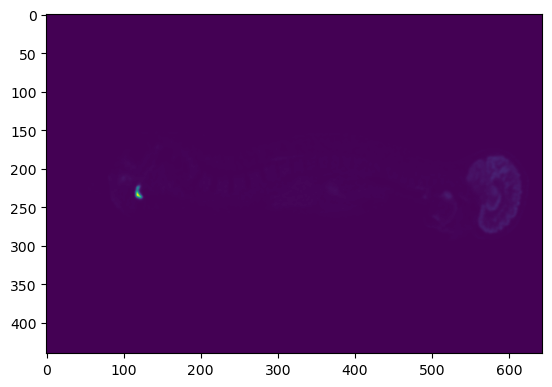

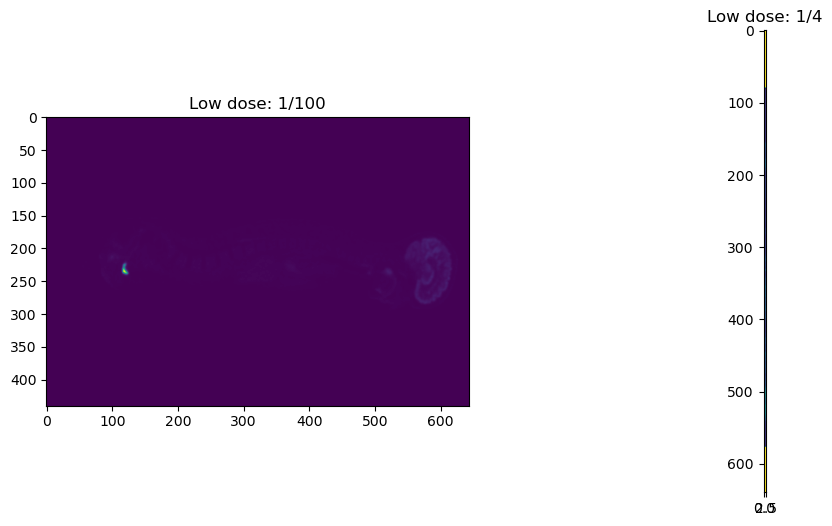

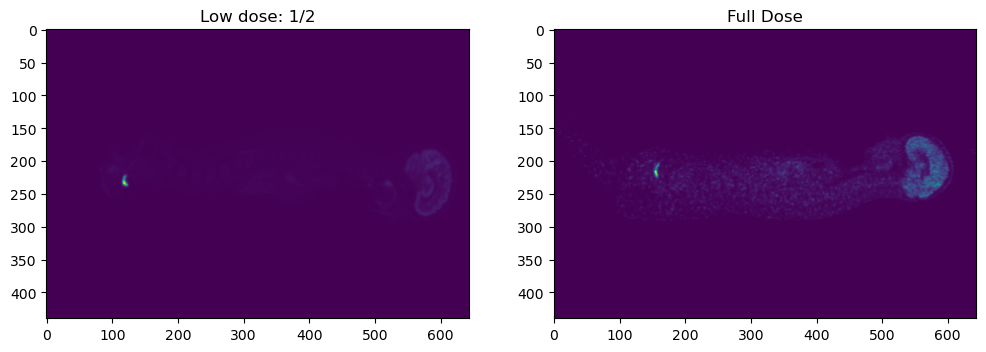

In [31]:
import dicom2nifti


dicom2nifti.convert_directory("/Users/randyllpandohie/Downloads/Siemens Vision Quadra/Subject_136-141/09062022_1_20220609_163454/1-4 dose/", "./build/", compression=True, reorient=True)
dicom2nifti.convert_directory("/Users/randyllpandohie/Downloads/Siemens Vision Quadra/Subject_136-141/09062022_1_20220609_163454/Full_dose/", "./build/", compression=True, reorient=True)
all_images=glob.glob('./build/*.nii.gz')




test_image=nib.load(all_images[1]).get_data()
test_image1=nib.load(all_images[2]).get_data()
test_image2=nib.load(all_images[0]).get_data()
test_image3=nib.load(all_images[3]).get_data()
plt.imshow(test_image[test_image.shape[0]//2])


fig, (ax1, ax2) = plt.subplots(1,2, figsize = (12, 6))
ax1.imshow(test_image[test_image.shape[0]//2])
ax1.set_title('Low dose: 1/100')
ax2.imshow( test_image1[test_image1.shape[0]//2])
ax2.set_title('Low dose: 1/4')
fig, (ax3, ax4) = plt.subplots(1,2, figsize = (12, 6))
ax3.imshow( test_image3[test_image3.shape[0]//2])
ax3.set_title('Low dose: 1/2')
ax4.imshow( test_image2[test_image2.shape[0]//2])
ax4.set_title('Full Dose')

# Test

The test dataset included 50 subjects of low statistics scanned with Siemens Biograph Vision Quadra and United Imaging uEXPLORER.

In [ ]:
#all_images=glob.glob('./data/test/*/*.nii.gz')

def upper(df):
    '''Returns the upper triangle of a correlation matrix.
    You can use scipy.spatial.distance.squareform to recreate matrix from upper triangle.
    Args:
      df: pandas or numpy correlation matrix
    Returns:
      list of values from upper triangle
    '''
    try:
        assert(type(df)==np.ndarray)
    except:
        if type(df)==pd.DataFrame:
            df = df.values
        else:
            raise TypeError('Must be np.ndarray or pd.DataFrame')
    mask = np.triu_indices(df.shape[0], k=1)
    return df[mask]


def low_rank_approx(SVD=None, A=None, r=20):
    """
    Computes an r-rank approximation of a matrix
    given the component u, s, and v of it's SVD
    Requires: numpy
    """
    if not SVD:
        SVD = np.linalg.svd(A, full_matrices=False)
    u, s, v = SVD
    Ar = np.zeros((len(u), len(v)))
    for i in range(r):
        Ar += s[i] * np.outer(u.T[i], v[i])
    return Ar

def compute_low_rank_ordinal(A,B):
    spearmanr_c=0
    A=low_rank_approx(A=A)
    B=low_rank_approx(A=B)
    for counter in range(256):
        rho, pval= stats.spearmanr(upper(A[counter]), upper(B[counter]))
        print(rho)
        spearmanr_c=spearmanr_c+ rho
    return np.mean(spearmanr_c)


all_images=glob.glob('./data/test/190722_03_20220720_145655/*.nii.gz')


files = [os.path.basename(x) for x in all_images]

path = [os.path.dirname(x) for x in all_images]

param =[]

counter=0

filtered = [fn for fn in all_images 
         if not os.path.basename(fn).startswith('new')]

print(len(filtered))


for test_files in filtered:
   # test_image=nib.load(test_files).get_fdata()
    
    test_image=nib.load(test_files)
    img_data = test_image.get_fdata()
    m1=img_data
    m2 = img_as_float(ref_fulldose)
   # m1 = low_rank_approx(A=img_data[1:440],r=20)
    #m2 = low_rank_approx(A=img_as_float(fulldose[1:440],r=20))
    print(m1.shape)
    print(m2.shape)
    lr= compute_low_rank_ordinal(m1,m2)
    #print(lr)
                         
   # lr=.15
    if lr >= 0.0 and lr <= 0.1667:
        w=0.14
    elif lr > 0.333 and lr <= 0.49:
        w=0.28
    elif lr > 0.5 and lr <= 0.65:
        w=0.5
    elif lr > 0.65 and lr <= 0.81:
        w=0.7
    elif lr > 0.7:
        w=0.93
    
    wavelet_smoothed = denoise_wavelet(img_data, multichannel=False,
                           method='BayesShrink', mode='soft',
                           rescale_sigma=True,wavelet='db2')


    img_denoised = denoise_tv_chambolle(wavelet_smoothed, weight=w, multichannel=False)

 
        
    print("Closing up")
    noise_psnr = peak_signal_noise_ratio(test_image, img_denoised, data_range=1.0)
    print("PSNR of input noisy image = ", noise_psnr)
    
    
    #denoise_TV = test_image
    img = nib.Nifti1Image(img_denoised, np.eye(4))
    img.get_data_dtype() == np.dtype(np.int16)
    img.header.get_xyzt_units()
    nib.save(img, os.path.join(path[counter], "new"+files[counter])) 
    counter=counter+1



1
(440, 440, 644)
(3864, 440, 440)


['/Users/randyllpandohie/Downloads/testing/DRF_100.nii.gz', '/Users/randyllpandohie/Downloads/testing/new_improved.nii.gz']


Text(0.5, 1.0, 'New Image')

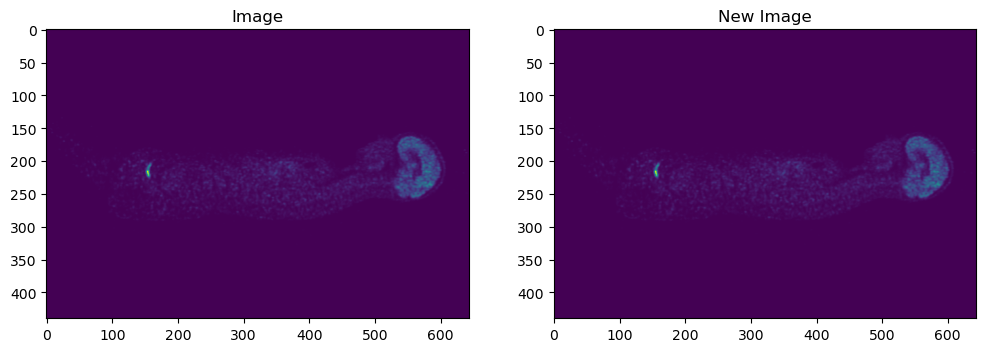

In [10]:
compare_images=glob.glob('/Users/randyllpandohie/Downloads/testing/*.nii.gz') 
print(compare_images)
test_image0=nib.load(compare_images[0]).get_fdata()
test_image1=nib.load(compare_images[1]).get_fdata()


fig, (ax1, ax2) = plt.subplots(1,2, figsize = (12, 6))
ax1.imshow(test_image0[test_image0.shape[0]//2])
ax1.set_title('Image')
ax2.imshow( test_image1[test_image1.shape[0]//2])
ax2.set_title('New Image')

['./data/test/190722_03_20220720_145655/new4d.nii.gz']


Text(0.5, 1.0, 'New Image')

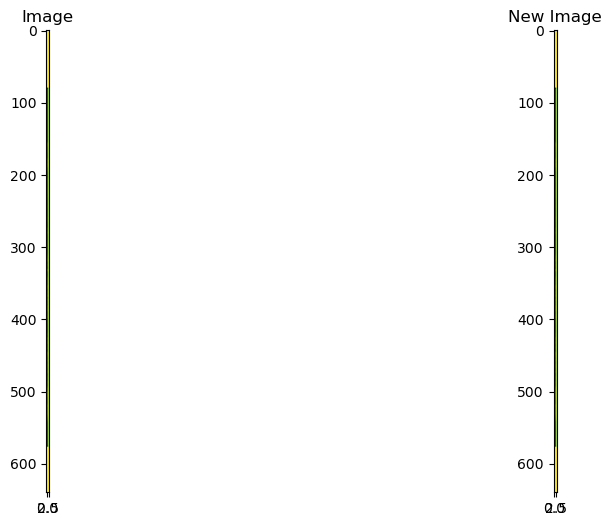